In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models
from torchvision.transforms import v2
import os
import PIL
import cv2
from tqdm import tqdm
import time

In [90]:
import matplotlib
import torchvision
import tqdm
import sklearn

In [91]:
print(pd.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(sklearn.__version__)
print(torch.__version__)
print(torchvision.__version__)
print(tqdm.__version__)
print(cv2.__version__)
from tqdm import tqdm

2.2.3
2.2.6
3.10.7
1.7.1
2.7.1+cu126
0.22.1+cu126
4.67.1
4.12.0


In [92]:
cwd = os.getcwd()
cwd

'/sfs/gpfs/tardis/home/jsk2zs/Project/input'

In [93]:
if 'kbk8vh' in cwd:
  os.chdir('/sfs/gpfs/tardis/home/kbk8vh/Documents/MSDS/DS6050/Project/input')
  DIR = '/sfs/gpfs/tardis/home/kbk8vh/Documents/MSDS/DS6050/Project/input/toxic-plant-classification/tpc-imgs/'
if 'jsk2zs' in cwd:
    os.chdir('/sfs/gpfs/tardis/home/jsk2zs/Project/input')
    DIR = '/sfs/gpfs/tardis/home/jsk2zs/Project/input/toxic-plant-classification/tpc-imgs/'
if 'frv3fp' in cwd:
  os.chdir('/sfs/gpfs/tardis/home/frv3fp/Documents/DS6050/Project/input')
  DIR = '/sfs/gpfs/tardis/home/frv3fp/Documents/DS6050/Project/input/toxic-plant-classification/tpc-imgs/'
elif 'content' in cwd:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/My Drive/DS6050/Project/input')
  DIR = '/content/drive/My Drive/DS6050/Project/input/toxic-plant-classification/tpc-imgs/'
else:
  print('Directory?')
DIR

Directory?


'/sfs/gpfs/tardis/home/jsk2zs/Project/input/toxic-plant-classification/tpc-imgs/'

## Loading Data

In [94]:
toxic_meta = pd.read_csv(DIR + 'toxic_metadata.csv')
nontoxic_meta = pd.read_csv(DIR + 'nontoxic_metadata.csv')
full_meta = pd.read_csv(DIR + 'full_metadata.csv')
full_meta = full_meta.sort_values(['toxicity','class_id'])

print('Full dataset shape: ' + str(full_meta.shape))
full_meta.head()

Full dataset shape: (9952, 7)


class_id             slang              scientific_name  \
0         0  Virginia creeper  Parthenocissus quinquefolia   
1         0  Virginia creeper  Parthenocissus quinquefolia   
2         0  Virginia creeper  Parthenocissus quinquefolia   
3         0  Virginia creeper  Parthenocissus quinquefolia   
4         0  Virginia creeper  Parthenocissus quinquefolia   

   herbarium22_category_id                                               path  \
0                    10340  ../input/toxic-plant-classification/tpc-imgs/n...   
1                    10340  ../input/toxic-plant-classification/tpc-imgs/n...   
2                    10340  ../input/toxic-plant-classification/tpc-imgs/n...   
3                    10340  ../input/toxic-plant-classification/tpc-imgs/n...   
4                    10340  ../input/toxic-plant-classification/tpc-imgs/n...   

   toxicity  species_label  
0         0              3  
1         0              3  
2         0              3  
3         0              3  
4         0              3

## Dataset verification

The dataset downloaded frmom Kaggle contains ten different plant species, five toxic species and five non-toxic species. Each of the ten classes contain roughly 1,000 images. Seven classes contain exactly 1,000 images. Three classes (Fragrant Sumac,  Poison Sumac, and Eastern Poison Oak) contain less than 1,000 images (999, 999, and 954 images, respectively). **Maybe add some visualizations?**

The dataset explicitly labels plants as non-toxic (0) or toxic (1). The classes are approximately balanced, with 4,999 images of non-toxic plants and 4,953 images of toxic plants.

In [95]:
full_meta['toxicity'].value_counts()

toxicity
0    4999
1    4953
Name: count, dtype: int64

In [96]:
full_meta.groupby('toxicity')['slang'].value_counts()

toxicity  slang             
0         Bear Oak              1000
          Boxelder              1000
          Jack-in-the-pulpit    1000
          Virginia creeper      1000
          Fragrant Sumac         999
1         Eastern Poison Ivy    1000
          Western Poison Ivy    1000
          Western Poison Oak    1000
          Poison Sumac           999
          Eastern Poison Oak     954
Name: count, dtype: int64

## Validation Split

The dataset was split using a 70/15/15 train/validation/test split, stratified by both species and toxicity.

In [97]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [98]:
class PlantDatasetWithSpecies(torch.utils.data.Dataset):
    def __init__(self, subset, metadata):
        self.subset = subset
        self.metadata = metadata
        
    def __getitem__(self, idx):
        image, label = self.subset[idx]
        actual_idx = self.subset.indices[idx]
        species = self.metadata.iloc[actual_idx]['slang']
        return image, label, species
    
    def __len__(self):
        return len(self.subset)

In [99]:
# Dataset parameters
batch_size = 32
img_height = 224
img_width = 224
num_classes = 2

# Class names for toxic vs. non-toxic
class_names = ['Non-Toxic','Toxic']

# Data transforms
train_transform = transforms.v2.Compose([
    transforms.v2.Resize((img_height, img_width)),
    transforms.v2.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_strong = transforms.v2.Compose([
    transforms.v2.RandomResizedCrop((img_height, img_width), scale=(0.8, 1.0)),
    transforms.v2.RandomHorizontalFlip(),
    transforms.v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transform = transforms.v2.Compose([
    transforms.v2.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create full dataset
full_dataset = datasets.ImageFolder(DIR)

# Training indexes (0.7) and temporary indexes (0.3, which will be split into 0.15 and 0.15)
train_idx, temp_idx = train_test_split(full_meta.index,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=full_meta[['toxicity', 'scientific_name']])
temp_meta = full_meta.loc[temp_idx]

# Validation indexes (0.15) and test indexes (0.15)
val_idx, test_idx = train_test_split(temp_idx,
                                     test_size=0.5,
                                     random_state=42,
                                     stratify=temp_meta[['toxicity', 'scientific_name']])

# Create subsets for train, val, test
train_dataset = Subset(full_dataset, train_idx)
train_dataset_strong_aug = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Apply transforms
train_dataset.dataset.transform = train_transform
train_dataset_strong_aug.dataset.transform = train_transform_strong
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# Test dataset with species
test_dataset_with_species = PlantDatasetWithSpecies(test_dataset, full_meta)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
train_strong_loader = DataLoader(train_dataset_strong_aug, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset_with_species, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)} ({int(100*(len(train_dataset)/len(full_dataset)))}%)")
print(f"Validation samples: {len(val_dataset)} ({int(100*(len(val_dataset)/len(full_dataset)))}%)")
print(f"Test samples: {len(test_dataset)} ({int(100*(len(test_dataset)/len(full_dataset)))}%)")

Training samples: 6966 (69%)
Validation samples: 1493 (15%)
Test samples: 1493 (15%)


### Ensuring the datasets are stratified by toxicity and species.

In [100]:
# Train
full_meta.iloc[train_idx].groupby('toxicity')['slang'].value_counts()

toxicity  slang             
0         Fragrant Sumac        701
          Bear Oak              700
          Boxelder              700
          Jack-in-the-pulpit    700
          Virginia creeper      700
1         Western Poison Oak    705
          Eastern Poison Ivy    701
          Poison Sumac          699
          Western Poison Ivy    699
          Eastern Poison Oak    661
Name: count, dtype: int64

In [101]:
# Validation
full_meta.iloc[val_idx].groupby('toxicity')['slang'].value_counts()

toxicity  slang             
0         Bear Oak              152
          Boxelder              150
          Jack-in-the-pulpit    150
          Virginia creeper      150
          Fragrant Sumac        147
1         Eastern Poison Ivy    150
          Poison Sumac          150
          Western Poison Ivy    150
          Western Poison Oak    150
          Eastern Poison Oak    144
Name: count, dtype: int64

In [102]:
# Test
full_meta.iloc[test_idx].groupby('toxicity')['slang'].value_counts()

toxicity  slang             
0         Fragrant Sumac        151
          Boxelder              150
          Jack-in-the-pulpit    150
          Virginia creeper      150
          Bear Oak              148
1         Western Poison Ivy    151
          Poison Sumac          150
          Eastern Poison Ivy    149
          Eastern Poison Oak    149
          Western Poison Oak    145
Name: count, dtype: int64

## Baseline model

A random forest baseline model was used to assess if the use of deep learning methods is necessary.

Inspo: https://www.geeksforgeeks.org/machine-learning/random-forest-for-image-classification-using-opencv/

https://www.youtube.com/watch?v=zSbXfnQPx_k

### Color histogram

In [103]:
def color_histogram(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bins = 4
    # Channels for R, G, B; no mask; 4 bins; ranges (0,256)
    hist = cv2.calcHist([img_rgb],[0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

### GLCM Texture

In [104]:
from skimage.feature import graycomatrix, graycoprops

def glcm_texture(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  glcm = graycomatrix(gray, [2], [np.pi/2])
  energy = graycoprops(glcm, 'energy')[0, 0]
  homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
  correlation = graycoprops(glcm, 'correlation')[0, 0]
  contrast = graycoprops(glcm, 'contrast')[0, 0]
  dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
  return energy, homogeneity, correlation, contrast, dissimilarity

### Shape features (circularity, aspect ratio)

In [105]:
def shape_features(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contour = contours[0]
  area = cv2.contourArea(contour)
  perimeter = cv2.arcLength(contour, True)
  if perimeter == 0:
        circularity = 0
  else:
        circularity = (4 * np.pi * area) / (perimeter ** 2)
  x, y, w, h = cv2.boundingRect(contour)
  aspect_ratio = float(w) / h
  return circularity, aspect_ratio

### Combined feature extraction and random forest model



In [106]:
def extract_features(img):
  hist = color_histogram(img)
  energy, homogeneity, correlation, contrast, dissimilarity = glcm_texture(img)
  circularity, aspect_ratio = shape_features(img)
  return np.hstack([
    hist,
    energy,
    homogeneity,
    correlation,
    contrast,
    dissimilarity,
    circularity,
    aspect_ratio
])

In [107]:
def read_images(dataset):
    paths  = dataset['path'].tolist()
    labels = dataset['toxicity'].tolist()
    imgs = []
    for path in tqdm(paths, total=len(paths), desc="Reading images"):
        imgs.append(cv2.imread(path))
    return imgs, labels

def store_features_labels(imgs, labels):
    features = []
    valid_labels = []
    for img, label in tqdm(zip(imgs, labels), total=len(imgs), desc="Extracting features"):
        if img is None:
            continue
        feat = extract_features(img)
        if feat is None or np.any(np.isnan(feat)):
            continue
        features.append(feat)
        valid_labels.append(label)
    return np.vstack(features), np.array(valid_labels)

In [108]:
# Create train, validation, test datasets
rf_train = full_meta.iloc[train_idx]
rf_val = full_meta.iloc[val_idx]
rf_test = full_meta.iloc[test_idx]

In [109]:
# Train: read images
imgs_train, labels_train = read_images(rf_train)

Reading images: 100%|██████████| 6966/6966 [00:11<00:00, 612.38it/s]


In [110]:
# X_train, y_train
X_train, y_train = store_features_labels(imgs_train, labels_train)

Extracting features: 100%|██████████| 6966/6966 [00:21<00:00, 331.09it/s]


In [111]:
# Validation: read images
val_imgs, val_labels = read_images(rf_val)

Reading images: 100%|██████████| 1493/1493 [00:02<00:00, 615.18it/s]


In [112]:
# X_val, y_val
X_val, y_val = store_features_labels(val_imgs, val_labels)

Extracting features: 100%|██████████| 1493/1493 [00:04<00:00, 322.26it/s]


In [113]:
# Test: read images
test_imgs, test_labels = read_images(rf_test)

Reading images: 100%|██████████| 1493/1493 [00:02<00:00, 600.77it/s]


In [114]:
# X_test, y_test
X_test, y_test = store_features_labels(test_imgs, test_labels)

Extracting features: 100%|██████████| 1493/1493 [00:04<00:00, 333.34it/s]


## Slides Figure 1: Toxic vs Non-Toxic Lookalike Pair

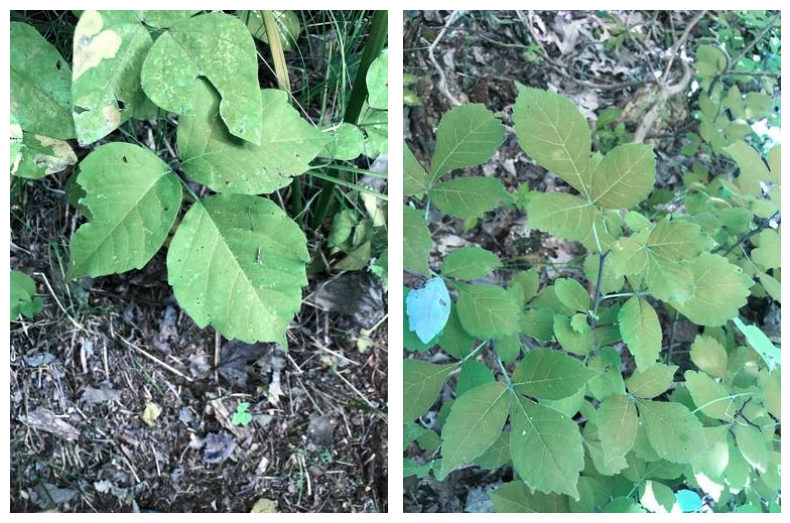

In [115]:
toxic_img = cv2.imread(DIR + 'toxic_images/003/051.jpg')
nontoxic_img = img = cv2.imread(DIR + 'nontoxic_images/004/038.jpg')

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
axes[0].imshow(toxic_img)
#axes[0].set_title("Western Poison Ivy - Toxic")
axes[0].axis("off")

axes[1].imshow(nontoxic_img)
#axes[1].set_title("Fragrant Sumac - Non-Toxic")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## Random Forest Untuned

In [116]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train);

y_pred = clf.predict(X_val)
y_pred_proba = clf.predict_proba(X_val)[:, 1]
acc = accuracy_score(y_val, y_pred)
#print(f"Binary accuracy: {acc:.3f}")


Metrics Report:
               precision    recall  f1-score   support

Non-toxic (0)       0.65      0.65      0.65       749
    Toxic (1)       0.65      0.65      0.65       744

     accuracy                           0.65      1493
    macro avg       0.65      0.65      0.65      1493
 weighted avg       0.65      0.65      0.65      1493



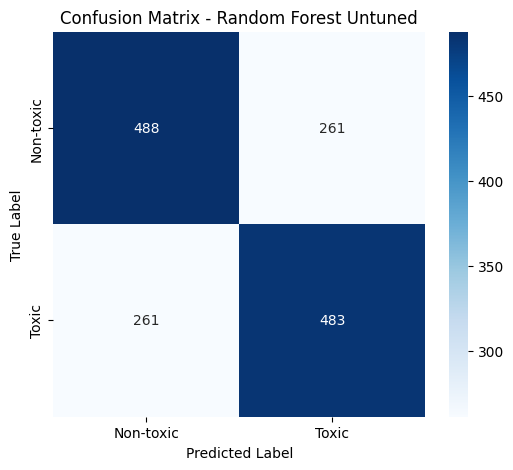

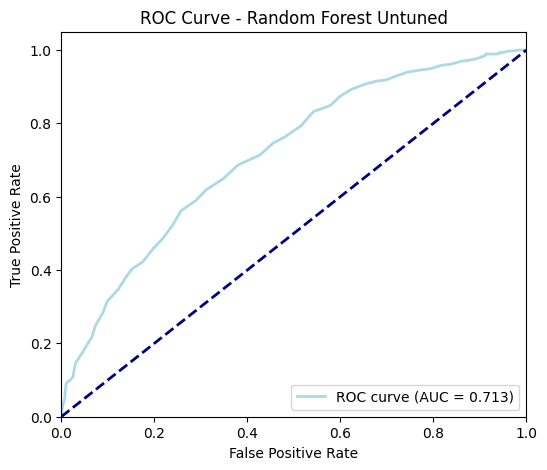

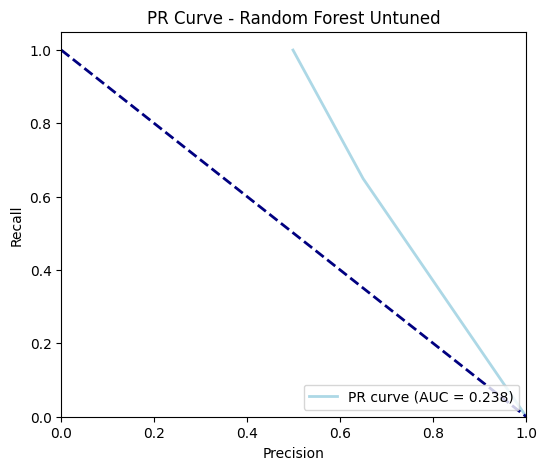

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    auc,
    RocCurveDisplay
)

# Binary Accuracy 
#print(f"Binary accuracy: {acc:.3f}")

# Metrics Report
print("\nMetrics Report:")
print(classification_report(y_val, y_pred, target_names=["Non-toxic (0)", "Toxic (1)"]))
cr = classification_report(y_val, y_pred, target_names=class_names, output_dict=True)

acc = {}
acc['Random Forest Untuned'] = cr['accuracy']
prec = {}
prec['Random Forest Untuned'] = cr['Toxic']['precision']
rec = {}
rec['Random Forest Untuned'] = cr['Toxic']['recall']
f1toxic = {}
f1toxic['Random Forest Untuned'] = cr['Toxic']['f1-score']
f1nontoxic = {}
#f1nontoxic['Random Forest Untuned'] = cr['Non-toxic']['f1-score']

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-toxic", "Toxic"], yticklabels=["Non-toxic", "Toxic"])
plt.title("Confusion Matrix - Random Forest Untuned")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# False negative rate (for toxic species)
TN, FP, FN, TP = cm.ravel()
fn = {}
if FN > 0:
    fn['Random Forest Untuned'] = FN / (FN + TP)
    
# ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)
roc = {}
roc['Random Forest Untuned'] = roc_auc

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='lightblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Untuned')
plt.legend(loc="lower right")
plt.show()

# PR Curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
pr_auc = auc(precision, recall)
pr = {}
pr['Random Forest Untuned'] = pr_auc

plt.figure(figsize=(6,5))
plt.plot(precision, recall, color='lightblue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('PR Curve - Random Forest Untuned')
plt.legend(loc="lower right")
plt.show()

## Random Forest Tuned

In [118]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Define the model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define parameter search space
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'bootstrap': [True, False]
}

# Setup randomized search
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,           # number of candidate parameter settings
    cv=5,                # 5‑fold cross‐validation
    scoring='accuracy',  # or another metric like 'roc_auc'
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit on your train data
search.fit(X_train, y_train)

print("Best params:", search.best_params_)
best_rf = search.best_estimator_

# Then evaluate on validation set
y_pred_tuned = best_rf.predict(X_val)
y_pred_proba_tuned = best_rf.predict_proba(X_val)[:, 1]
acc_val_tuned = accuracy_score(y_val, y_pred_tuned)
#print(f"Validation accuracy: {acc_val_tuned:.3f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}



Metrics Report (Tuned Model):
              precision    recall  f1-score   support

   Non-Toxic       0.67      0.64      0.66       749
       Toxic       0.65      0.68      0.66       744

    accuracy                           0.66      1493
   macro avg       0.66      0.66      0.66      1493
weighted avg       0.66      0.66      0.66      1493



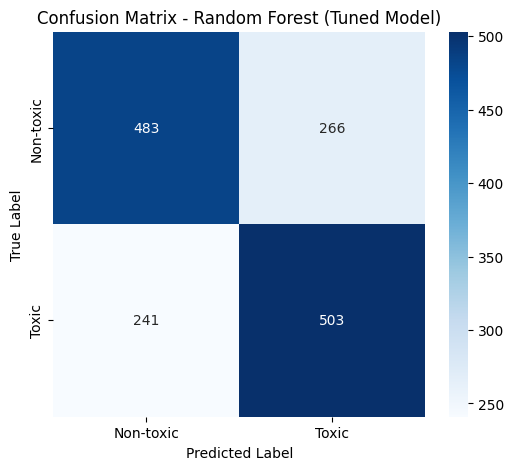

False Negative Rate: 0.3239247311827957


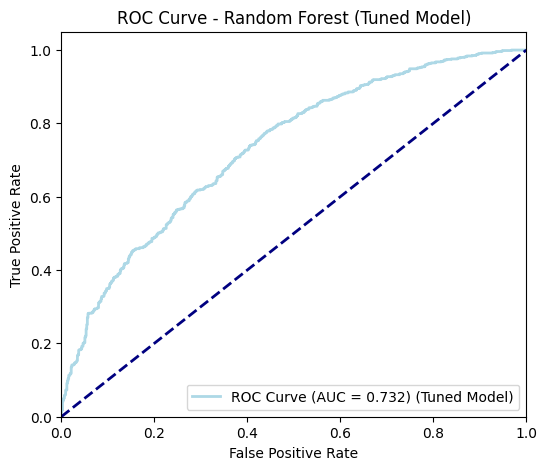

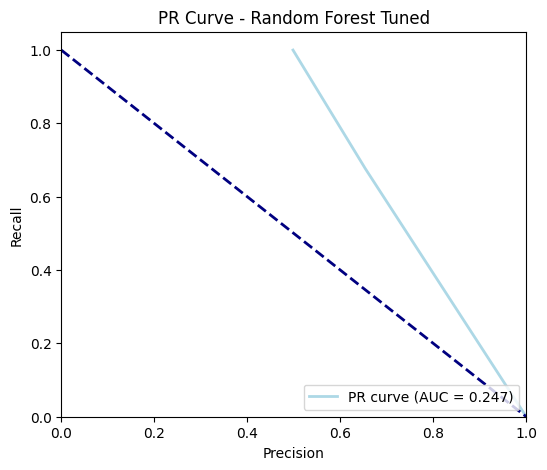

In [119]:
# Metrics Report
print("\nMetrics Report (Tuned Model):")
print(classification_report(y_val, y_pred_tuned, target_names=class_names))
cr = classification_report(y_val, y_pred_tuned, target_names=class_names, output_dict=True)
acc['Random Forest Tuned'] = cr['accuracy']
prec['Random Forest Tuned'] = cr['Toxic']['precision']
rec['Random Forest Tuned'] = cr['Toxic']['recall']
f1toxic['Random Forest Tuned'] = cr['Toxic']['f1-score']
#f1nontoxic['Random Forest Tuned'] = cr['Non-toxic']['f1-score']

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_tuned)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-toxic", "Toxic"], yticklabels=["Non-toxic", "Toxic"])
plt.title("Confusion Matrix - Random Forest (Tuned Model)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# False negative rate (for toxic species)
TN, FP, FN, TP = cm.ravel()
if FN > 0:
    fn['Random Forest Tuned'] = FN / (FN + TP)
    print(f'False Negative Rate: {FN / (FN + TP)}')
    
# ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_tuned)
roc_auc = auc(fpr, tpr)
roc['Random Forest Tuned'] = roc_auc

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='lightblue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f}) (Tuned Model)')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Tuned Model)')
plt.legend(loc="lower right")
plt.show()

# PR Curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_tuned)
pr_auc = auc(precision, recall)
pr['Random Forest Tuned'] = pr_auc

plt.figure(figsize=(6,5))
plt.plot(precision, recall, color='lightblue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('PR Curve - Random Forest Tuned')
plt.legend(loc="lower right")
plt.show()

## Functions for model training/evaluation

In [120]:
# Hyperparameters/Options
batch_size = 32
num_epochs = 10
learning_rate = .0001
dropout = 0.2

### Cutout Code

In [121]:
# ============================================================================
# Training and Evaluation Functions (Provided - No modifications needed)
# ============================================================================
mixup = transforms.v2.MixUp(num_classes=2, alpha=1.0)

def train_epoch(model, model_name, dataloader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        if ('_HA' in model_name.upper()) or ('HEAVY' in model_name.upper()):
            inputs, labels = mixup(inputs, labels)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if ('_HA' in model_name.upper()) or ('HEAVY' in model_name.upper()):
            loss = -torch.mean(torch.sum(F.log_softmax(outputs, dim=1) * labels, dim=1))
            _, predicted = outputs.max(1)
            _, labels_idx = labels.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels_idx).sum().item()
        else:
            loss = criterion(outputs, labels)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def metrics(current_model):
    current_model.eval()
    y_true = []
    y_pred = []
    species_list = []

    if current_model == model_rand_weights_la:
        name = 'EfficientNetB0, Random Weights, Light Aug'
    elif current_model == model_rand_weights_ha:
        name = 'EfficientNetB0, Random Weights, Heavy Aug'
    elif current_model == model_pretrained_weights_la:
        name = 'EfficientNetB0, Pretrained Weights, Light Aug'
    elif current_model == model_pretrained_weights_ha:
        name = 'EfficientNetB0, Pretrained Weights, Heavy Aug'
    elif current_model == model_cbam_random_la:
        name = 'EfficientNetB0_CBAM, Random Weights, Light Aug'
    elif current_model == model_cbam_random_ha:
        name = 'EfficientNetB0_CBAM, Random Weights, Heavy Aug'
    elif current_model == model_cbam_pretrained_la:
        name = 'EfficientNetB0_CBAM, Pretrained Weights, Light Aug'
    elif current_model == model_cbam_pretrained_ha:
        name = 'EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug'
    elif current_model == model_cbam_pretrained_la_02:
        name = 'EfficientNetB2_CBAM, Pretrained Weights, Light Aug'
    elif current_model == model_cbam_pretrained_ha_02:
        name = 'EfficientNetB2_CBAM, Pretrained Weights, Heavy Aug'
    else:
        name = 'MODEL NOT NAMED'
    
    with torch.no_grad():
        for images, labels, species in test_loader:
            n = images.size(0)
            images, labels = images.to(device), labels.to(device)
            outputs = current_model(images)
            _, predicted = outputs.max(1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            species_list.extend(species)

    df_test = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'species': species_list
    })
    
    # Print classification report
    cr = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    acc[name] = cr['accuracy']
    prec[name] = cr['Toxic']['precision']
    rec[name] = cr['Toxic']['recall']
    f1toxic[name] = cr['Toxic']['f1-score']
    #ftnontoxic[name] = cr['Non-toxic']['f1-score']

    
    print(f"\nClassification Report for {name}':\n")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # False negative rate for model (only toxic species)
    TN, FP, FN, TP = cm.ravel()
    if FN > 0:
        fn[name] = FN / (FN + TP)

    # Confsion matrices to interpret specific plant pairs
    species_list = full_meta.sort_values(['toxicity','class_id'])['slang'].unique()
    n_species = len(species_list)
    fn_species = {}
    
    cols, rows = 5, 2
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten()
    fig.suptitle(f'Confusion Matrices by Species for {name}', fontsize=20, y=1.01)
    for ax, species in zip(axes, species_list):
        species_df = df_test[df_test['species'] == species]
        cm_species = confusion_matrix(species_df['y_true'], species_df['y_pred'], labels=[0, 1])
        TN, FP, FN, TP = cm_species.ravel()
        if FN > 0:
            fn_species[species] = FN / (FN + TP)
        im = ax.imshow(cm_species, cmap='Greens')
        ax.set_title(species, fontsize=14)
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(class_names, rotation=45, ha='right')
        ax.set_yticklabels(class_names)
    
        for i in range(cm_species.shape[0]):
            for j in range(cm_species.shape[1]):
                ax.text(
                    j, i, str(cm_species[i, j]),
                    ha='center', va='center',
                    fontsize=14, fontweight='bold',
                    color='black'
                )
    for ax in axes[len(species_list):]:
        ax.axis('off')
    fig.supxlabel('Predicted Values', fontsize=18)
    fig.supylabel('True Values', fontsize=18)
    plt.tight_layout()
    plt.show()
    fn_species_df = pd.DataFrame.from_dict(fn_species, orient='index')
    fn_species_df.columns = ['False Negative Rate']
    print(fn_species_df.to_string(justify='left'))

    # ROC Curve & AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    roc[name] = roc_auc

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='lightblue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

    # PR Curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(precision, recall)
    pr[name] = pr_auc

    plt.figure(figsize=(6,5))
    plt.plot(precision, recall, color='lightblue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title(f'PR Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()


def train_model(model, model_name, train_loader, val_loader, num_epochs=10, lr=learning_rate):
    """
    Train and evaluate a model.

    Returns:
        Dictionary with training history
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        train_loss, train_acc = train_epoch(model, model_name, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        scheduler.step()

    return history


def plot_training_history(history, title="Training History"):
    """Plot training and validation loss/accuracy."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [122]:
total_timing = {}
def show_training(model, model_name, train_loader=train_loader, val_loader=val_loader, num_epochs=10):
    # Print number of parameters
    print(f"{model_name}0: {sum(p.numel() for p in model.parameters()):,}")
    start_time = time.time()
    
    # Train model using training loader and validate on validation loader
    model_history = train_model(model, model_name, train_loader, val_loader, num_epochs=num_epochs)

    end_time = time.time()
    total_seconds = end_time - start_time

    total_timing[model_name] = total_seconds
    
    # Store results
    results = {}
    results[model_name] = model_history['val_acc'][-1]
    
    # Plot results
    plot_training_history(model_history, model_name)

## EfficientNetB0

In [123]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [124]:
def EffNetB0(pretrained=True):
    # If pretrained is true, use ImageNet for weights, else use random weights
    if pretrained:
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    else:
        model = models.efficientnet_b0(weights=None)
    
    # Freeze base layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Replace classifier head
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(num_features, 2)  # binary classification: toxic vs. non-toxic
    )
    
    model = model.to(device)
    return model

### EfficientNetB0, Random Weights, Light Augmentation

EfficientNetB0, Random Weights, Light Aug0: 4,010,110

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.84it/s]


Train Loss: 0.6980, Train Acc: 49.97%
Val Loss: 0.6989, Val Acc: 51.24%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.57it/s]


Train Loss: 0.6983, Train Acc: 50.20%
Val Loss: 0.7070, Val Acc: 51.17%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.31it/s]


Train Loss: 0.6981, Train Acc: 50.52%
Val Loss: 0.6929, Val Acc: 50.97%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.86it/s]


Train Loss: 0.6960, Train Acc: 51.18%
Val Loss: 0.7332, Val Acc: 51.31%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.10it/s]


Train Loss: 0.6983, Train Acc: 51.29%
Val Loss: 0.6939, Val Acc: 51.31%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.17it/s]


Train Loss: 0.6945, Train Acc: 50.42%
Val Loss: 0.7144, Val Acc: 51.44%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.51it/s]


Train Loss: 0.6954, Train Acc: 51.02%
Val Loss: 0.7088, Val Acc: 51.91%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.61it/s]


Train Loss: 0.6961, Train Acc: 50.53%
Val Loss: 0.7110, Val Acc: 51.51%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.17it/s]


Train Loss: 0.6954, Train Acc: 50.79%
Val Loss: 0.6921, Val Acc: 51.91%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.90it/s]


Train Loss: 0.6970, Train Acc: 50.67%
Val Loss: 0.6937, Val Acc: 51.84%


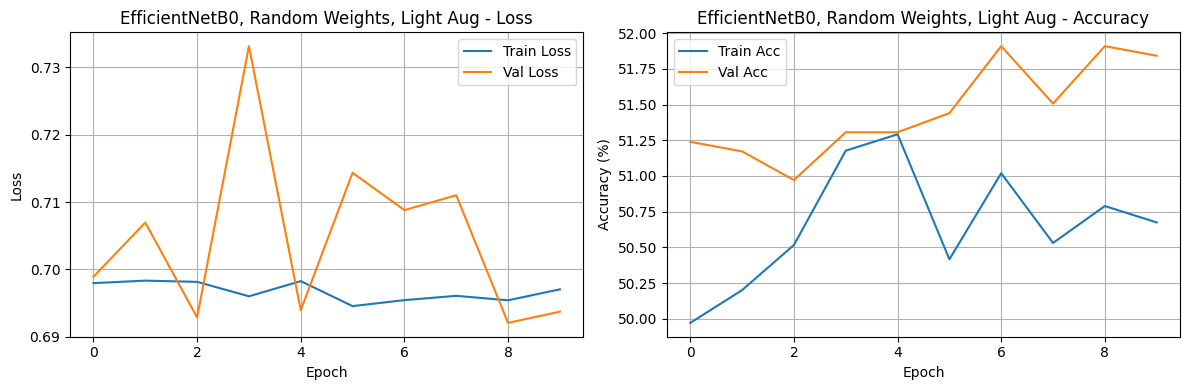

In [125]:
model_rand_weights_la = EffNetB0(pretrained=False)
show_training(model_rand_weights_la, 'EfficientNetB0, Random Weights, Light Aug')

#### Evaluation


Classification Report for EfficientNetB0, Random Weights, Light Aug':

              precision    recall  f1-score   support

   Non-Toxic       0.52      0.71      0.60       749
       Toxic       0.53      0.33      0.41       744

    accuracy                           0.52      1493
   macro avg       0.53      0.52      0.50      1493
weighted avg       0.53      0.52      0.51      1493



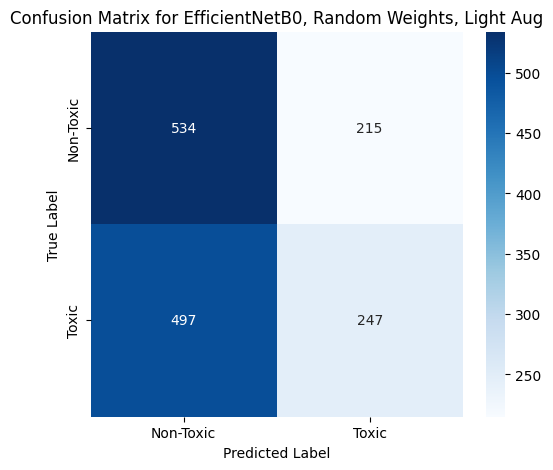

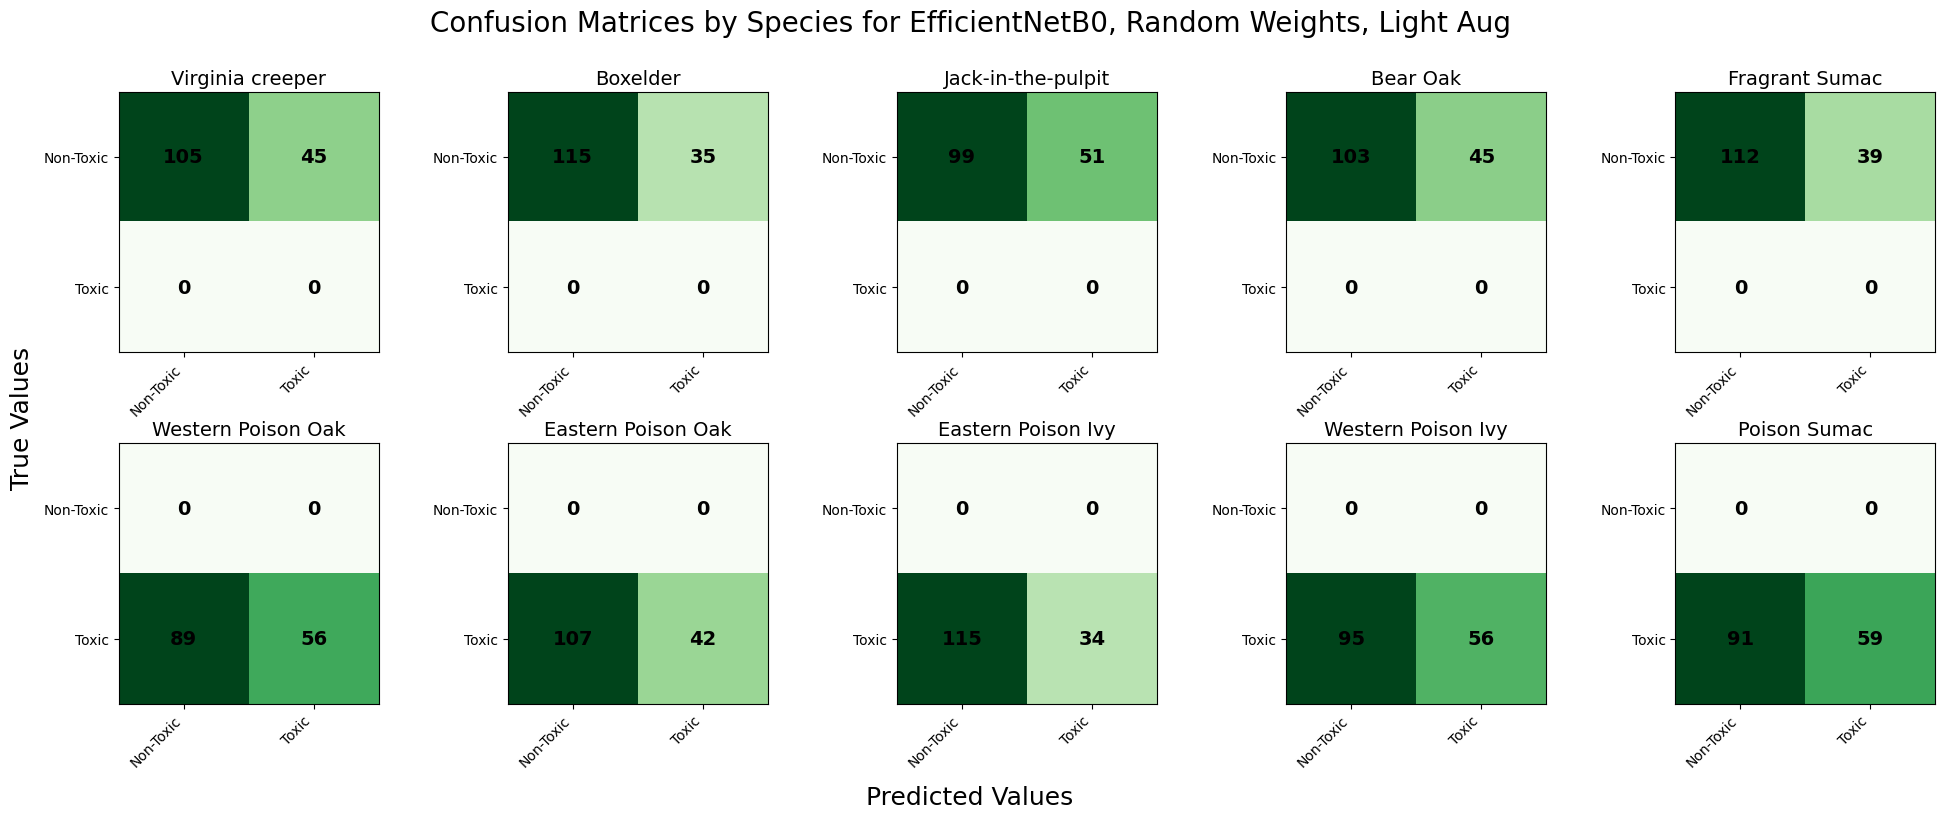

                    False Negative Rate
Western Poison Oak  0.613793           
Eastern Poison Oak  0.718121           
Eastern Poison Ivy  0.771812           
Western Poison Ivy  0.629139           
Poison Sumac        0.606667           


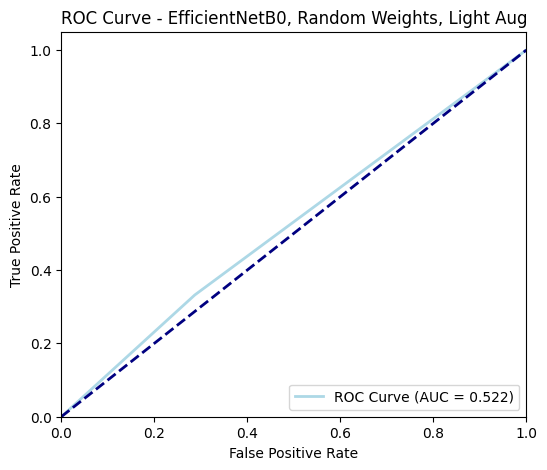

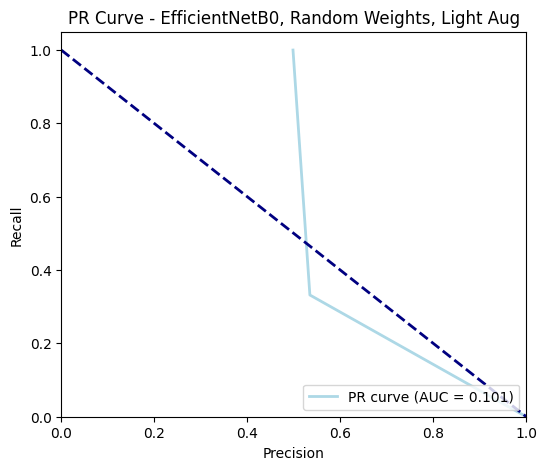

In [126]:
metrics(model_rand_weights_la)

# EfficientNetB0, Random Weights, Heavy Augmentation

EfficientNetB0, Random Weights, Heavy Aug0: 4,010,110

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.57it/s]


Train Loss: 0.6994, Train Acc: 50.22%
Val Loss: 0.8191, Val Acc: 49.16%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.36it/s]


Train Loss: 0.6979, Train Acc: 49.43%
Val Loss: 0.9512, Val Acc: 49.23%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.40it/s]


Train Loss: 0.6972, Train Acc: 50.63%
Val Loss: 1.0007, Val Acc: 50.44%

Epoch 4/10
------------------------------


Training:  11%|█         | 23/218 [00:02<00:15, 12.70it/s]

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   5.0s
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   9.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   5.6s
[CV] END bootstrap=False, max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.6s
[CV] END bootstrap=False, max_depth=40, max_features=0.3, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  24.3s
[CV] END bootstrap=False, max_depth=40, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  30.6s
[CV] END bootstrap=False, max_depth=30, max_f

Training:  18%|█▊        | 39/218 [00:03<00:11, 15.81it/s]

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   8.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   7.0s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   3.8s
[CV] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=False, max_depth=40, max_features=0.3, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  25.7s
[CV] END bootstrap=False, max_depth=40, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  56.9s
[CV] END bootstrap=False, max_depth=30, max

Training:  29%|██▉       | 63/218 [00:04<00:09, 15.82it/s]

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   4.7s
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  14.3s
[CV] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END bootstrap=False, max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  12.2s
[CV] END bootstrap=False, max_depth=40, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  45.4s
[CV] END bootstrap=False, max_depth=40, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  28.5s
[CV] END bootstrap=True, max_depth=10, max_featu

Training:  33%|███▎      | 73/218 [00:05<00:09, 15.48it/s]

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   4.0s
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  13.8s
[CV] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=False, max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.7s
[CV] END bootstrap=False, max_depth=40, max_features=0.3, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  50.7s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  24.2s
[CV] END bootstrap=True, max_depth=10, max_fe

Training:  37%|███▋      | 81/218 [00:05<00:09, 14.53it/s]

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   5.1s
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   4.1s
[CV] END bootstrap=False, max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.6s
[CV] END bootstrap=False, max_depth=40, max_features=0.3, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  49.6s
[CV] END bootstrap=False, max_depth=40, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  51.9s
[CV] END bootstrap=True, max_depth=None, max_

Training:  41%|████      | 89/218 [00:06<00:14,  8.95it/s]

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  10.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   5.5s
[CV] END bootstrap=True, max_depth=40, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=False, max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  12.1s
[CV] END bootstrap=False, max_depth=40, max_features=0.3, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  51.1s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  24.4s
[CV] END bootstrap=True, max_depth=10, max_

Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.42it/s]


Train Loss: 0.6975, Train Acc: 49.87%
Val Loss: 1.3361, Val Acc: 50.44%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.49it/s]


Train Loss: 0.6957, Train Acc: 50.10%
Val Loss: 0.9129, Val Acc: 52.24%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.21it/s]


Train Loss: 0.6962, Train Acc: 49.78%
Val Loss: 0.7313, Val Acc: 50.84%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.57it/s]


Train Loss: 0.6961, Train Acc: 50.66%
Val Loss: 0.8049, Val Acc: 53.18%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.70it/s]


Train Loss: 0.6962, Train Acc: 50.98%
Val Loss: 0.8801, Val Acc: 52.31%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.97it/s]


Train Loss: 0.6975, Train Acc: 50.27%
Val Loss: 0.8443, Val Acc: 53.32%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.58it/s]


Train Loss: 0.6947, Train Acc: 51.45%
Val Loss: 0.9362, Val Acc: 51.71%


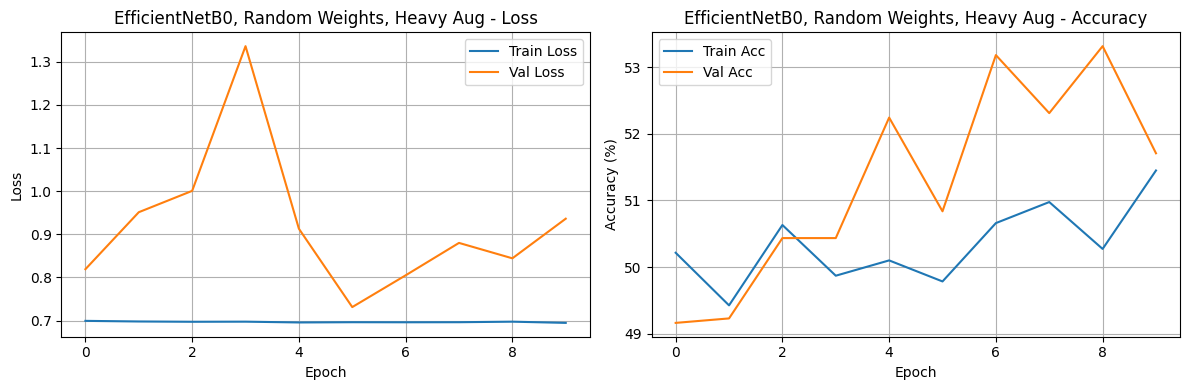

In [127]:
model_rand_weights_ha = EffNetB0(pretrained=False)
show_training(model_rand_weights_ha, 'EfficientNetB0, Random Weights, Heavy Aug', train_loader = train_strong_loader)

#### Evaluation


Classification Report for EfficientNetB0, Random Weights, Heavy Aug':

              precision    recall  f1-score   support

   Non-Toxic       0.53      0.38      0.45       749
       Toxic       0.52      0.66      0.58       744

    accuracy                           0.52      1493
   macro avg       0.53      0.52      0.51      1493
weighted avg       0.53      0.52      0.51      1493



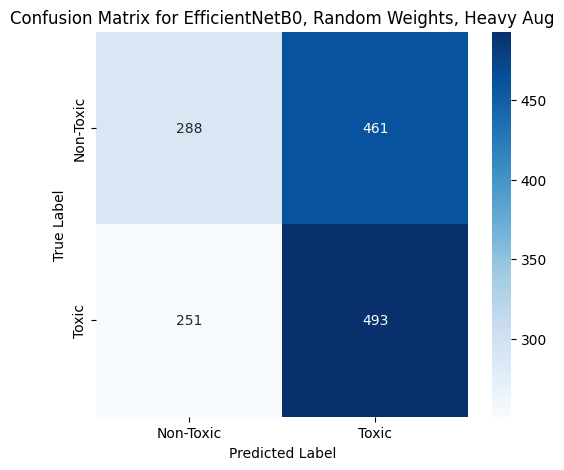

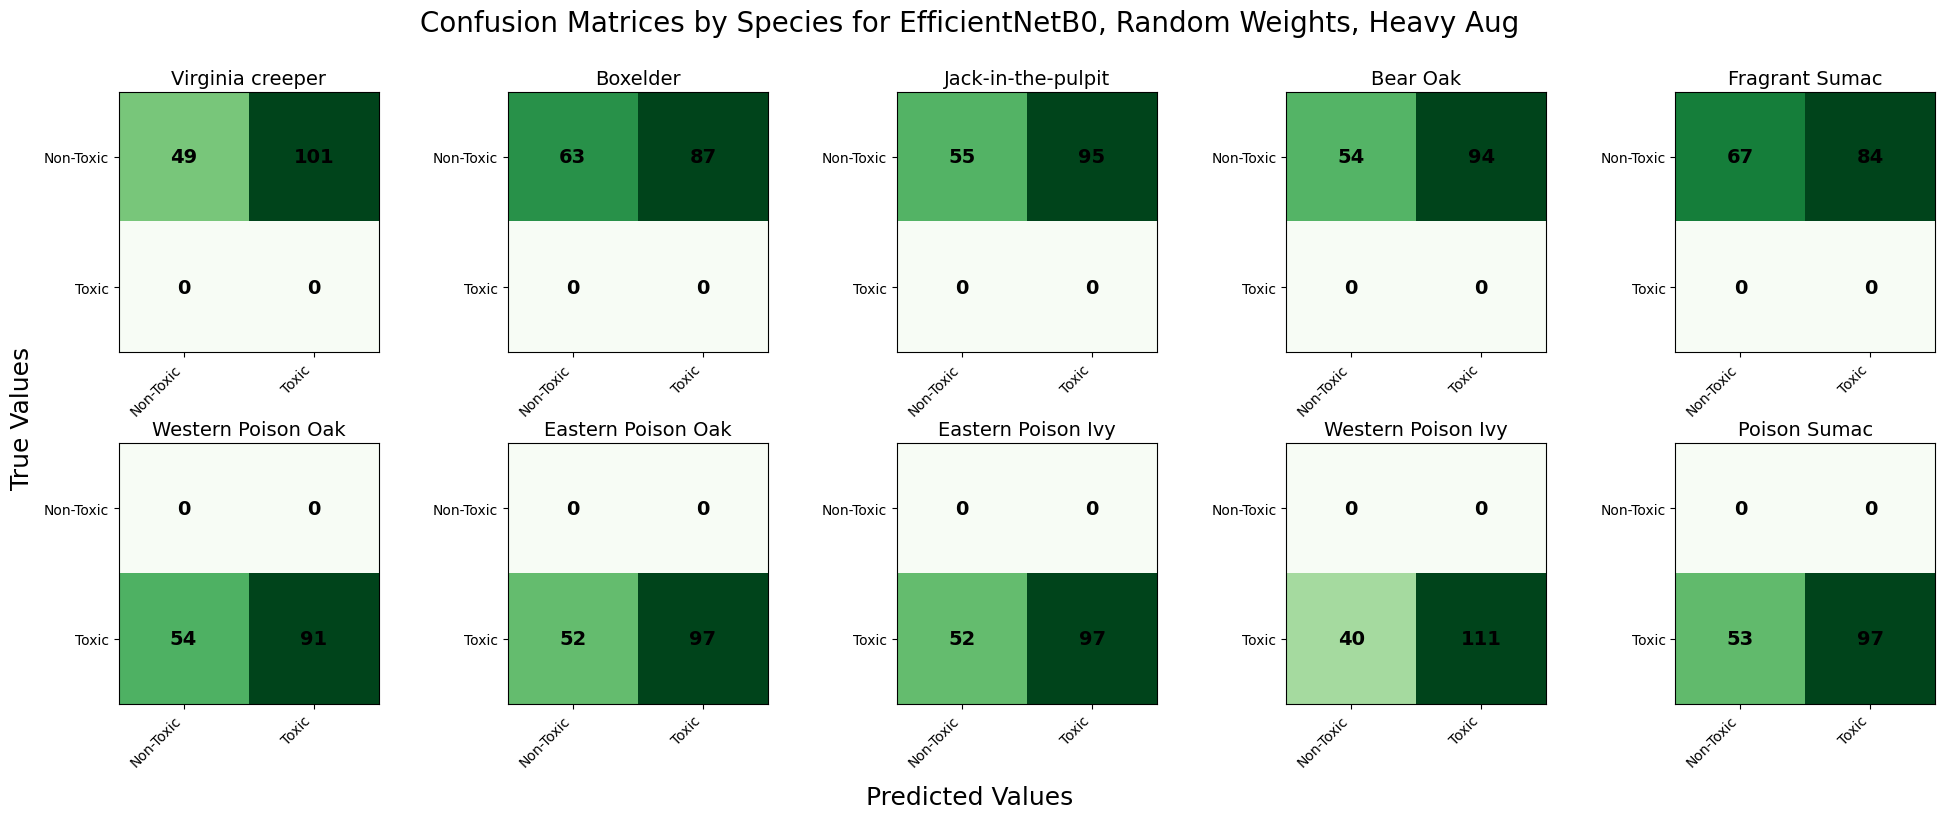

                    False Negative Rate
Western Poison Oak  0.372414           
Eastern Poison Oak  0.348993           
Eastern Poison Ivy  0.348993           
Western Poison Ivy  0.264901           
Poison Sumac        0.353333           


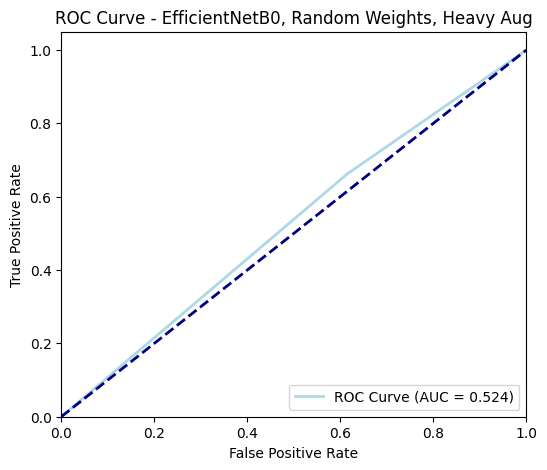

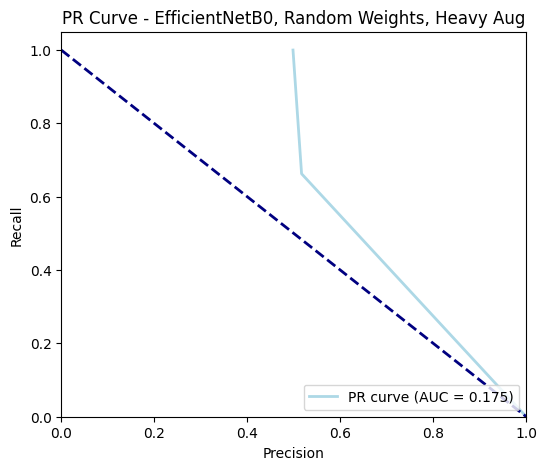

In [128]:
metrics(model_rand_weights_ha)

### EfficientNetB0 Model, ImageNet Weights, Light Augmentation

EfficientNetB0, Pretrained Weights, Light Aug0: 4,010,110

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.45it/s]


Train Loss: 0.6888, Train Acc: 53.95%
Val Loss: 0.6536, Val Acc: 63.43%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.21it/s]


Train Loss: 0.6529, Train Acc: 61.93%
Val Loss: 0.6242, Val Acc: 67.72%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.07it/s]


Train Loss: 0.6314, Train Acc: 65.02%
Val Loss: 0.6073, Val Acc: 69.52%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.69it/s]


Train Loss: 0.6231, Train Acc: 65.63%
Val Loss: 0.5930, Val Acc: 70.26%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.96it/s]


Train Loss: 0.6116, Train Acc: 67.67%
Val Loss: 0.5893, Val Acc: 70.13%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.99it/s]


Train Loss: 0.6051, Train Acc: 67.51%
Val Loss: 0.5870, Val Acc: 70.13%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.51it/s]


Train Loss: 0.6050, Train Acc: 67.90%
Val Loss: 0.5835, Val Acc: 69.79%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.01it/s]


Train Loss: 0.6041, Train Acc: 67.63%
Val Loss: 0.5858, Val Acc: 70.46%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.96it/s]


Train Loss: 0.6024, Train Acc: 67.86%
Val Loss: 0.5845, Val Acc: 70.80%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.16it/s]


Train Loss: 0.6044, Train Acc: 67.77%
Val Loss: 0.5822, Val Acc: 69.86%


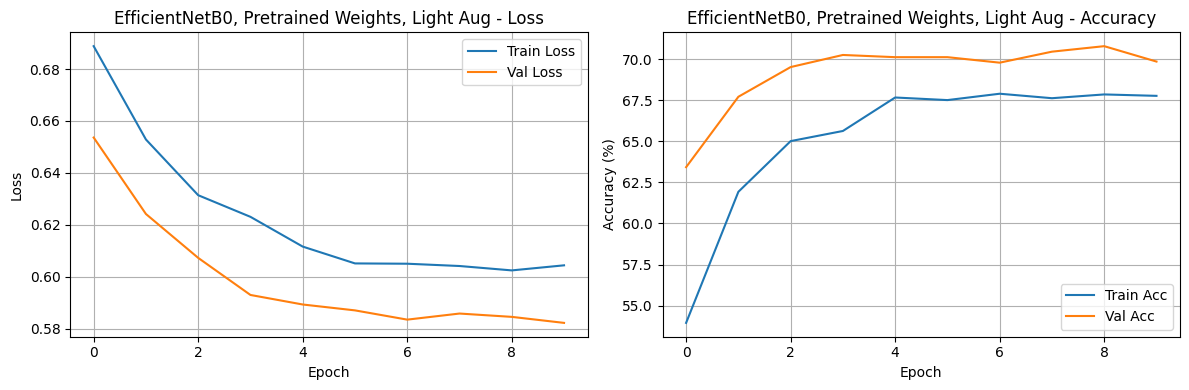

In [129]:
model_pretrained_weights_la = EffNetB0(pretrained=True)
show_training(model_pretrained_weights_la, 'EfficientNetB0, Pretrained Weights, Light Aug')

#### Evaluation


Classification Report for EfficientNetB0, Pretrained Weights, Light Aug':

              precision    recall  f1-score   support

   Non-Toxic       0.70      0.72      0.71       749
       Toxic       0.71      0.69      0.70       744

    accuracy                           0.70      1493
   macro avg       0.70      0.70      0.70      1493
weighted avg       0.70      0.70      0.70      1493



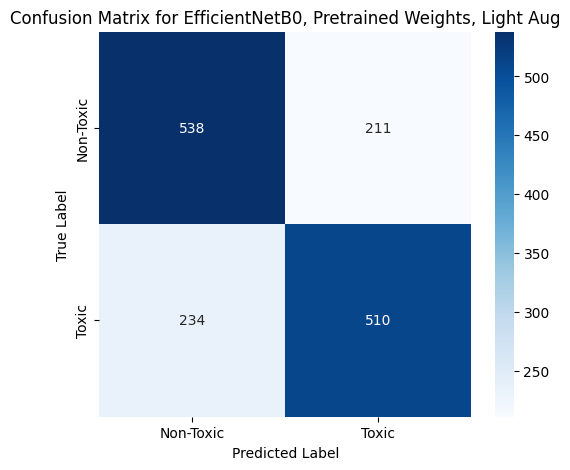

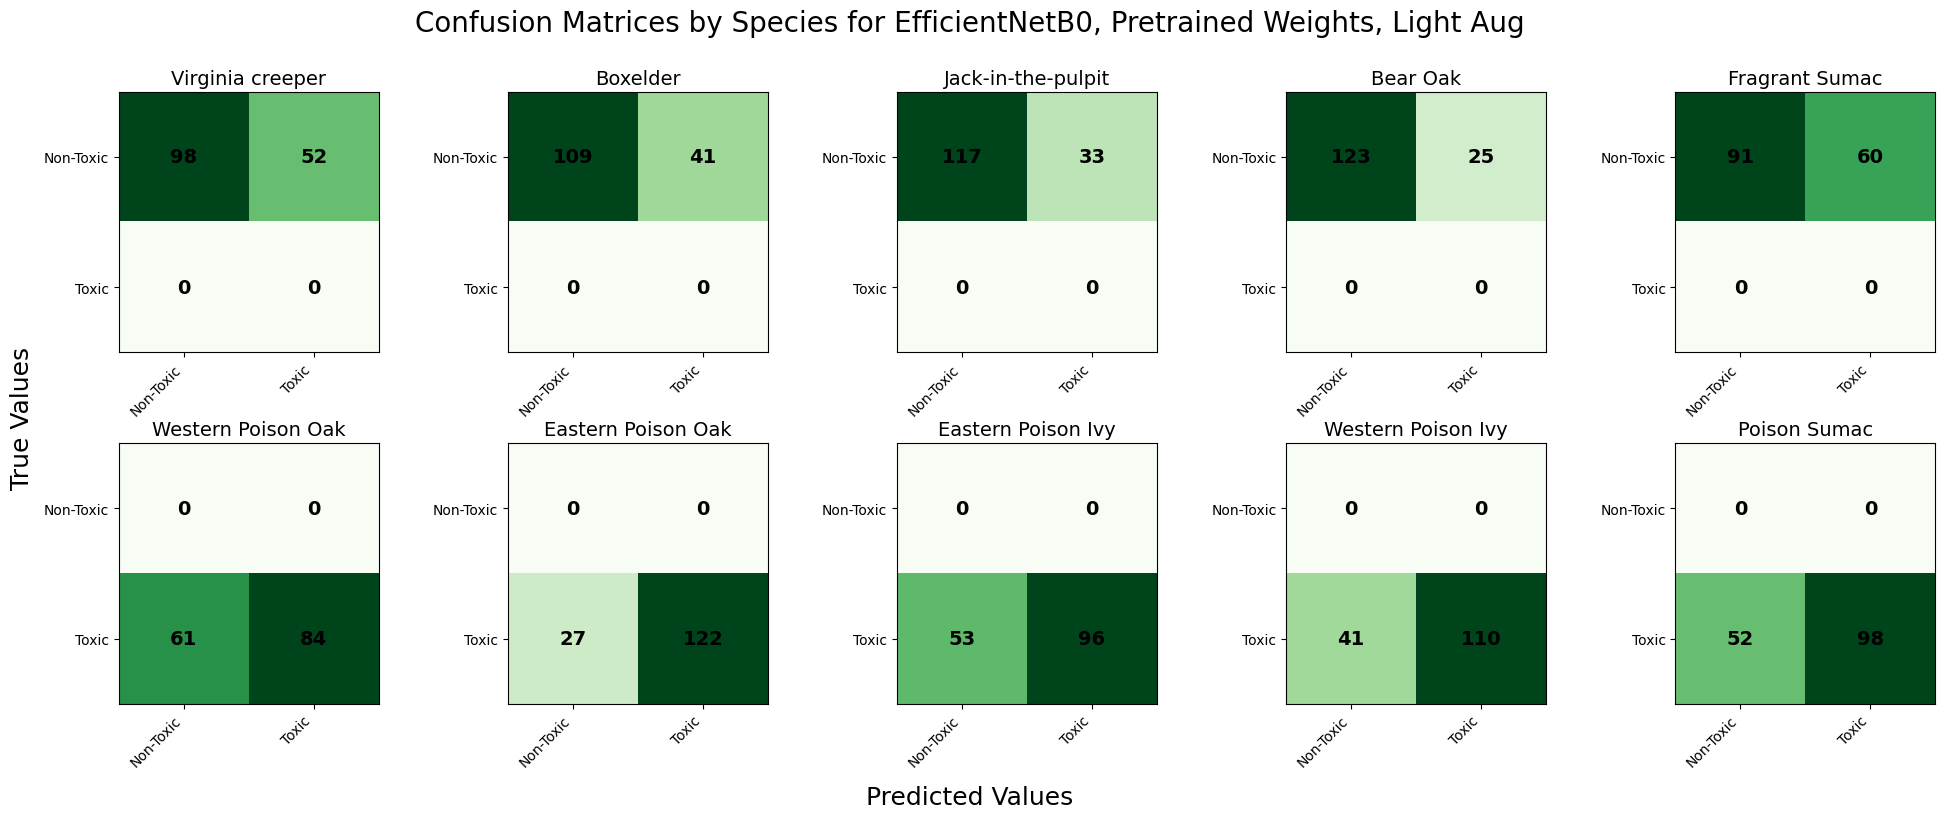

                    False Negative Rate
Western Poison Oak  0.420690           
Eastern Poison Oak  0.181208           
Eastern Poison Ivy  0.355705           
Western Poison Ivy  0.271523           
Poison Sumac        0.346667           


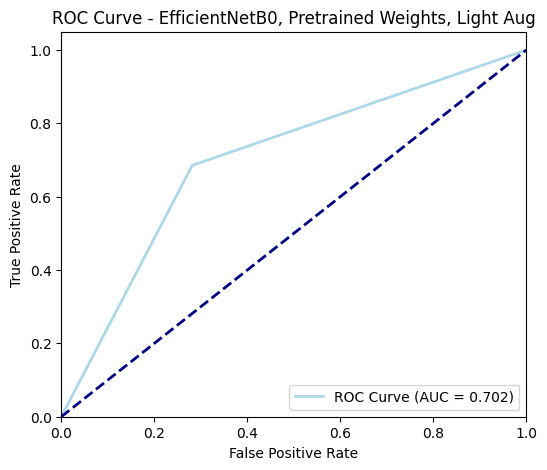

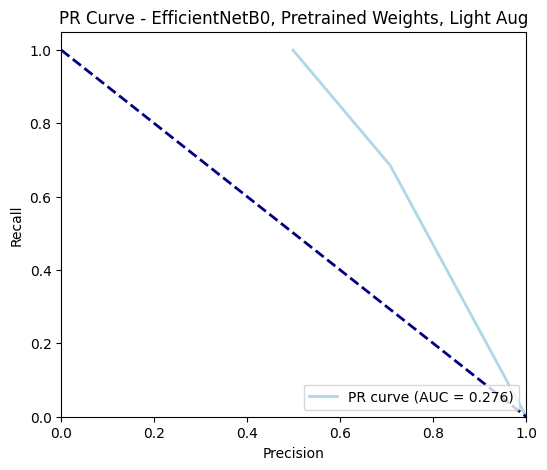

In [130]:
metrics(model_pretrained_weights_la)

### EfficientNetB0 Model, ImageNet Weights, Heavy Augmentation

EfficientNetB0, Pretrained Weights, Heavy Aug0: 4,010,110

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.88it/s]


Train Loss: 0.6942, Train Acc: 52.74%
Val Loss: 0.7106, Val Acc: 59.14%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.20it/s]


Train Loss: 0.6775, Train Acc: 58.43%
Val Loss: 0.6792, Val Acc: 62.29%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.92it/s]


Train Loss: 0.6707, Train Acc: 59.92%
Val Loss: 0.6368, Val Acc: 64.77%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.42it/s]


Train Loss: 0.6633, Train Acc: 61.69%
Val Loss: 0.8075, Val Acc: 65.57%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.95it/s]


Train Loss: 0.6601, Train Acc: 62.65%
Val Loss: 0.6385, Val Acc: 65.84%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.25it/s]


Train Loss: 0.6625, Train Acc: 61.84%
Val Loss: 0.6346, Val Acc: 67.52%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.95it/s]


Train Loss: 0.6557, Train Acc: 63.32%
Val Loss: 0.6466, Val Acc: 66.38%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.51it/s]


Train Loss: 0.6559, Train Acc: 63.71%
Val Loss: 0.6277, Val Acc: 66.31%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.23it/s]


Train Loss: 0.6551, Train Acc: 63.34%
Val Loss: 0.6327, Val Acc: 66.44%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.24it/s]


Train Loss: 0.6571, Train Acc: 63.03%
Val Loss: 0.6328, Val Acc: 65.71%


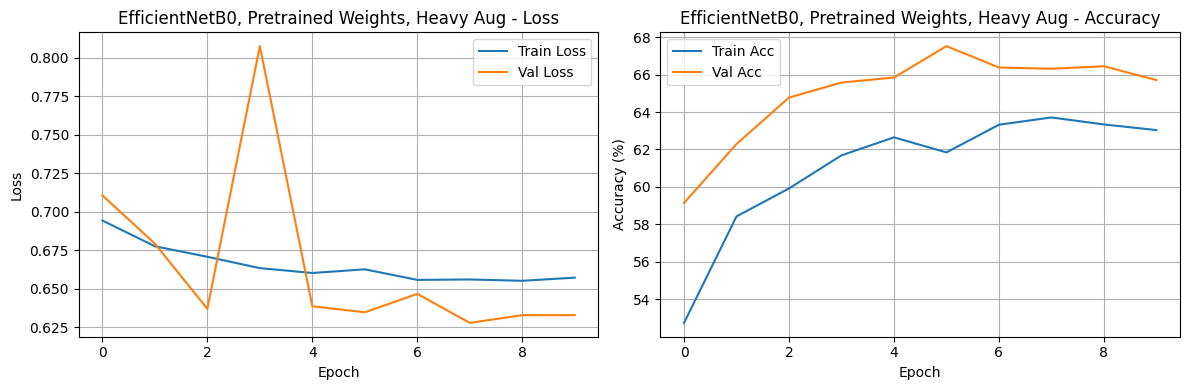

In [131]:
model_pretrained_weights_ha = EffNetB0(pretrained=True)
show_training(model_pretrained_weights_ha, 'EfficientNetB0, Pretrained Weights, Heavy Aug', train_loader = train_strong_loader)

#### Evaluation


Classification Report for EfficientNetB0, Pretrained Weights, Heavy Aug':

              precision    recall  f1-score   support

   Non-Toxic       0.64      0.73      0.68       749
       Toxic       0.68      0.58      0.63       744

    accuracy                           0.66      1493
   macro avg       0.66      0.66      0.65      1493
weighted avg       0.66      0.66      0.65      1493



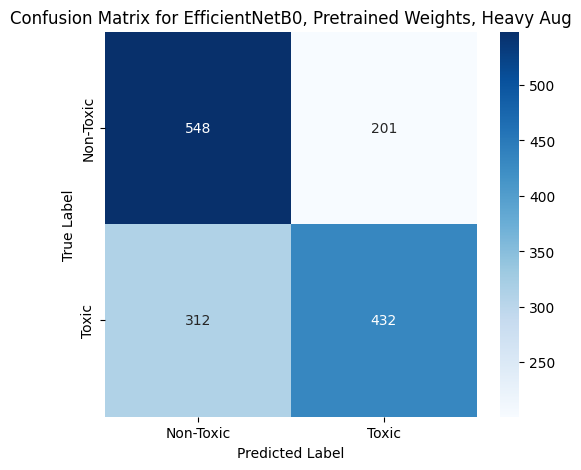

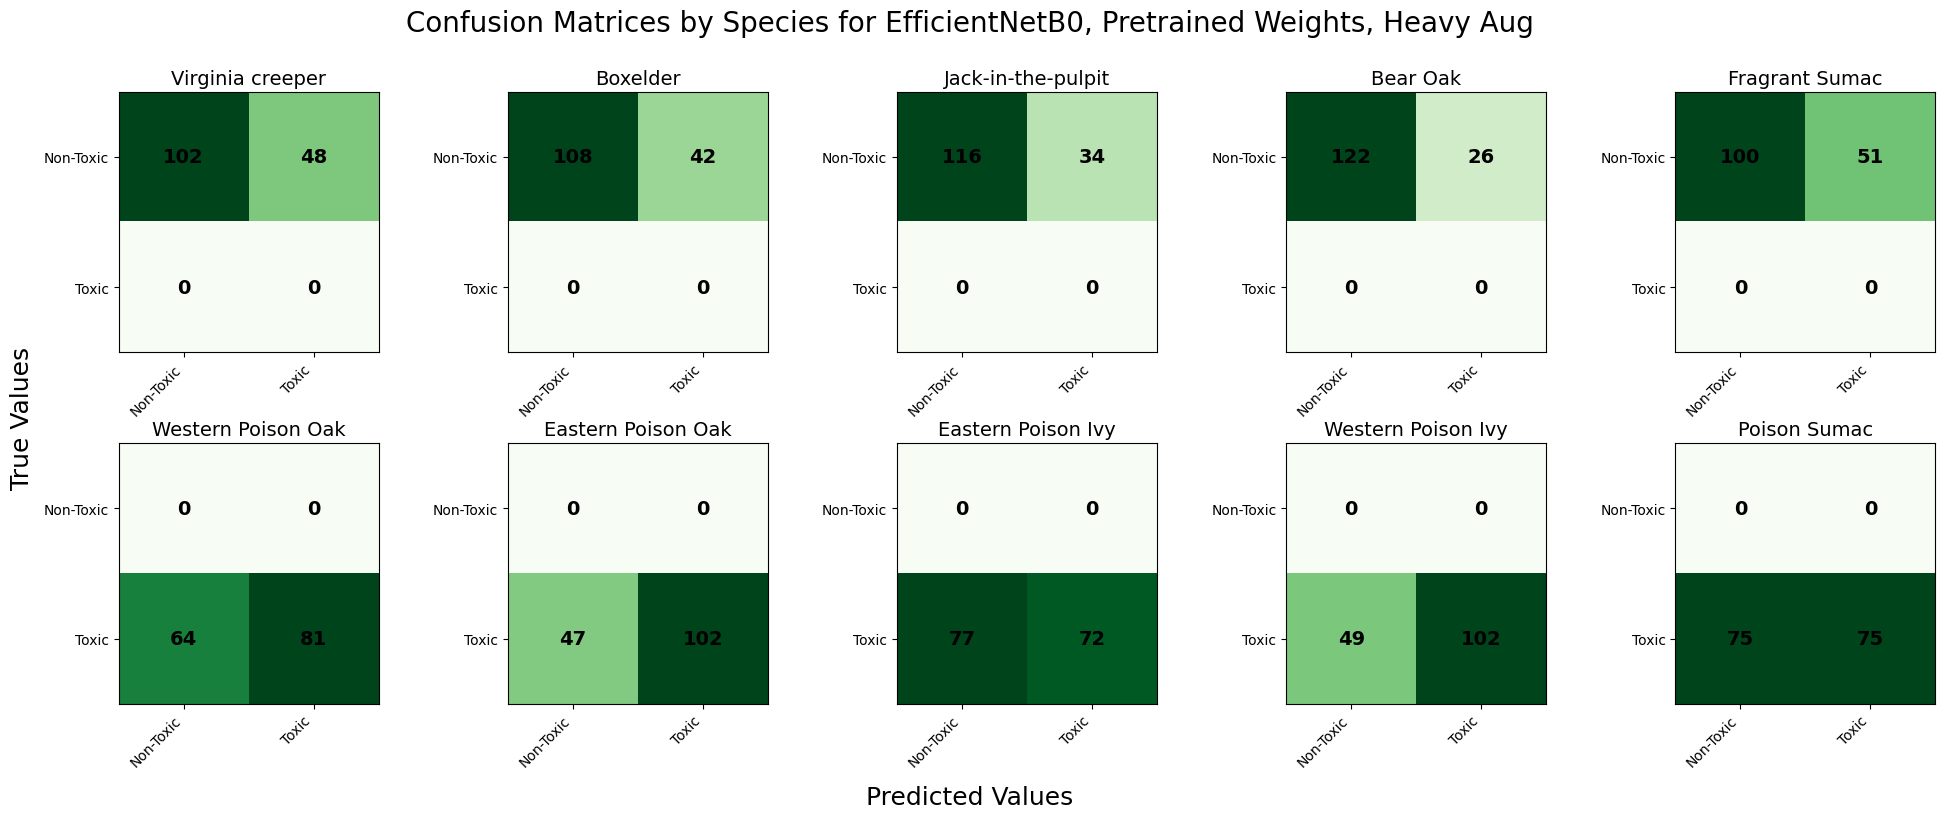

                    False Negative Rate
Western Poison Oak  0.441379           
Eastern Poison Oak  0.315436           
Eastern Poison Ivy  0.516779           
Western Poison Ivy  0.324503           
Poison Sumac        0.500000           


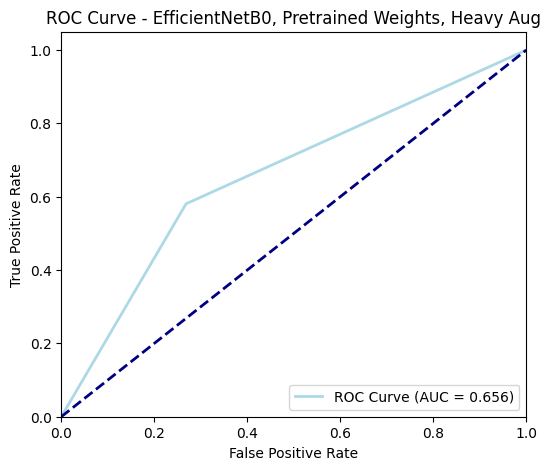

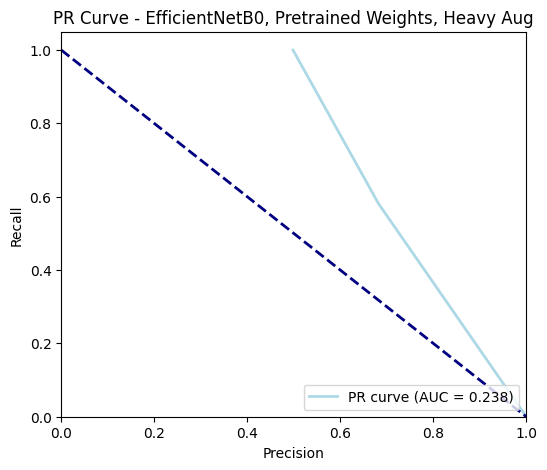

In [132]:
metrics(model_pretrained_weights_ha)

## CBAM (Convolutional Block Attention Module)

Sequential channel attention and spatial attention.

In [133]:
# Channel attention module
class CAM(nn.Module):
  def __init__(self, channels, r):
    super(CAM, self).__init__()
    self.mlp = nn.Sequential(
        nn.Linear(channels, channels // r, bias=False),
        nn.ReLU(inplace=True),
        nn.Linear(channels // r, channels, bias=False)
    )
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    b, c, h, w = x.size()
    avg_pool = F.adaptive_avg_pool2d(x, 1).view(b, c)
    max_pool = F.adaptive_max_pool2d(x, 1).view(b, c)
    attn = self.mlp(avg_pool) + self.mlp(max_pool)
    attn = self.sigmoid(attn).view(b, c, 1, 1)
    return attn * x

# Spatial attention module
class SAM(nn.Module):
  def __init__(self, kernel_size=7, bias=False):
    super(SAM, self).__init__()
    self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=bias)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    avg_out = torch.mean(x, dim=1, keepdim=True)
    max_out, _ = torch.max(x, dim=1, keepdim=True)
    x_cat = torch.cat([avg_out, max_out], dim=1)
    x_out = self.conv(x_cat)
    attn = self.sigmoid(x_out)
    return attn * x

# CBAM
class CBAM(nn.Module):
  def __init__(self, channels, r=16):
    super(CBAM, self).__init__()
    self.channels = channels
    self.r = r
    self.cam = CAM(channels, r)
    self.sam = SAM(bias=False)

  def forward(self, x):
    output = self.cam(x)
    output = self.sam(output)
    return output

In [134]:
# Implement CBAM before last classifier in EfficientNetB0
class EfficientNetB0_CBAM(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(EfficientNetB0_CBAM, self).__init__()
        if pretrained:
            base_model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
        else:
            base_model = models.efficientnet_b0(weights=None)
        
        self.features = base_model.features
        self.cbam = CBAM(channels=1280)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(in_features=1280, out_features=num_classes)
        
    def forward(self, x):
      x = self.features(x)
      x = self.cbam(x)
      x = self.pool(x).flatten(1)
      x = self.dropout(x)
      x = self.classifier(x)
      return x

### EfficientNetB0_CBAM, Random Weights, Light Augmentation

EfficientNetB0_CBAM, Random Meights, Light Aug0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.97it/s]


Train Loss: 0.6934, Train Acc: 50.89%
Val Loss: 0.6901, Val Acc: 51.98%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.44it/s]


Train Loss: 0.6868, Train Acc: 54.38%
Val Loss: 0.6625, Val Acc: 59.41%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.85it/s]


Train Loss: 0.6729, Train Acc: 57.71%
Val Loss: 0.6669, Val Acc: 61.49%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.20it/s]


Train Loss: 0.6463, Train Acc: 62.81%
Val Loss: 0.6518, Val Acc: 61.09%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.97it/s]


Train Loss: 0.5701, Train Acc: 70.41%
Val Loss: 0.7177, Val Acc: 57.94%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.75it/s]


Train Loss: 0.4384, Train Acc: 80.73%
Val Loss: 0.7868, Val Acc: 59.61%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.36it/s]


Train Loss: 0.3708, Train Acc: 84.04%
Val Loss: 0.8429, Val Acc: 59.95%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.11it/s]


Train Loss: 0.3388, Train Acc: 84.80%
Val Loss: 0.9154, Val Acc: 59.21%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.46it/s]


Train Loss: 0.3036, Train Acc: 86.58%
Val Loss: 0.9899, Val Acc: 58.94%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.64it/s]


Train Loss: 0.2940, Train Acc: 87.15%
Val Loss: 1.0221, Val Acc: 58.67%


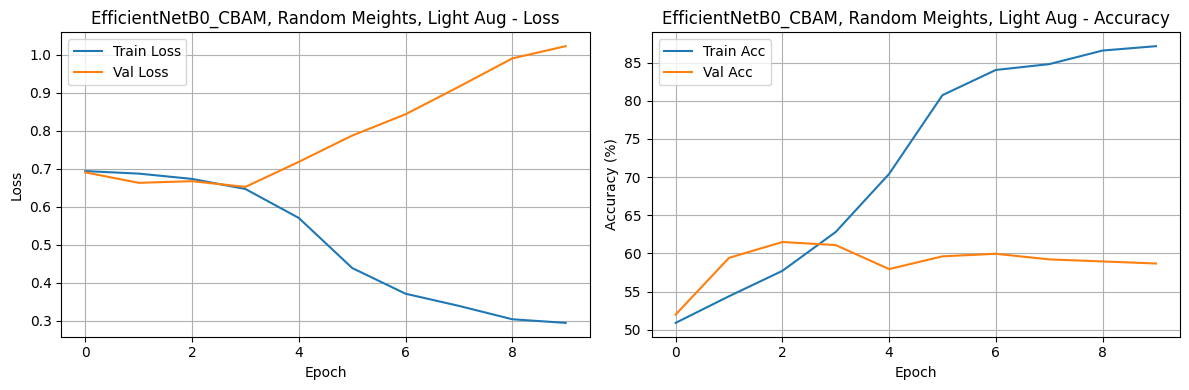

In [135]:
model_cbam_random_la = EfficientNetB0_CBAM(num_classes=2, pretrained=False)
show_training(model_cbam_random_la, 'EfficientNetB0_CBAM, Random Meights, Light Aug')

#### Evaluation


Classification Report for EfficientNetB0_CBAM, Random Weights, Light Aug':

              precision    recall  f1-score   support

   Non-Toxic       0.53      0.51      0.52       749
       Toxic       0.53      0.55      0.54       744

    accuracy                           0.53      1493
   macro avg       0.53      0.53      0.53      1493
weighted avg       0.53      0.53      0.53      1493



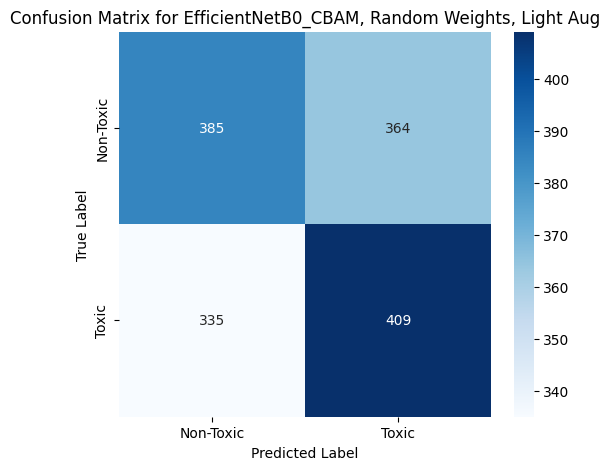

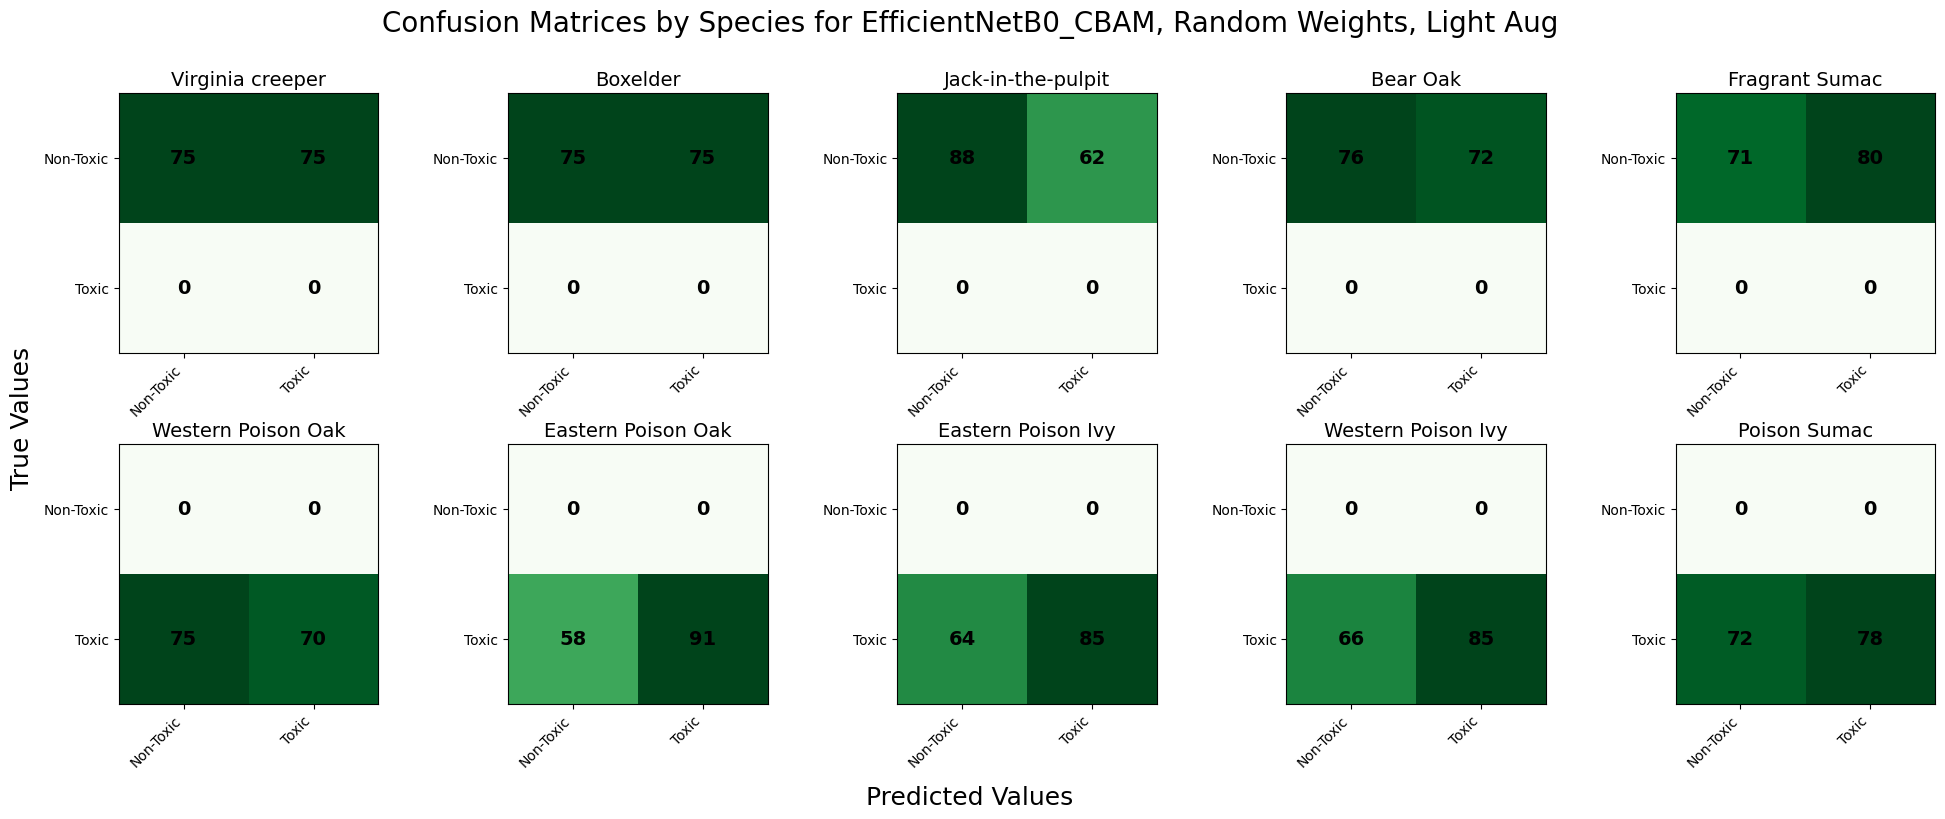

                    False Negative Rate
Western Poison Oak  0.517241           
Eastern Poison Oak  0.389262           
Eastern Poison Ivy  0.429530           
Western Poison Ivy  0.437086           
Poison Sumac        0.480000           


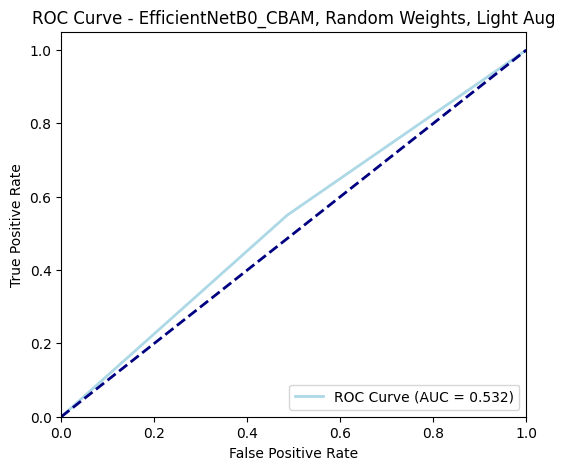

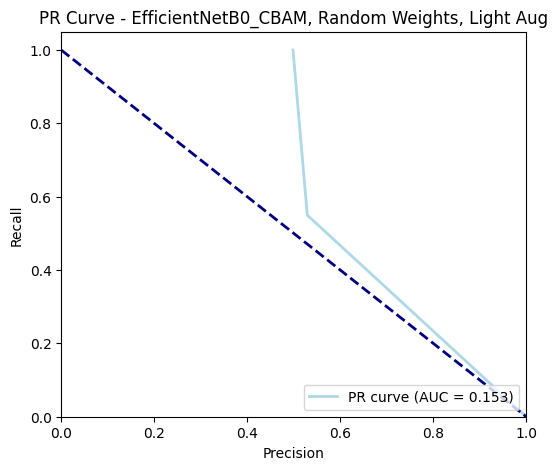

In [136]:
metrics(model_cbam_random_la)

### EfficientNetB0_CBAM, Random Weights, Heavy Augmentation

EfficientNetB0_CBAM, Random Weights, Heavy Aug0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.74it/s]


Train Loss: 0.6928, Train Acc: 52.71%
Val Loss: 0.7478, Val Acc: 55.26%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.32it/s]


Train Loss: 0.6901, Train Acc: 53.70%
Val Loss: 0.7980, Val Acc: 56.60%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.69it/s]


Train Loss: 0.6855, Train Acc: 55.86%
Val Loss: 0.6753, Val Acc: 57.74%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.41it/s]


Train Loss: 0.6829, Train Acc: 57.44%
Val Loss: 0.6699, Val Acc: 59.88%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.83it/s]


Train Loss: 0.6789, Train Acc: 57.65%
Val Loss: 0.6711, Val Acc: 60.82%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.93it/s]


Train Loss: 0.6663, Train Acc: 61.14%
Val Loss: 0.6604, Val Acc: 60.88%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.84it/s]


Train Loss: 0.6668, Train Acc: 61.48%
Val Loss: 0.6697, Val Acc: 59.68%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.59it/s]


Train Loss: 0.6609, Train Acc: 62.23%
Val Loss: 0.6721, Val Acc: 60.55%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.02it/s]


Train Loss: 0.6578, Train Acc: 62.55%
Val Loss: 0.6613, Val Acc: 60.08%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.00it/s]


Train Loss: 0.6583, Train Acc: 62.68%
Val Loss: 0.6641, Val Acc: 60.95%


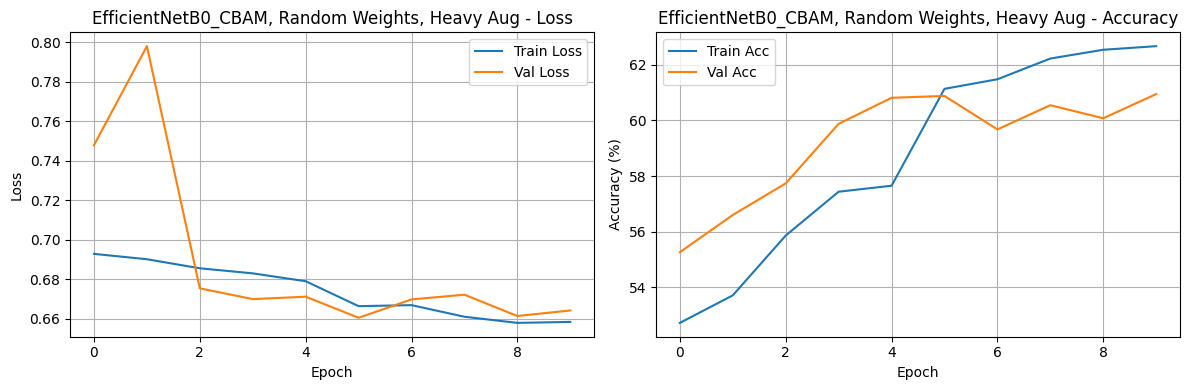

In [137]:
model_cbam_random_ha = EfficientNetB0_CBAM(num_classes=2, pretrained=False)
show_training(model_cbam_random_ha, 'EfficientNetB0_CBAM, Random Weights, Heavy Aug', train_loader = train_strong_loader)

#### Evaluation


Classification Report for EfficientNetB0_CBAM, Random Weights, Heavy Aug':

              precision    recall  f1-score   support

   Non-Toxic       0.58      0.51      0.54       749
       Toxic       0.56      0.63      0.59       744

    accuracy                           0.57      1493
   macro avg       0.57      0.57      0.57      1493
weighted avg       0.57      0.57      0.57      1493



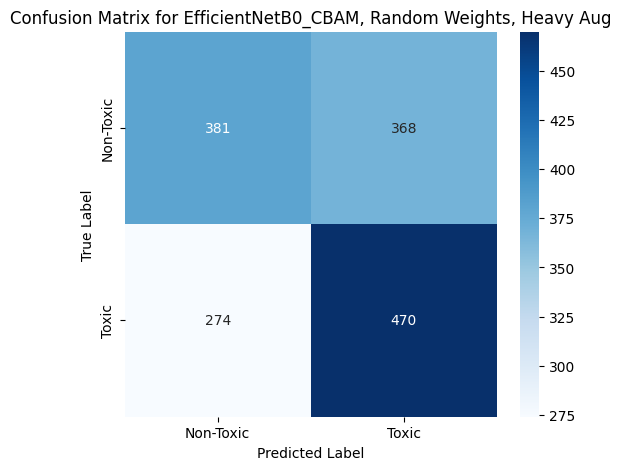

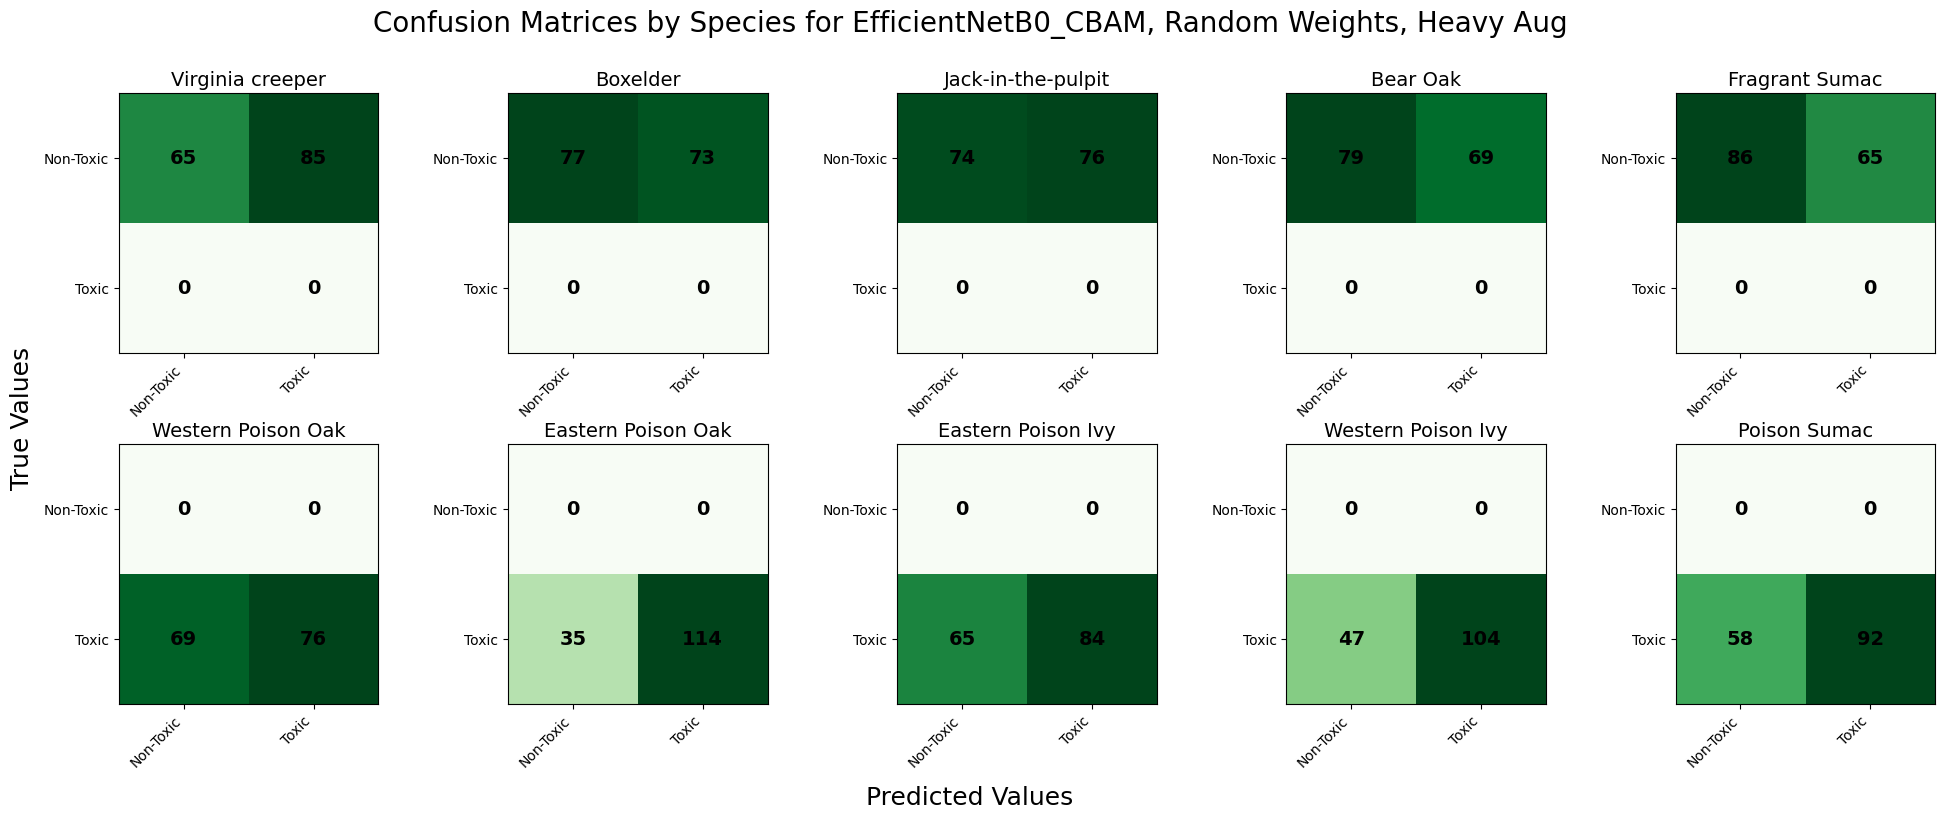

                    False Negative Rate
Western Poison Oak  0.475862           
Eastern Poison Oak  0.234899           
Eastern Poison Ivy  0.436242           
Western Poison Ivy  0.311258           
Poison Sumac        0.386667           


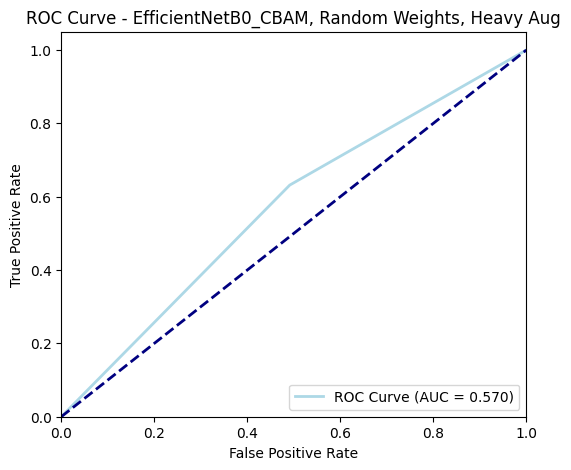

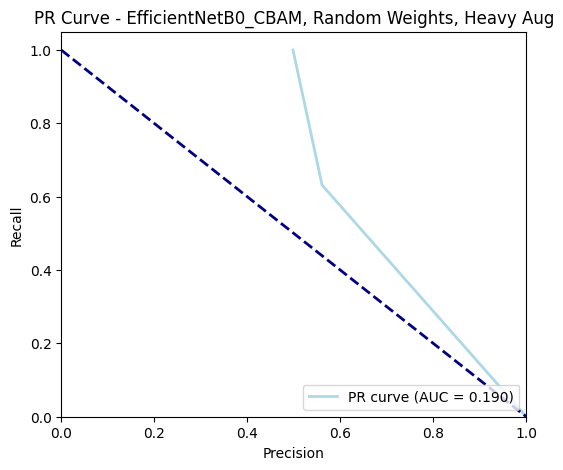

In [138]:
metrics(model_cbam_random_ha)

### EfficientNetB0_CBAM, ImageNet Weights, Light Augmentation

EfficientNetB0_CBAM, Pretrained Weights, Light Aug0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.40it/s]


Train Loss: 0.5606, Train Acc: 70.01%
Val Loss: 0.4063, Val Acc: 81.18%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.30it/s]


Train Loss: 0.3390, Train Acc: 84.61%
Val Loss: 0.3481, Val Acc: 82.99%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.64it/s]


Train Loss: 0.2092, Train Acc: 91.33%
Val Loss: 0.3566, Val Acc: 84.06%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.38it/s]


Train Loss: 0.1379, Train Acc: 94.39%
Val Loss: 0.4181, Val Acc: 84.53%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.62it/s]


Train Loss: 0.1037, Train Acc: 96.10%
Val Loss: 0.4090, Val Acc: 85.93%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.36it/s]


Train Loss: 0.0694, Train Acc: 97.60%
Val Loss: 0.4132, Val Acc: 85.67%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.69it/s]


Train Loss: 0.0565, Train Acc: 98.02%
Val Loss: 0.4131, Val Acc: 86.14%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.54it/s]


Train Loss: 0.0493, Train Acc: 98.42%
Val Loss: 0.4120, Val Acc: 86.40%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.68it/s]


Train Loss: 0.0496, Train Acc: 98.36%
Val Loss: 0.4395, Val Acc: 85.73%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.64it/s]


Train Loss: 0.0488, Train Acc: 98.51%
Val Loss: 0.4257, Val Acc: 86.40%


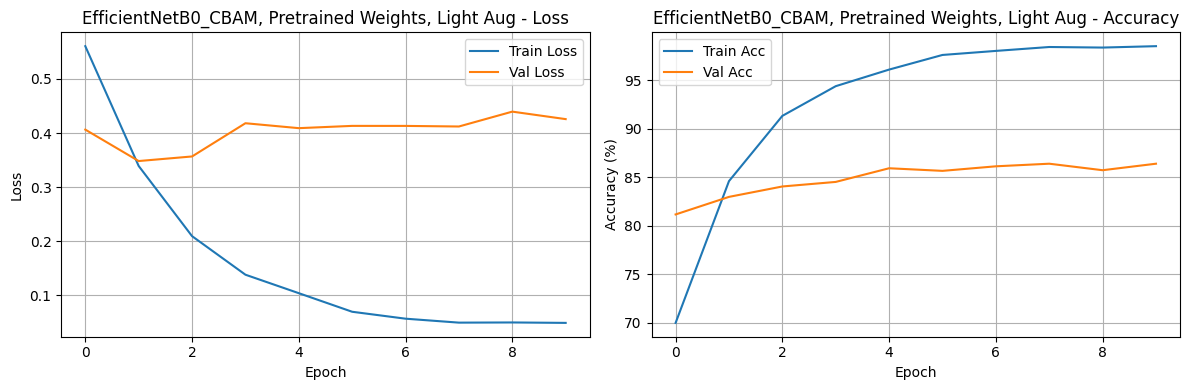

In [139]:
model_cbam_pretrained_la = EfficientNetB0_CBAM(num_classes=2, pretrained=True)
show_training(model_cbam_pretrained_la, 'EfficientNetB0_CBAM, Pretrained Weights, Light Aug')

#### Evaluation


Classification Report for EfficientNetB0_CBAM, Pretrained Weights, Light Aug':

              precision    recall  f1-score   support

   Non-Toxic       0.84      0.87      0.85       749
       Toxic       0.86      0.84      0.85       744

    accuracy                           0.85      1493
   macro avg       0.85      0.85      0.85      1493
weighted avg       0.85      0.85      0.85      1493



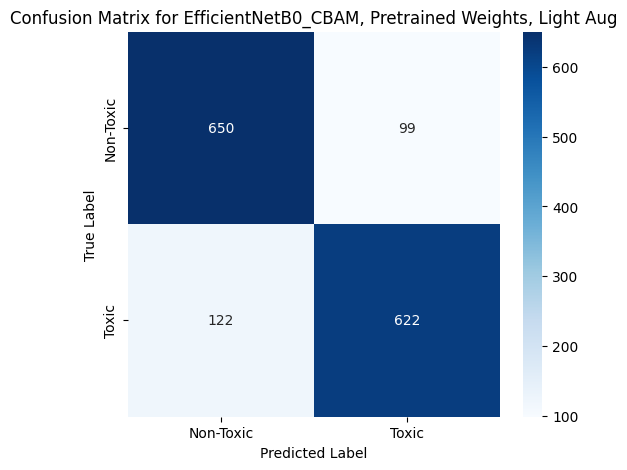

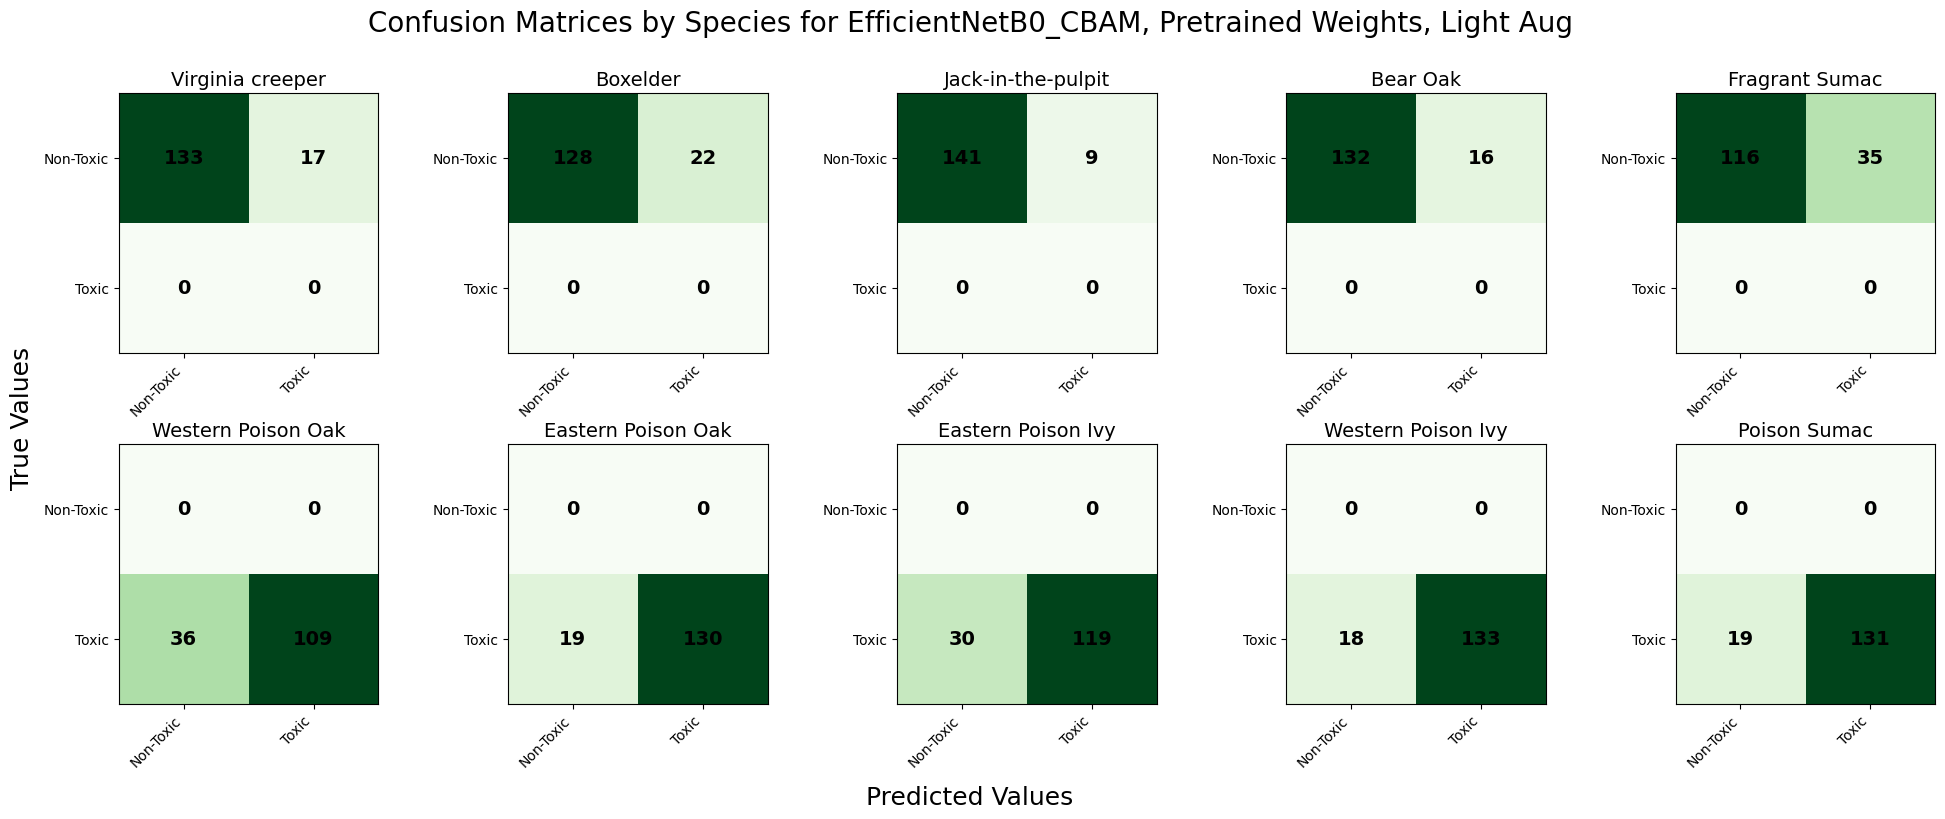

                    False Negative Rate
Western Poison Oak  0.248276           
Eastern Poison Oak  0.127517           
Eastern Poison Ivy  0.201342           
Western Poison Ivy  0.119205           
Poison Sumac        0.126667           


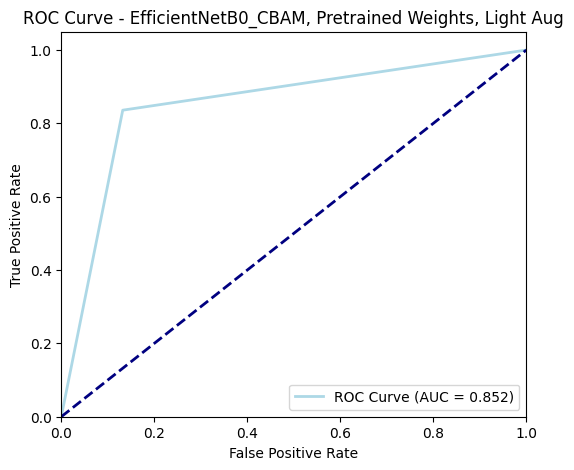

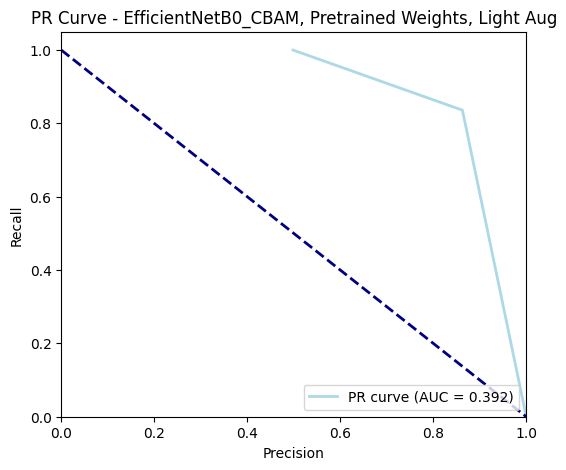

In [140]:
metrics(model_cbam_pretrained_la)

### EfficientNetB0_CBAM, ImageNet Weights, Heavy Augmentation

EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.63it/s]


Train Loss: 0.6568, Train Acc: 62.09%
Val Loss: 0.5132, Val Acc: 76.36%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.14it/s]


Train Loss: 0.5851, Train Acc: 73.82%
Val Loss: 0.4533, Val Acc: 80.31%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.88it/s]


Train Loss: 0.5454, Train Acc: 77.85%
Val Loss: 0.4341, Val Acc: 81.04%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.77it/s]


Train Loss: 0.5162, Train Acc: 81.29%
Val Loss: 0.4046, Val Acc: 83.26%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.32it/s]


Train Loss: 0.5103, Train Acc: 82.40%
Val Loss: 0.4082, Val Acc: 83.26%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.96it/s]


Train Loss: 0.4953, Train Acc: 84.68%
Val Loss: 0.3853, Val Acc: 84.39%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.18it/s]


Train Loss: 0.4721, Train Acc: 86.03%
Val Loss: 0.3831, Val Acc: 84.86%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.94it/s]


Train Loss: 0.4737, Train Acc: 85.53%
Val Loss: 0.3556, Val Acc: 85.40%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.94it/s]


Train Loss: 0.4697, Train Acc: 85.79%
Val Loss: 0.3699, Val Acc: 84.66%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.91it/s]


Train Loss: 0.4692, Train Acc: 86.12%
Val Loss: 0.3722, Val Acc: 84.66%


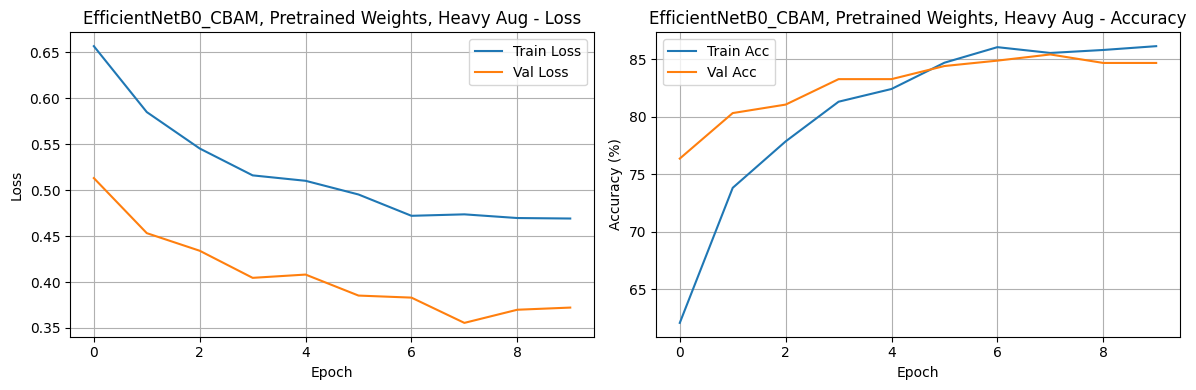

In [141]:
model_cbam_pretrained_ha = EfficientNetB0_CBAM(num_classes=2, pretrained=True)
show_training(model_cbam_pretrained_ha, 'EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug', train_loader=train_strong_loader)

### Evaluation


Classification Report for EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug':

              precision    recall  f1-score   support

   Non-Toxic       0.82      0.85      0.83       749
       Toxic       0.84      0.81      0.83       744

    accuracy                           0.83      1493
   macro avg       0.83      0.83      0.83      1493
weighted avg       0.83      0.83      0.83      1493



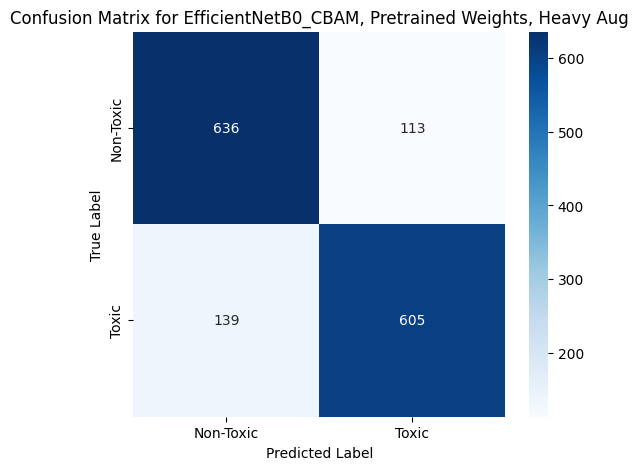

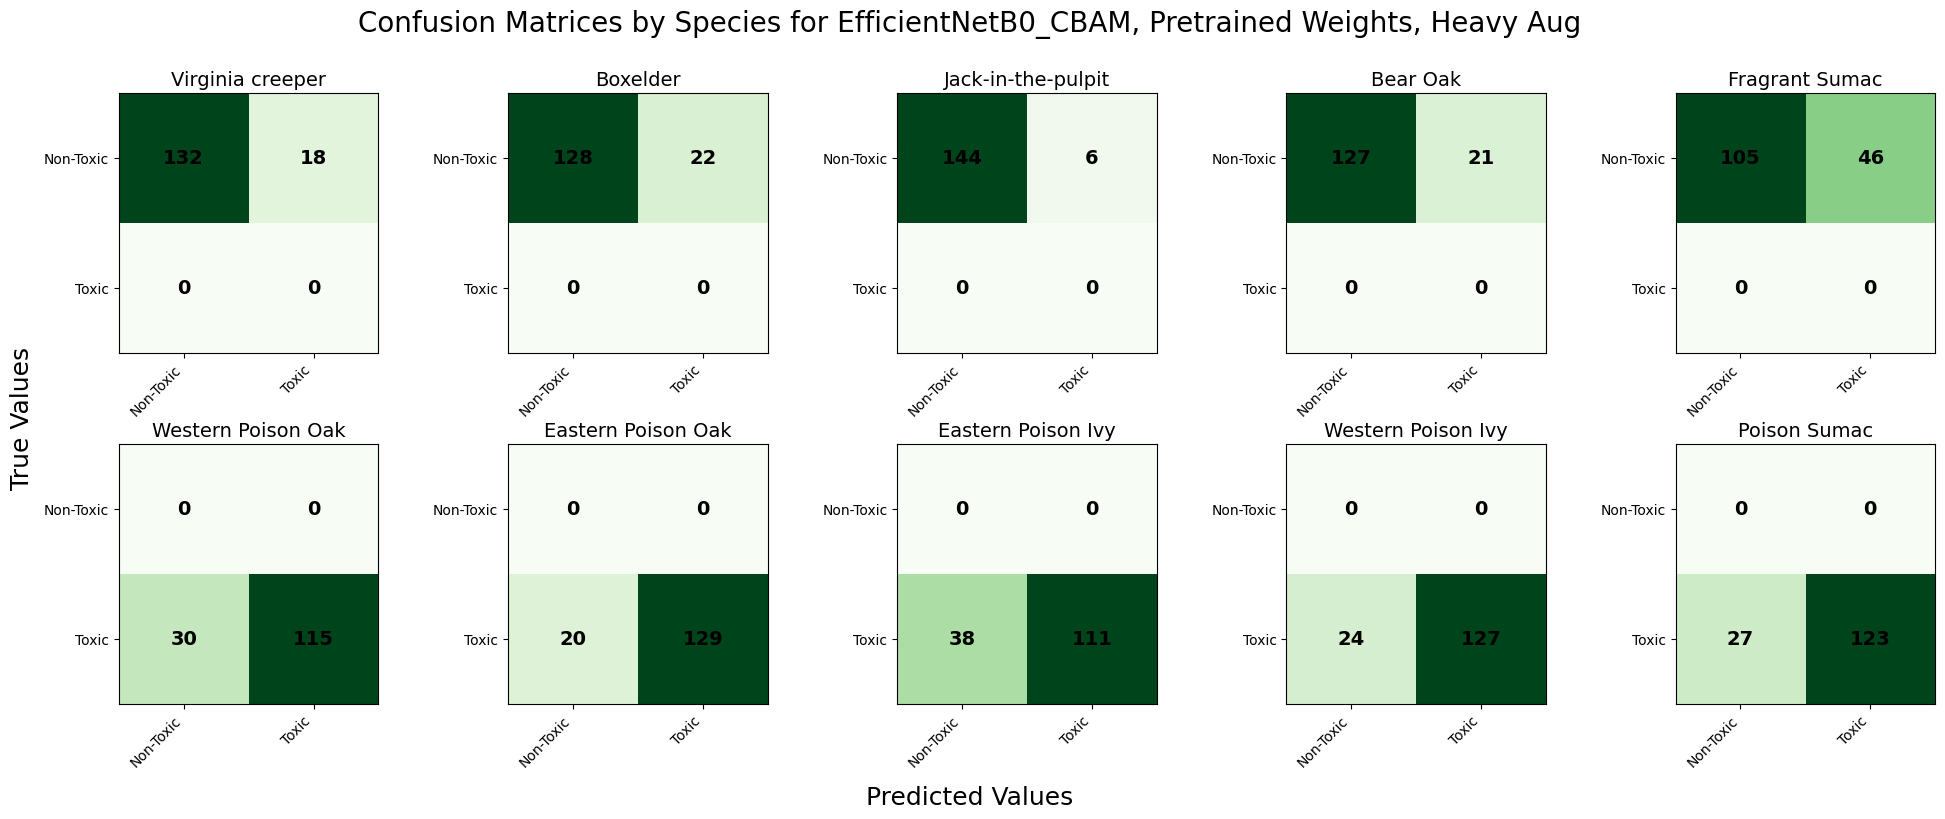

                    False Negative Rate
Western Poison Oak  0.206897           
Eastern Poison Oak  0.134228           
Eastern Poison Ivy  0.255034           
Western Poison Ivy  0.158940           
Poison Sumac        0.180000           


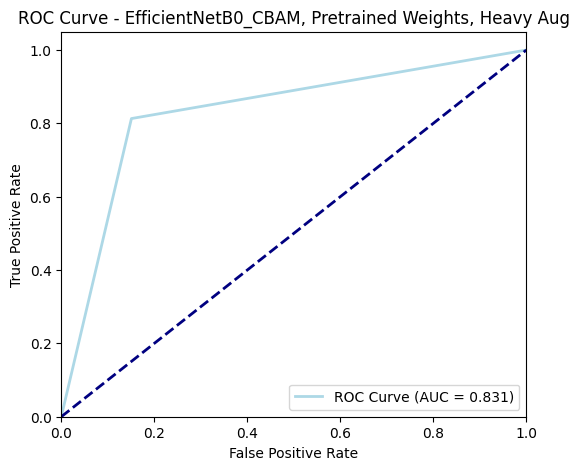

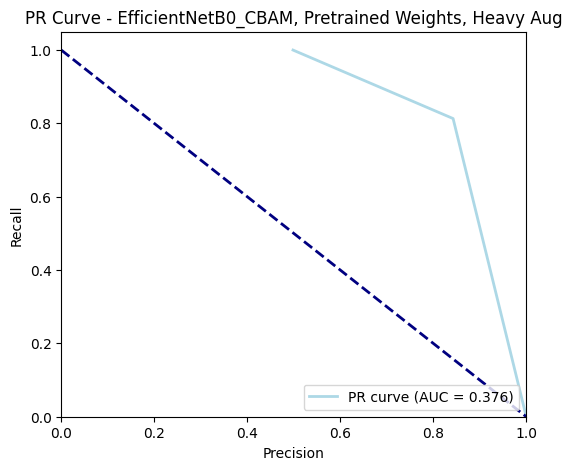

In [142]:
metrics(model_cbam_pretrained_ha)

### EfficientNetB2_CBAM, ImageNet Weights, Light Augmentation

In [143]:
# Implement CBAM before last classifier in EfficientNetB2
class EfficientNetB2_CBAM(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(EfficientNetB2_CBAM, self).__init__()
        if pretrained:
            base_model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
        else:
            base_model = models.efficientnet_b2(weights=None)
        
        self.features = base_model.features
        self.cbam = CBAM(channels=1408)  # B2 has 1408 channels
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(in_features=1408, out_features=num_classes)
        
    def forward(self, x):
      x = self.features(x)
      x = self.cbam(x)
      x = self.pool(x).flatten(1)
      x = self.dropout(x)
      x = self.classifier(x)
      return x

In [144]:
def EffNetB2_CBAM(pretrained=True):
    """Wrapper for compatibility with existing code"""
    model = EfficientNetB2_CBAM(num_classes=2, pretrained=pretrained)
    model = model.to(device)
    return model

EfficientNetB2_CBAM, Pretrained Weights, Light Aug0: 7,951,718

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.74it/s]


Train Loss: 0.5386, Train Acc: 72.11%
Val Loss: 0.3764, Val Acc: 81.92%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.18it/s]


Train Loss: 0.2930, Train Acc: 86.69%
Val Loss: 0.3494, Val Acc: 83.26%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.58it/s]


Train Loss: 0.1674, Train Acc: 93.44%
Val Loss: 0.3501, Val Acc: 85.20%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.66it/s]


Train Loss: 0.0969, Train Acc: 96.51%
Val Loss: 0.4186, Val Acc: 85.20%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.71it/s]


Train Loss: 0.0751, Train Acc: 97.06%
Val Loss: 0.4673, Val Acc: 84.80%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.00it/s]


Train Loss: 0.0485, Train Acc: 98.51%
Val Loss: 0.4185, Val Acc: 85.73%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.09it/s]


Train Loss: 0.0428, Train Acc: 98.69%
Val Loss: 0.4078, Val Acc: 86.14%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.79it/s]


Train Loss: 0.0394, Train Acc: 98.78%
Val Loss: 0.4038, Val Acc: 87.07%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.21it/s]


Train Loss: 0.0299, Train Acc: 99.02%
Val Loss: 0.4084, Val Acc: 86.27%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.97it/s]


Train Loss: 0.0294, Train Acc: 99.10%
Val Loss: 0.4260, Val Acc: 85.53%


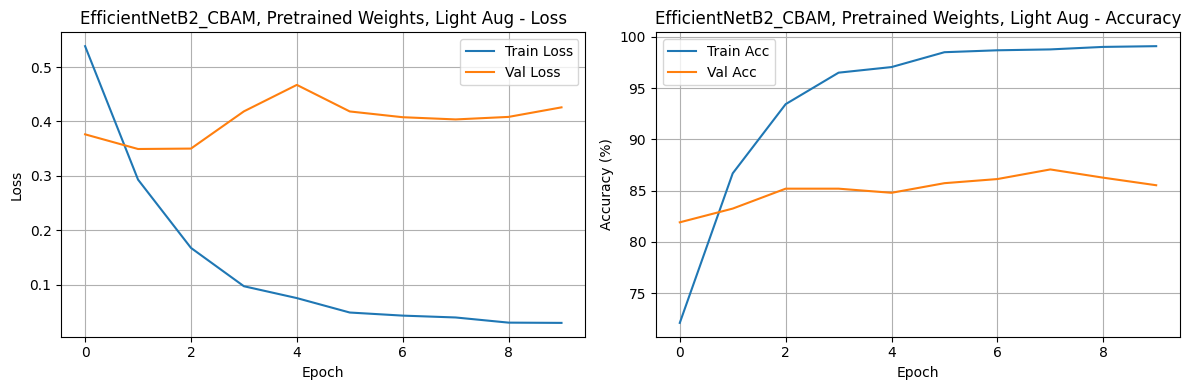

In [145]:
model_cbam_pretrained_la_02 = EfficientNetB2_CBAM(num_classes=2, pretrained=True)
show_training(model_cbam_pretrained_la_02, 'EfficientNetB2_CBAM, Pretrained Weights, Light Aug')

### Evaluation


Classification Report for EfficientNetB2_CBAM, Pretrained Weights, Light Aug':

              precision    recall  f1-score   support

   Non-Toxic       0.85      0.91      0.88       749
       Toxic       0.90      0.84      0.87       744

    accuracy                           0.87      1493
   macro avg       0.88      0.87      0.87      1493
weighted avg       0.88      0.87      0.87      1493



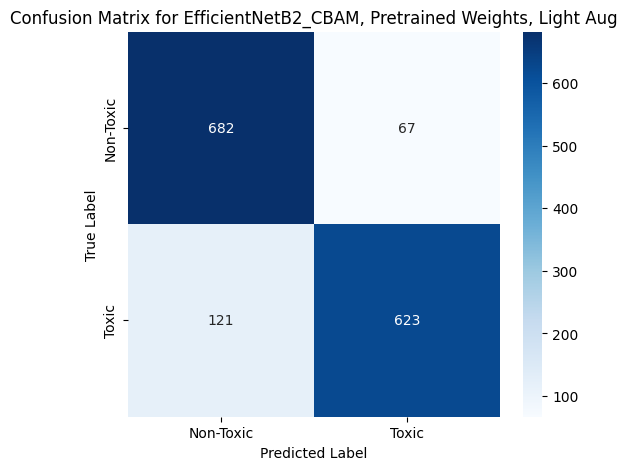

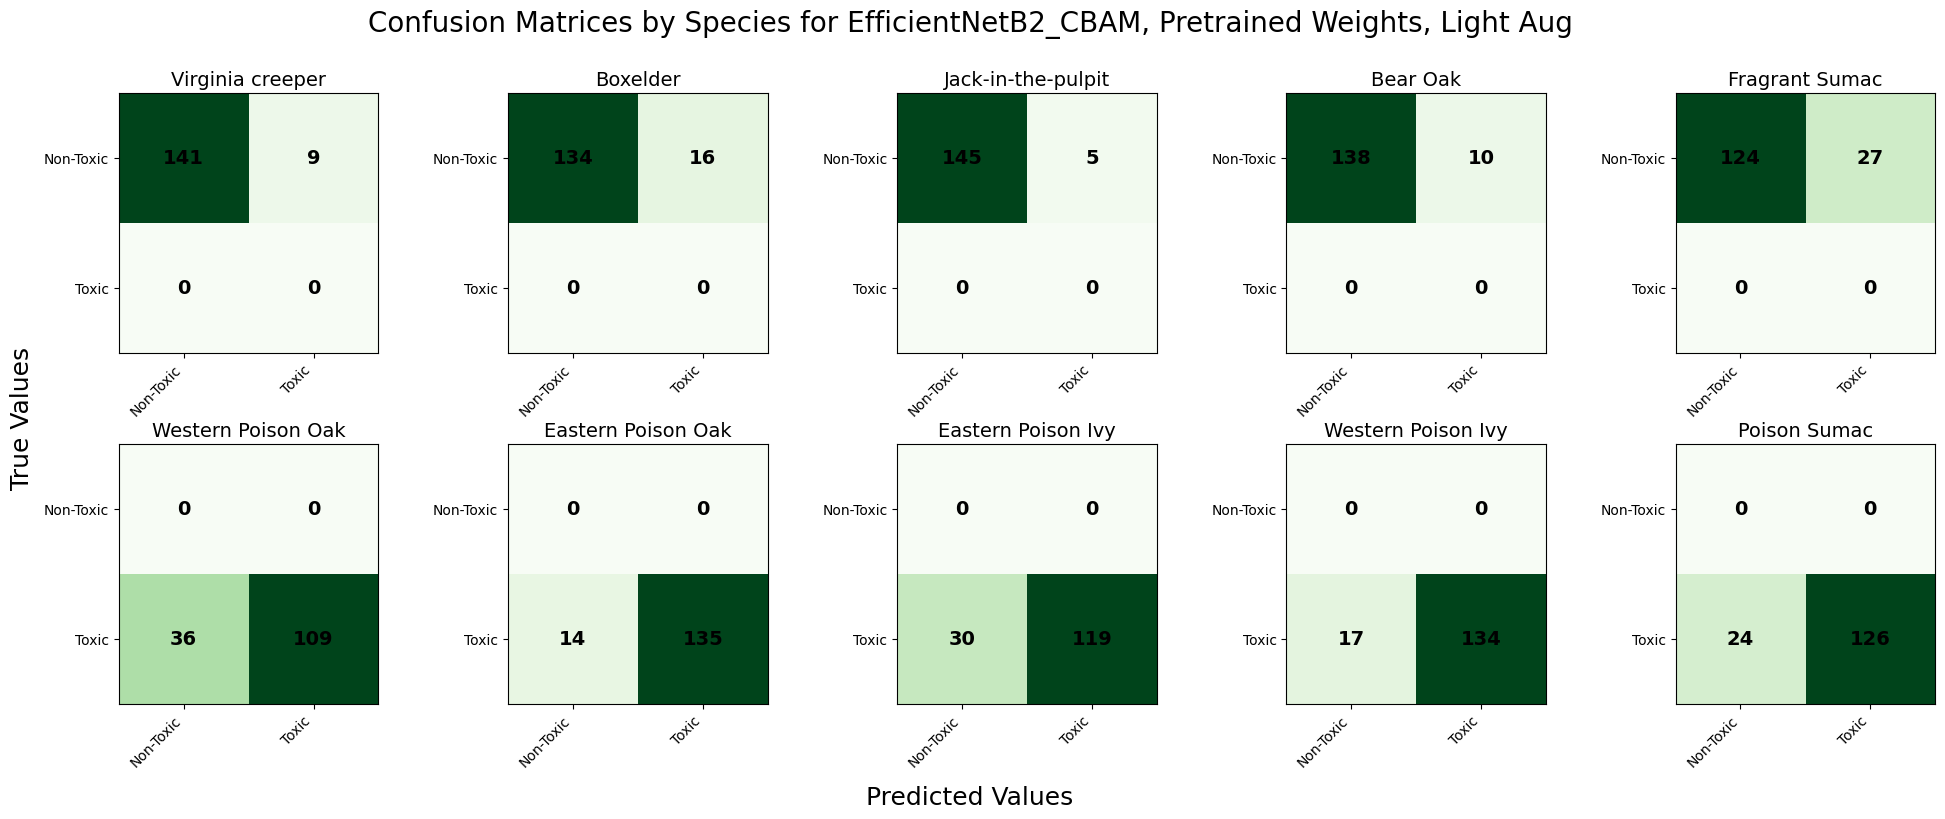

                    False Negative Rate
Western Poison Oak  0.248276           
Eastern Poison Oak  0.093960           
Eastern Poison Ivy  0.201342           
Western Poison Ivy  0.112583           
Poison Sumac        0.160000           


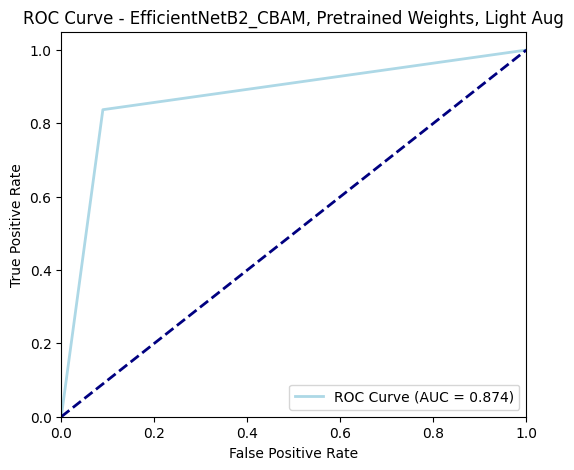

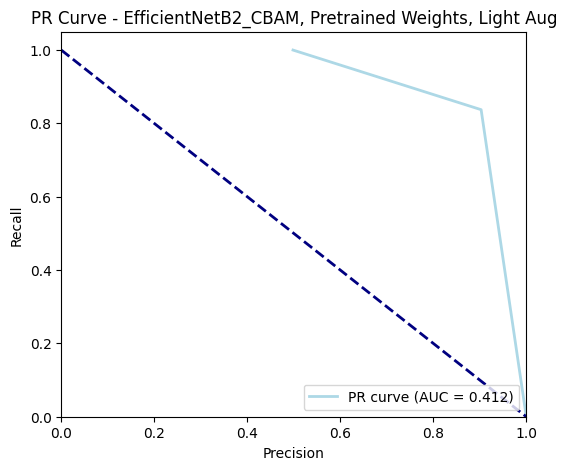

In [147]:
metrics(model_cbam_pretrained_la_02)

### EfficientNetB2_CBAM, ImageNet Weights, Heavy Augmentation

EfficientNetB2_CBAM, Pretrained Weights, Heavy Augmemtation0: 7,951,718

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.95it/s]


Train Loss: 0.6363, Train Acc: 64.69%
Val Loss: 0.5051, Val Acc: 74.82%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.93it/s]


Train Loss: 0.5727, Train Acc: 74.66%
Val Loss: 0.4435, Val Acc: 80.51%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.57it/s]


Train Loss: 0.5279, Train Acc: 79.90%
Val Loss: 0.3878, Val Acc: 82.85%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.62it/s]


Train Loss: 0.5089, Train Acc: 82.01%
Val Loss: 0.3559, Val Acc: 85.06%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.63it/s]


Train Loss: 0.4863, Train Acc: 84.24%
Val Loss: 0.3799, Val Acc: 84.06%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.48it/s]


Train Loss: 0.4707, Train Acc: 85.83%
Val Loss: 0.3668, Val Acc: 83.99%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.21it/s]


Train Loss: 0.4600, Train Acc: 86.41%
Val Loss: 0.3553, Val Acc: 84.86%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.51it/s]


Train Loss: 0.4527, Train Acc: 87.90%
Val Loss: 0.3607, Val Acc: 84.53%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.03it/s]


Train Loss: 0.4422, Train Acc: 87.68%
Val Loss: 0.3585, Val Acc: 84.53%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.79it/s]


Train Loss: 0.4187, Train Acc: 89.41%
Val Loss: 0.3376, Val Acc: 85.73%


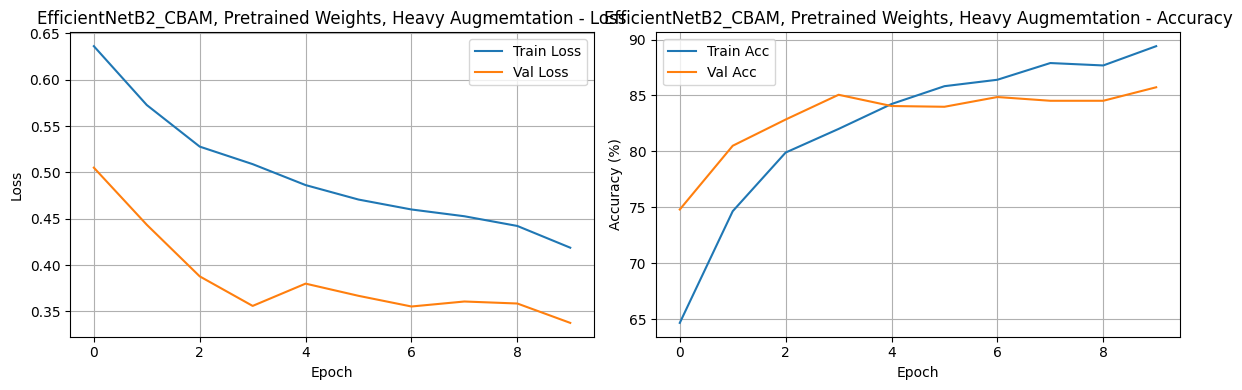

In [148]:
model_cbam_pretrained_ha_02 = EfficientNetB2_CBAM(num_classes=2, pretrained=True)
show_training(model_cbam_pretrained_ha_02, 'EfficientNetB2_CBAM, Pretrained Weights, Heavy Augmemtation', train_loader=train_strong_loader)

### Evaluation


Classification Report for EfficientNetB2_CBAM, Pretrained Weights, Heavy Aug':

              precision    recall  f1-score   support

   Non-Toxic       0.86      0.87      0.87       749
       Toxic       0.87      0.86      0.87       744

    accuracy                           0.87      1493
   macro avg       0.87      0.87      0.87      1493
weighted avg       0.87      0.87      0.87      1493



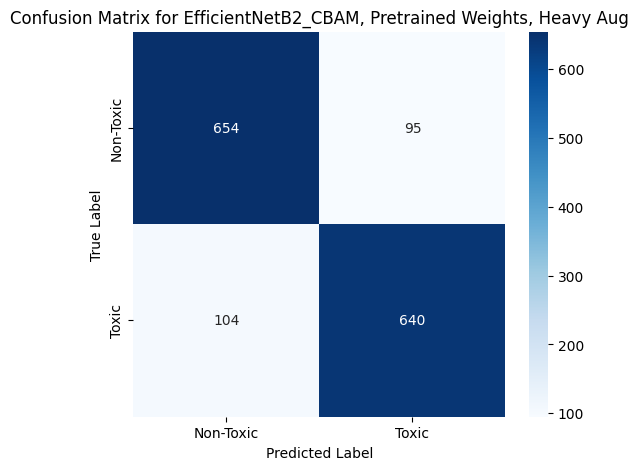

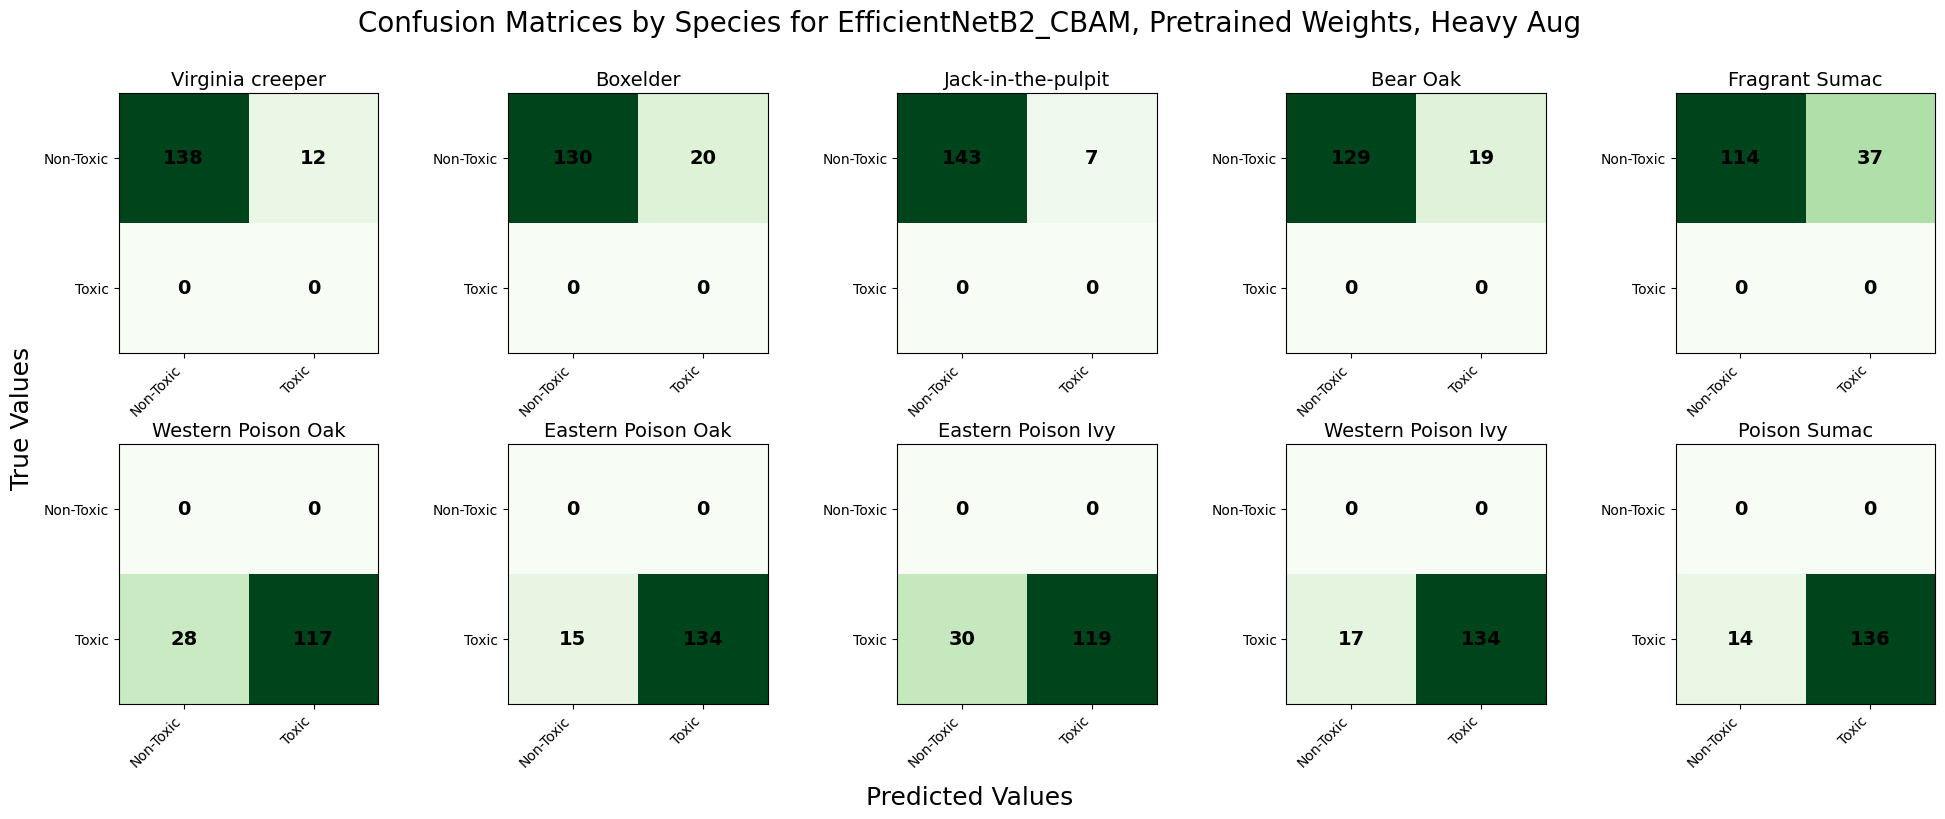

                    False Negative Rate
Western Poison Oak  0.193103           
Eastern Poison Oak  0.100671           
Eastern Poison Ivy  0.201342           
Western Poison Ivy  0.112583           
Poison Sumac        0.093333           


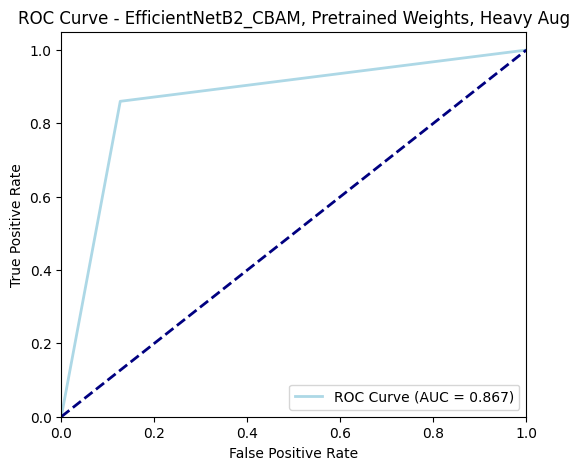

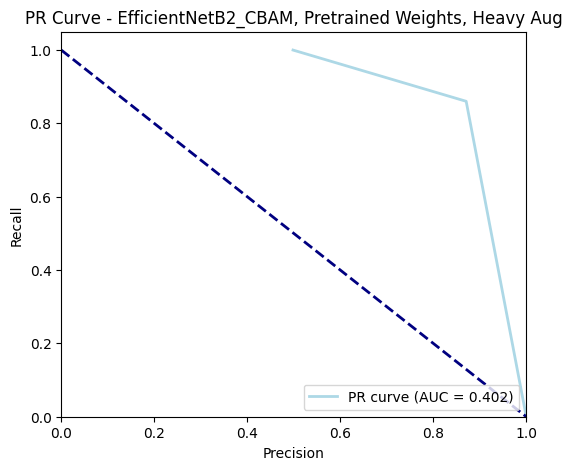

In [150]:
metrics(model_cbam_pretrained_ha_02)

### Metric Comparison

In [151]:
acc_df = pd.DataFrame.from_dict(acc, orient='index')
acc_df.columns = ['Accuracy']
print(acc_df.to_string(justify='left'))

                                                    Accuracy
Random Forest Untuned                               0.650368
Random Forest Tuned                                 0.660415
EfficientNetB0, Random Weights, Light Aug           0.523108
EfficientNetB0, Random Weights, Heavy Aug           0.523108
EfficientNetB0, Pretrained Weights, Light Aug       0.701942
EfficientNetB0, Pretrained Weights, Heavy Aug       0.656397
EfficientNetB0_CBAM, Random Weights, Light Aug      0.531815
EfficientNetB0_CBAM, Random Weights, Heavy Aug      0.569993
EfficientNetB0_CBAM, Pretrained Weights, Light Aug  0.851976
EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug  0.831212
EfficientNetB2_CBAM, Pretrained Weights, Light Aug  0.874079
EfficientNetB2_CBAM, Pretrained Weights, Heavy Aug  0.866711


In [152]:
prec_df = pd.DataFrame.from_dict(prec, orient='index')
prec_df.columns = ['Precision']
print(prec_df.to_string(justify='left'))

                                                    Precision
Random Forest Untuned                               0.649194 
Random Forest Tuned                                 0.654096 
EfficientNetB0, Random Weights, Light Aug           0.534632 
EfficientNetB0, Random Weights, Heavy Aug           0.516771 
EfficientNetB0, Pretrained Weights, Light Aug       0.707351 
EfficientNetB0, Pretrained Weights, Heavy Aug       0.682464 
EfficientNetB0_CBAM, Random Weights, Light Aug      0.529107 
EfficientNetB0_CBAM, Random Weights, Heavy Aug      0.560859 
EfficientNetB0_CBAM, Pretrained Weights, Light Aug  0.862691 
EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug  0.842618 
EfficientNetB2_CBAM, Pretrained Weights, Light Aug  0.902899 
EfficientNetB2_CBAM, Pretrained Weights, Heavy Aug  0.870748 


In [153]:
rec_df = pd.DataFrame.from_dict(rec, orient='index')
rec_df.columns = ['Recall']
print(rec_df.to_string(justify='left'))

                                                    Recall  
Random Forest Untuned                               0.649194
Random Forest Tuned                                 0.676075
EfficientNetB0, Random Weights, Light Aug           0.331989
EfficientNetB0, Random Weights, Heavy Aug           0.662634
EfficientNetB0, Pretrained Weights, Light Aug       0.685484
EfficientNetB0, Pretrained Weights, Heavy Aug       0.580645
EfficientNetB0_CBAM, Random Weights, Light Aug      0.549731
EfficientNetB0_CBAM, Random Weights, Heavy Aug      0.631720
EfficientNetB0_CBAM, Pretrained Weights, Light Aug  0.836022
EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug  0.813172
EfficientNetB2_CBAM, Pretrained Weights, Light Aug  0.837366
EfficientNetB2_CBAM, Pretrained Weights, Heavy Aug  0.860215


In [154]:
f1t_df = pd.DataFrame.from_dict(f1toxic, orient='index')
f1t_df.columns = ['F1-Score Toxic']
print(f1t_df.to_string(justify='left'))

                                                    F1-Score Toxic
Random Forest Untuned                               0.649194      
Random Forest Tuned                                 0.664904      
EfficientNetB0, Random Weights, Light Aug           0.409619      
EfficientNetB0, Random Weights, Heavy Aug           0.580683      
EfficientNetB0, Pretrained Weights, Light Aug       0.696246      
EfficientNetB0, Pretrained Weights, Heavy Aug       0.627451      
EfficientNetB0_CBAM, Random Weights, Light Aug      0.539222      
EfficientNetB0_CBAM, Random Weights, Heavy Aug      0.594185      
EfficientNetB0_CBAM, Pretrained Weights, Light Aug  0.849147      
EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug  0.827633      
EfficientNetB2_CBAM, Pretrained Weights, Light Aug  0.868898      
EfficientNetB2_CBAM, Pretrained Weights, Heavy Aug  0.865450      


In [155]:
#f1n_df = pd.DataFrame.from_dict(f1-nontoxic, orient='index')
#f1n_df.columns = ['F1-Score Nontoxic']
#print(f1n_df.to_string(justify='left'))

In [156]:
roc_df = pd.DataFrame.from_dict(roc, orient='index')
roc_df.columns = ['ROC_AUC']
print(roc_df.to_string(justify='left'))

                                                    ROC_AUC 
Random Forest Untuned                               0.713152
Random Forest Tuned                                 0.731623
EfficientNetB0, Random Weights, Light Aug           0.522470
EfficientNetB0, Random Weights, Heavy Aug           0.523574
EfficientNetB0, Pretrained Weights, Light Aug       0.701887
EfficientNetB0, Pretrained Weights, Heavy Aug       0.656144
EfficientNetB0_CBAM, Random Weights, Light Aug      0.531875
EfficientNetB0_CBAM, Random Weights, Heavy Aug      0.570199
EfficientNetB0_CBAM, Pretrained Weights, Light Aug  0.851923
EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug  0.831152
EfficientNetB2_CBAM, Pretrained Weights, Light Aug  0.873956
EfficientNetB2_CBAM, Pretrained Weights, Heavy Aug  0.866690


In [157]:
pr_df = pd.DataFrame.from_dict(pr, orient='index')
pr_df.columns = ['PR_AUC']
print(pr_df.to_string(justify='left'))

                                                    PR_AUC  
Random Forest Untuned                               0.238276
Random Forest Tuned                                 0.247470
EfficientNetB0, Random Weights, Light Aug           0.101429
EfficientNetB0, Random Weights, Heavy Aug           0.175436
EfficientNetB0, Pretrained Weights, Light Aug       0.276458
EfficientNetB0, Pretrained Weights, Heavy Aug       0.237717
EfficientNetB0_CBAM, Random Weights, Light Aug      0.153284
EfficientNetB0_CBAM, Random Weights, Heavy Aug      0.189726
EfficientNetB0_CBAM, Pretrained Weights, Light Aug  0.391888
EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug  0.376120
EfficientNetB2_CBAM, Pretrained Weights, Light Aug  0.412329
EfficientNetB2_CBAM, Pretrained Weights, Heavy Aug  0.401985


In [158]:
fn_df = pd.DataFrame.from_dict(fn, orient='index')
fn_df.columns = ['FNR']
print(fn_df.to_string(justify='left'))

                                                    FNR     
Random Forest Untuned                               0.350806
Random Forest Tuned                                 0.323925
EfficientNetB0, Random Weights, Light Aug           0.668011
EfficientNetB0, Random Weights, Heavy Aug           0.337366
EfficientNetB0, Pretrained Weights, Light Aug       0.314516
EfficientNetB0, Pretrained Weights, Heavy Aug       0.419355
EfficientNetB0_CBAM, Random Weights, Light Aug      0.450269
EfficientNetB0_CBAM, Random Weights, Heavy Aug      0.368280
EfficientNetB0_CBAM, Pretrained Weights, Light Aug  0.163978
EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug  0.186828
EfficientNetB2_CBAM, Pretrained Weights, Light Aug  0.162634
EfficientNetB2_CBAM, Pretrained Weights, Heavy Aug  0.139785


In [159]:
all_metrics = acc_df.join(prec_df, how='left')
all_metrics = all_metrics.join(rec_df, how='left')
all_metrics = all_metrics.join(f1t_df, how='left')
#all_metrics = all_metrics.join(f1n_df, how='left')
all_metrics = all_metrics.join(roc_df, how='left')
all_metrics = all_metrics.join(pr_df, how='left')
all_metrics = all_metrics.join(fn_df, how='left')
print(all_metrics.to_string(justify='left'))

                                                    Accuracy  Precision  Recall    F1-Score Toxic  ROC_AUC   PR_AUC    FNR     
Random Forest Untuned                               0.650368  0.649194   0.649194  0.649194        0.713152  0.238276  0.350806
Random Forest Tuned                                 0.660415  0.654096   0.676075  0.664904        0.731623  0.247470  0.323925
EfficientNetB0, Random Weights, Light Aug           0.523108  0.534632   0.331989  0.409619        0.522470  0.101429  0.668011
EfficientNetB0, Random Weights, Heavy Aug           0.523108  0.516771   0.662634  0.580683        0.523574  0.175436  0.337366
EfficientNetB0, Pretrained Weights, Light Aug       0.701942  0.707351   0.685484  0.696246        0.701887  0.276458  0.314516
EfficientNetB0, Pretrained Weights, Heavy Aug       0.656397  0.682464   0.580645  0.627451        0.656144  0.237717  0.419355
EfficientNetB0_CBAM, Random Weights, Light Aug      0.531815  0.529107   0.549731  0.539222        0.531

In [160]:
total_timing

{'EfficientNetB0, Random Weights, Light Aug': 182.36457204818726,
 'EfficientNetB0, Random Weights, Heavy Aug': 183.09246945381165,
 'EfficientNetB0, Pretrained Weights, Light Aug': 183.65071272850037,
 'EfficientNetB0, Pretrained Weights, Heavy Aug': 178.0483124256134,
 'EfficientNetB0_CBAM, Random Meights, Light Aug': 181.10239028930664,
 'EfficientNetB0_CBAM, Random Weights, Heavy Aug': 181.96093654632568,
 'EfficientNetB0_CBAM, Pretrained Weights, Light Aug': 182.64922428131104,
 'EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug': 181.2188184261322,
 'EfficientNetB2_CBAM, Pretrained Weights, Light Aug': 215.15221881866455,
 'EfficientNetB2_CBAM, Pretrained Weights, Heavy Augmemtation': 215.544912815094}

EfficientNetB0_CBAM, Pretrained Weights0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.32it/s]


Train Loss: 0.5583, Train Acc: 70.14%
Val Loss: 0.3926, Val Acc: 80.71%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.83it/s]


Train Loss: 0.3277, Train Acc: 85.40%
Val Loss: 0.3543, Val Acc: 83.46%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.24it/s]


Train Loss: 0.2140, Train Acc: 91.04%
Val Loss: 0.3639, Val Acc: 84.19%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.56it/s]


Train Loss: 0.1421, Train Acc: 94.14%
Val Loss: 0.3970, Val Acc: 85.13%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.52it/s]


Train Loss: 0.0965, Train Acc: 96.25%
Val Loss: 0.4385, Val Acc: 84.39%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.16it/s]


Train Loss: 0.0600, Train Acc: 97.93%
Val Loss: 0.4321, Val Acc: 85.06%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.24it/s]


Train Loss: 0.0531, Train Acc: 98.25%
Val Loss: 0.4166, Val Acc: 85.20%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.80it/s]


Train Loss: 0.0547, Train Acc: 98.03%
Val Loss: 0.4230, Val Acc: 85.33%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.47it/s]


Train Loss: 0.0496, Train Acc: 98.44%
Val Loss: 0.4454, Val Acc: 85.47%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.37it/s]


Train Loss: 0.0426, Train Acc: 98.59%
Val Loss: 0.4208, Val Acc: 85.73%


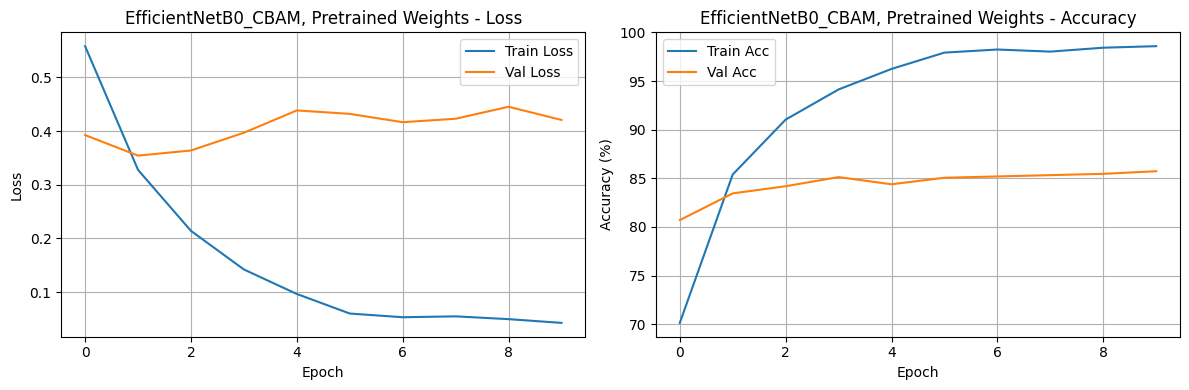


Classification Report for MODEL NOT NAMED':

              precision    recall  f1-score   support

   Non-Toxic       0.85      0.86      0.86       749
       Toxic       0.86      0.85      0.85       744

    accuracy                           0.86      1493
   macro avg       0.86      0.86      0.86      1493
weighted avg       0.86      0.86      0.86      1493



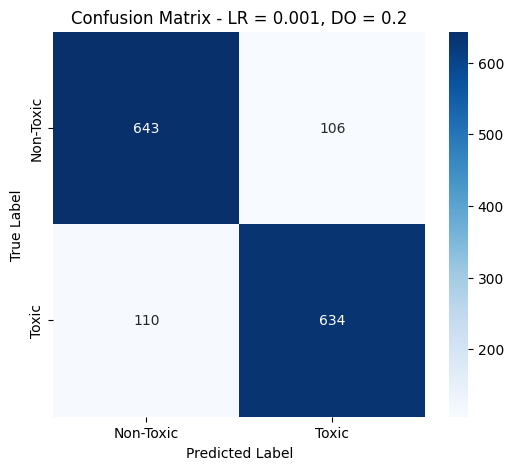

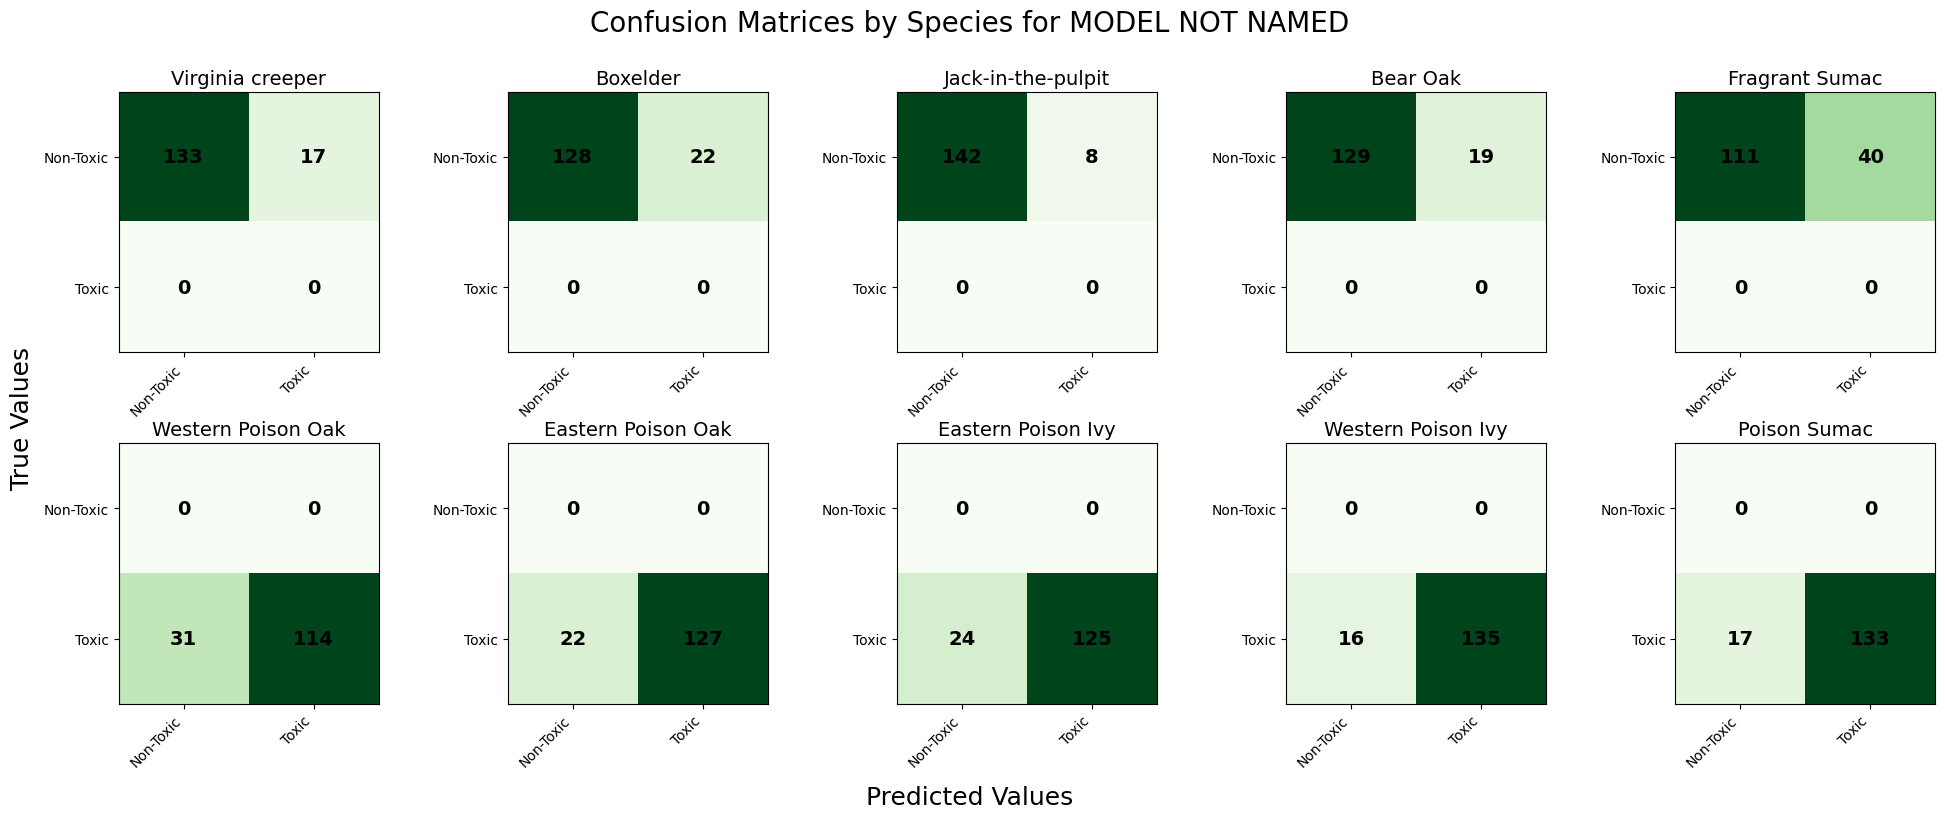

                    False Negative Rate
Western Poison Oak  0.213793           
Eastern Poison Oak  0.147651           
Eastern Poison Ivy  0.161074           
Western Poison Ivy  0.105960           
Poison Sumac        0.113333           


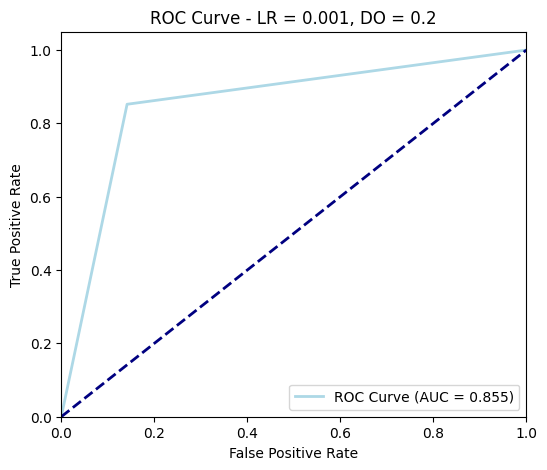

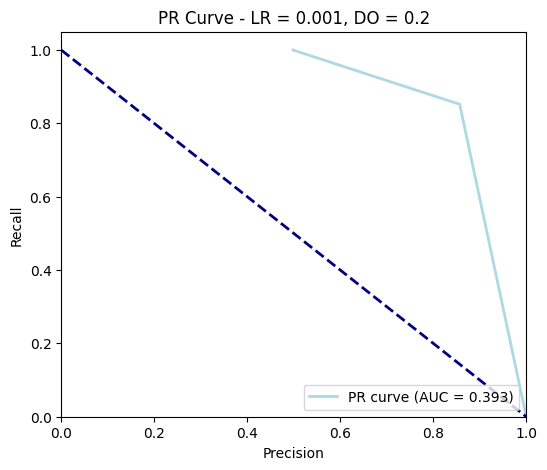

EfficientNetB0_CBAM, Pretrained Weights0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.08it/s]


Train Loss: 0.5693, Train Acc: 68.32%
Val Loss: 0.4015, Val Acc: 80.17%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.69it/s]


Train Loss: 0.3389, Train Acc: 84.31%
Val Loss: 0.3488, Val Acc: 83.52%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.29it/s]


Train Loss: 0.2260, Train Acc: 90.22%
Val Loss: 0.3889, Val Acc: 85.00%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.53it/s]


Train Loss: 0.1444, Train Acc: 94.29%
Val Loss: 0.4284, Val Acc: 85.00%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.72it/s]


Train Loss: 0.1017, Train Acc: 96.33%
Val Loss: 0.4551, Val Acc: 84.80%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.33it/s]


Train Loss: 0.0686, Train Acc: 97.56%
Val Loss: 0.4077, Val Acc: 86.27%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.16it/s]


Train Loss: 0.0584, Train Acc: 97.86%
Val Loss: 0.4202, Val Acc: 85.47%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.55it/s]


Train Loss: 0.0500, Train Acc: 98.23%
Val Loss: 0.4457, Val Acc: 85.20%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.62it/s]


Train Loss: 0.0465, Train Acc: 98.44%
Val Loss: 0.4298, Val Acc: 86.00%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.66it/s]


Train Loss: 0.0484, Train Acc: 98.29%
Val Loss: 0.4262, Val Acc: 85.67%


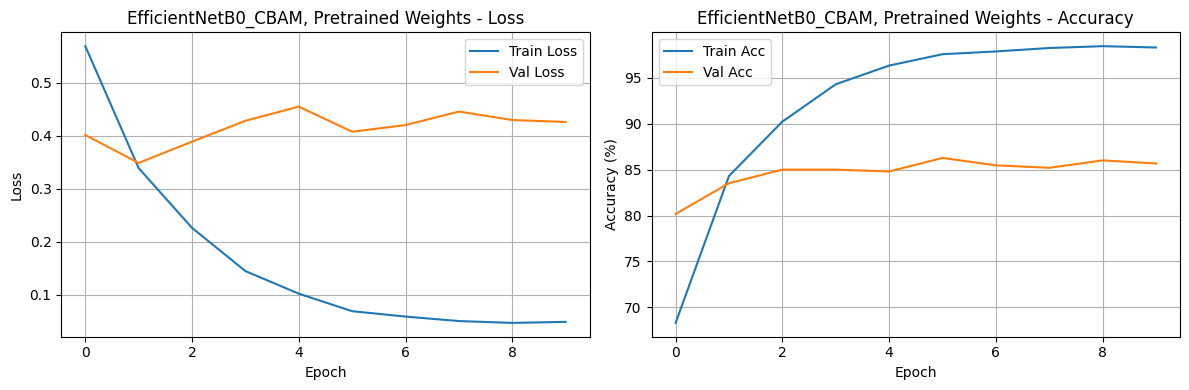


Classification Report for MODEL NOT NAMED':

              precision    recall  f1-score   support

   Non-Toxic       0.85      0.86      0.86       749
       Toxic       0.86      0.85      0.86       744

    accuracy                           0.86      1493
   macro avg       0.86      0.86      0.86      1493
weighted avg       0.86      0.86      0.86      1493



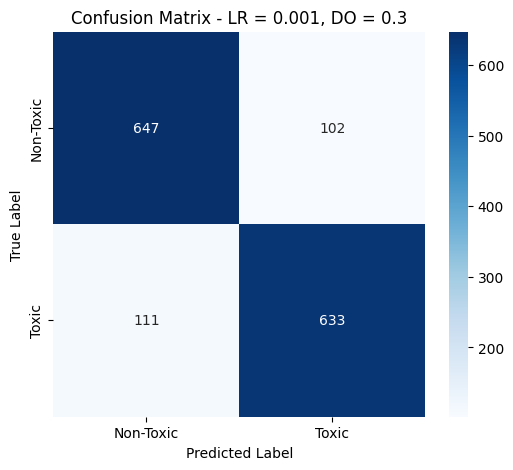

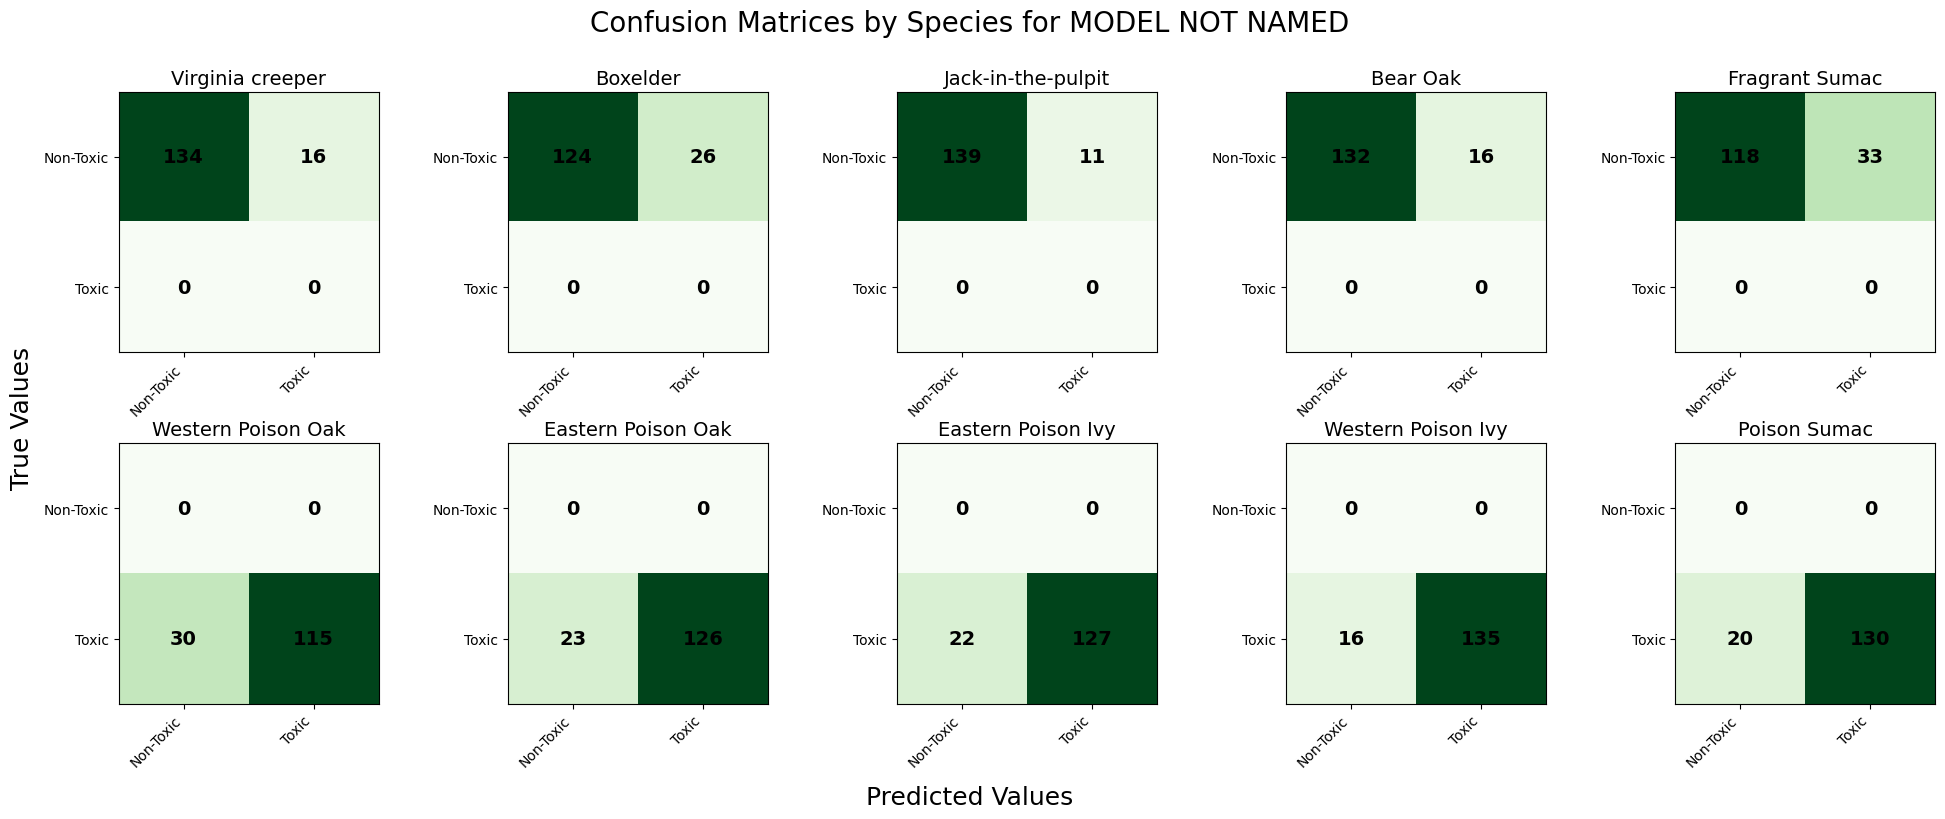

                    False Negative Rate
Western Poison Oak  0.206897           
Eastern Poison Oak  0.154362           
Eastern Poison Ivy  0.147651           
Western Poison Ivy  0.105960           
Poison Sumac        0.133333           


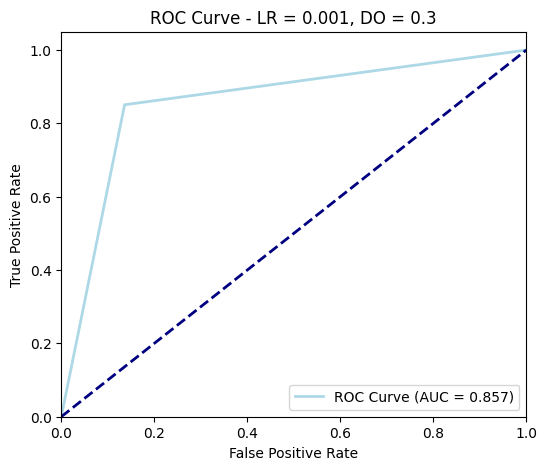

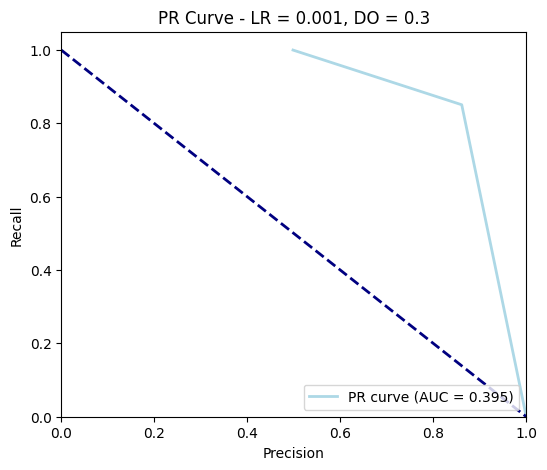

EfficientNetB0_CBAM, Pretrained Weights0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.74it/s]


Train Loss: 0.5801, Train Acc: 68.48%
Val Loss: 0.4318, Val Acc: 78.77%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.83it/s]


Train Loss: 0.3611, Train Acc: 83.49%
Val Loss: 0.3578, Val Acc: 82.38%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.39it/s]


Train Loss: 0.2307, Train Acc: 90.45%
Val Loss: 0.3536, Val Acc: 83.46%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.04it/s]


Train Loss: 0.1493, Train Acc: 93.87%
Val Loss: 0.3832, Val Acc: 84.33%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.56it/s]


Train Loss: 0.1135, Train Acc: 95.65%
Val Loss: 0.4196, Val Acc: 85.13%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.75it/s]


Train Loss: 0.0769, Train Acc: 97.29%
Val Loss: 0.3935, Val Acc: 85.00%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.65it/s]


Train Loss: 0.0646, Train Acc: 97.90%
Val Loss: 0.4032, Val Acc: 85.00%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.76it/s]


Train Loss: 0.0580, Train Acc: 97.80%
Val Loss: 0.4634, Val Acc: 85.87%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.44it/s]


Train Loss: 0.0505, Train Acc: 98.26%
Val Loss: 0.4030, Val Acc: 86.27%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.55it/s]


Train Loss: 0.0480, Train Acc: 98.44%
Val Loss: 0.4191, Val Acc: 86.54%


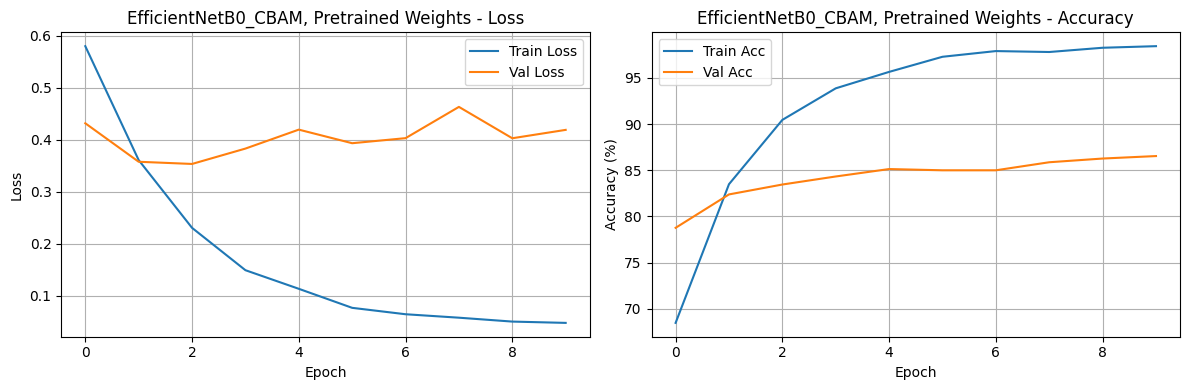


Classification Report for MODEL NOT NAMED':

              precision    recall  f1-score   support

   Non-Toxic       0.84      0.86      0.85       749
       Toxic       0.85      0.84      0.85       744

    accuracy                           0.85      1493
   macro avg       0.85      0.85      0.85      1493
weighted avg       0.85      0.85      0.85      1493



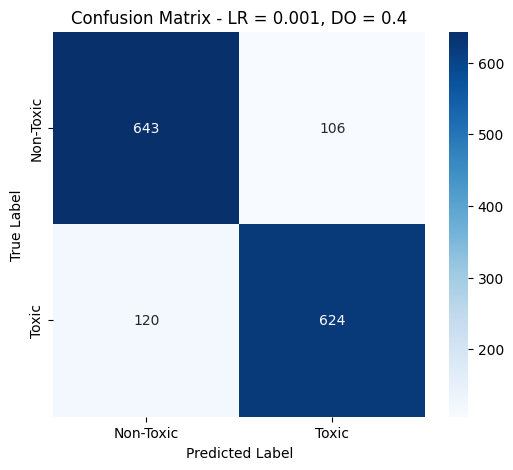

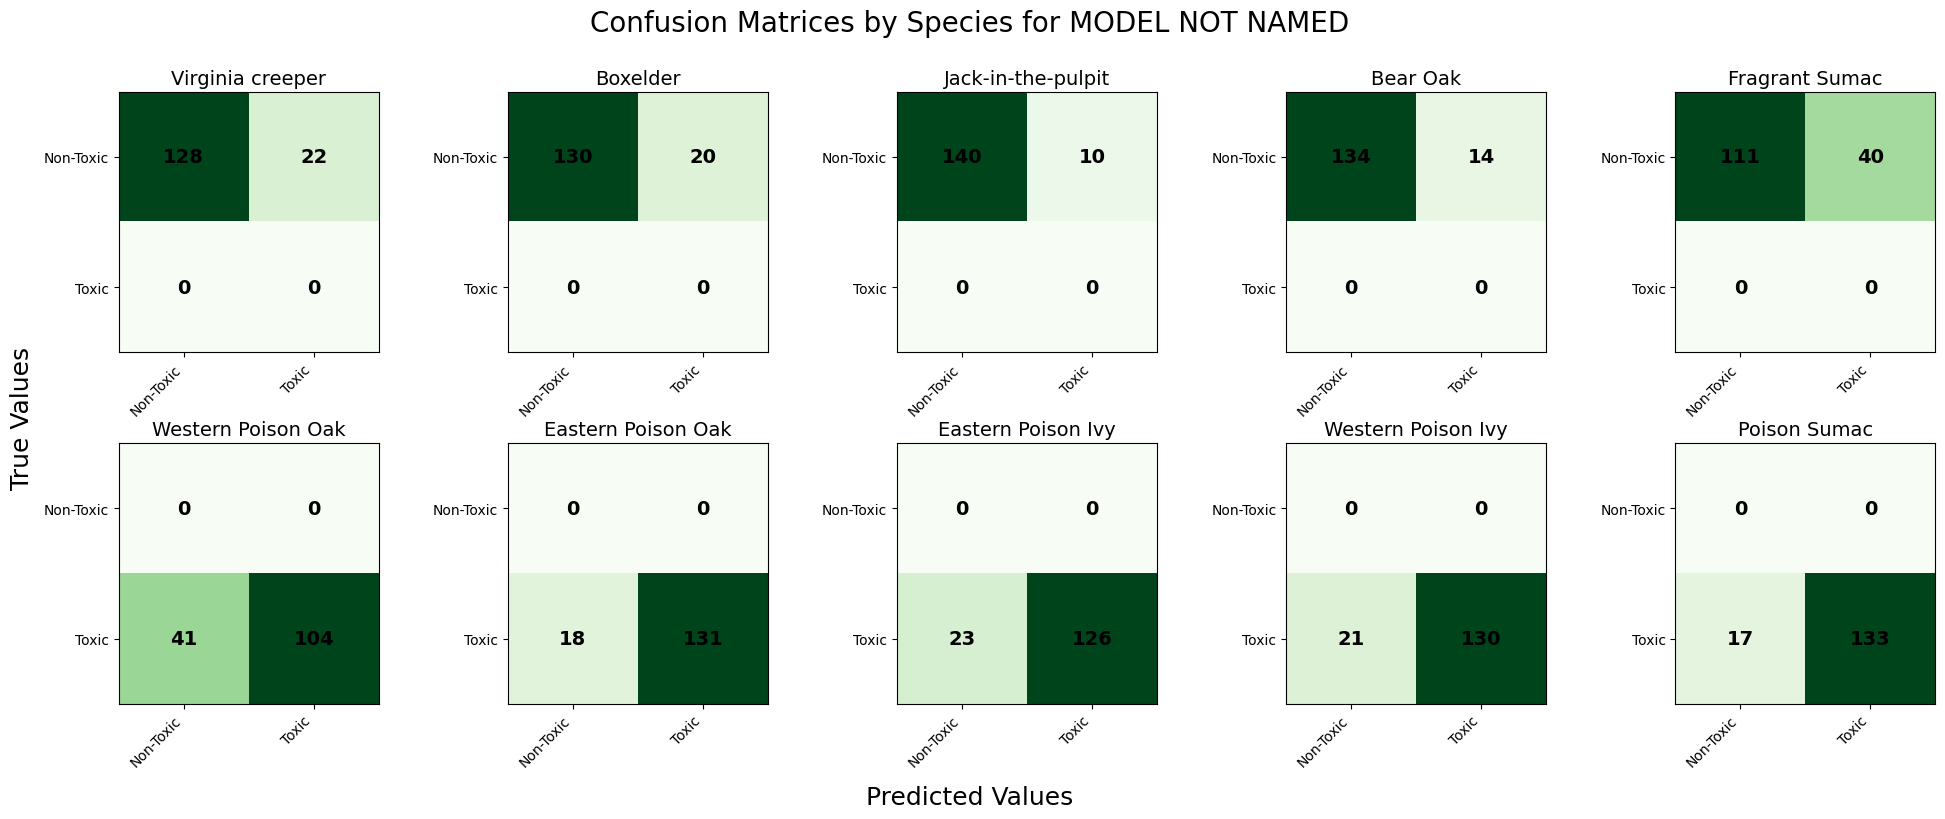

                    False Negative Rate
Western Poison Oak  0.282759           
Eastern Poison Oak  0.120805           
Eastern Poison Ivy  0.154362           
Western Poison Ivy  0.139073           
Poison Sumac        0.113333           


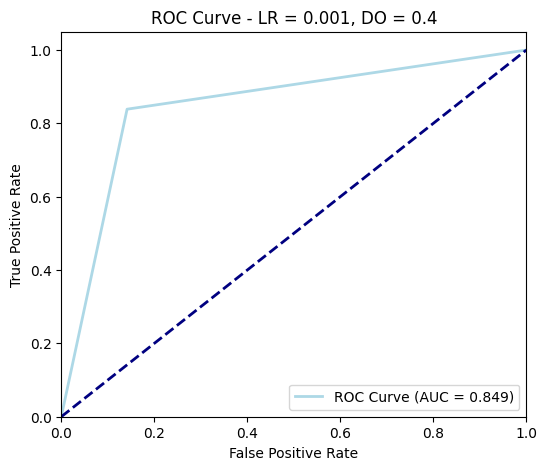

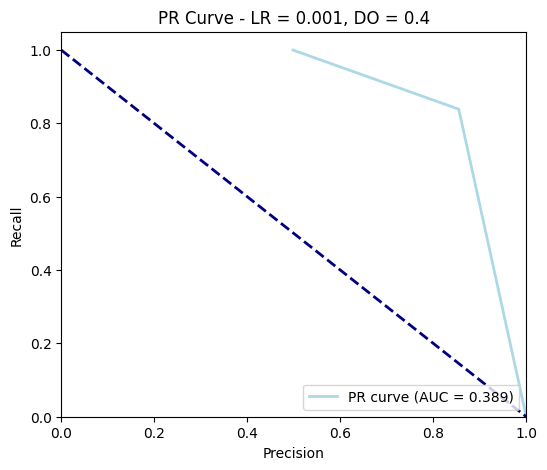

EfficientNetB0_CBAM, Pretrained Weights0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.64it/s]


Train Loss: 0.5711, Train Acc: 68.25%
Val Loss: 0.4098, Val Acc: 80.58%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.96it/s]


Train Loss: 0.3519, Train Acc: 84.38%
Val Loss: 0.3503, Val Acc: 83.59%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.91it/s]


Train Loss: 0.2288, Train Acc: 90.47%
Val Loss: 0.3427, Val Acc: 85.26%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.27it/s]


Train Loss: 0.1552, Train Acc: 93.38%
Val Loss: 0.3422, Val Acc: 86.27%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.86it/s]


Train Loss: 0.1050, Train Acc: 95.78%
Val Loss: 0.4104, Val Acc: 85.13%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.79it/s]


Train Loss: 0.0663, Train Acc: 97.57%
Val Loss: 0.3836, Val Acc: 86.67%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.35it/s]


Train Loss: 0.0642, Train Acc: 97.60%
Val Loss: 0.3901, Val Acc: 86.81%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.30it/s]


Train Loss: 0.0536, Train Acc: 98.22%
Val Loss: 0.3998, Val Acc: 86.87%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.95it/s]


Train Loss: 0.0546, Train Acc: 98.22%
Val Loss: 0.4023, Val Acc: 86.67%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.55it/s]


Train Loss: 0.0525, Train Acc: 98.18%
Val Loss: 0.4093, Val Acc: 87.34%


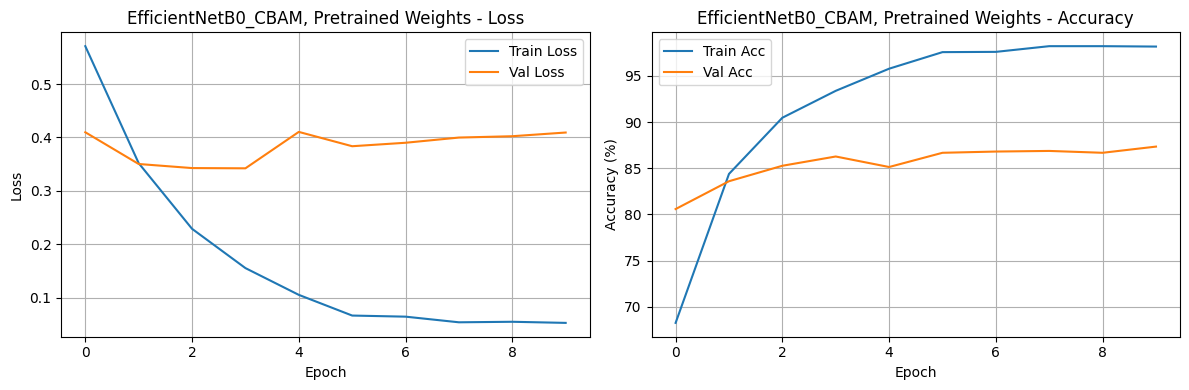


Classification Report for MODEL NOT NAMED':

              precision    recall  f1-score   support

   Non-Toxic       0.87      0.84      0.86       749
       Toxic       0.85      0.87      0.86       744

    accuracy                           0.86      1493
   macro avg       0.86      0.86      0.86      1493
weighted avg       0.86      0.86      0.86      1493



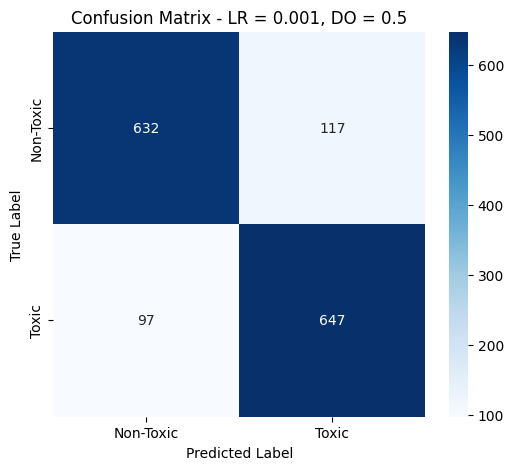

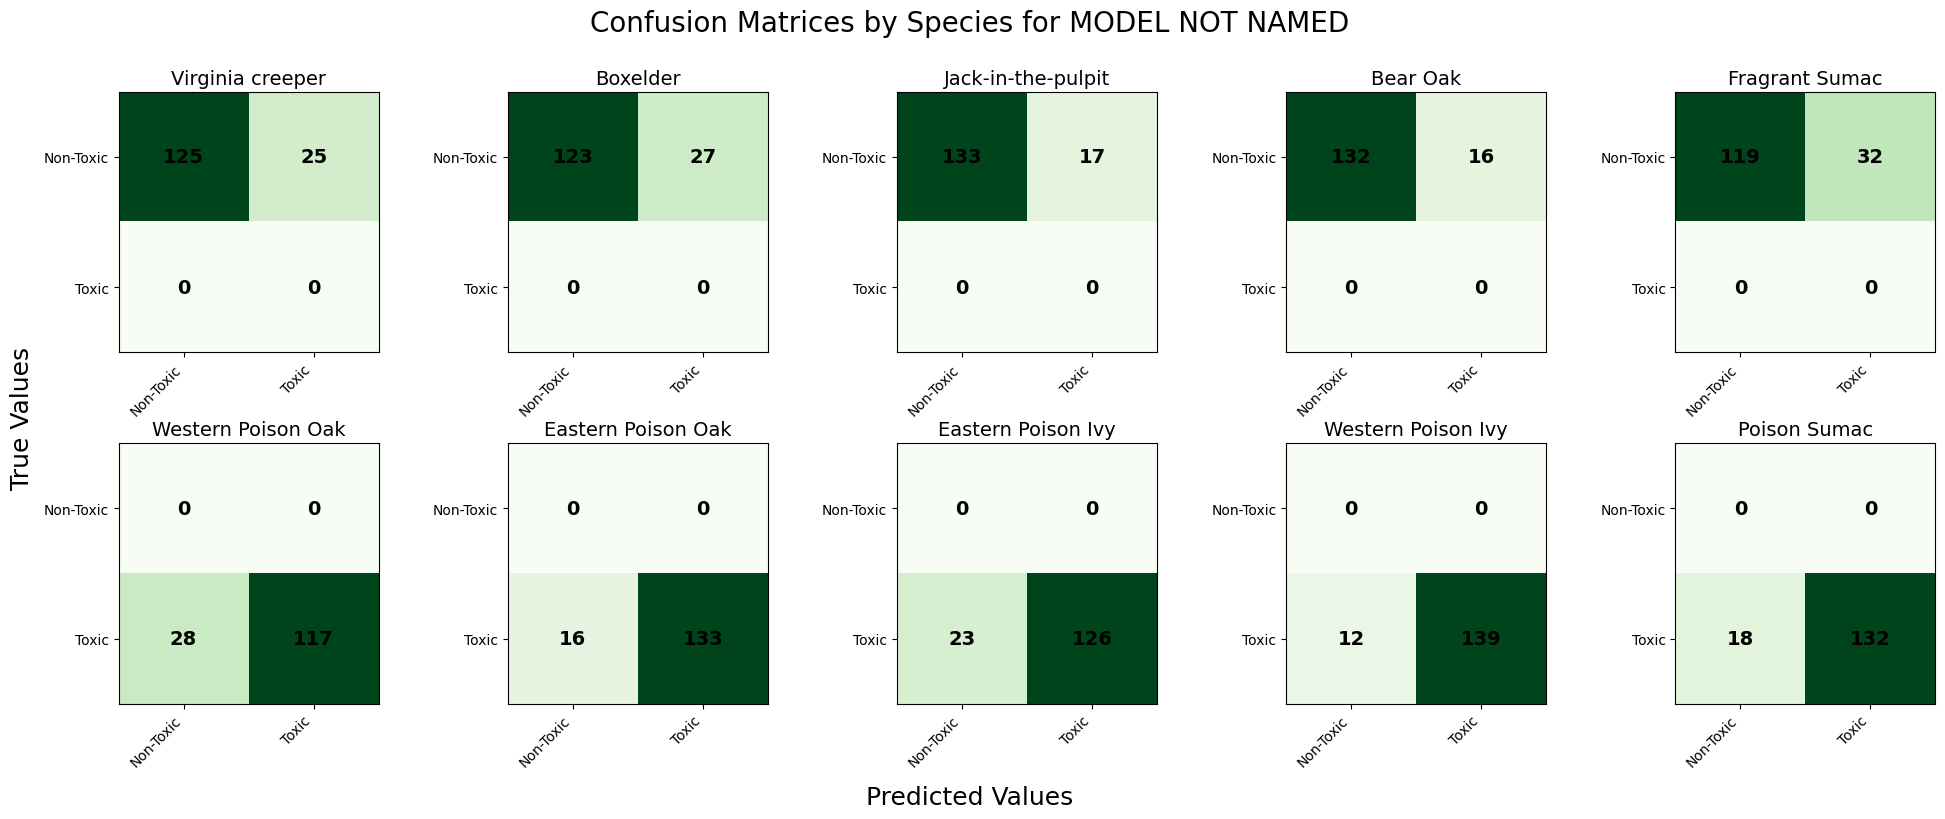

                    False Negative Rate
Western Poison Oak  0.193103           
Eastern Poison Oak  0.107383           
Eastern Poison Ivy  0.154362           
Western Poison Ivy  0.079470           
Poison Sumac        0.120000           


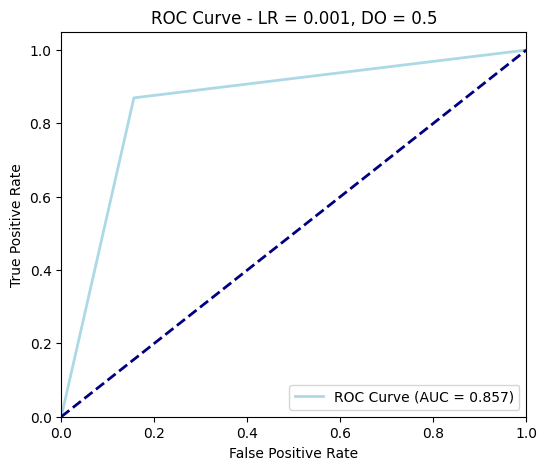

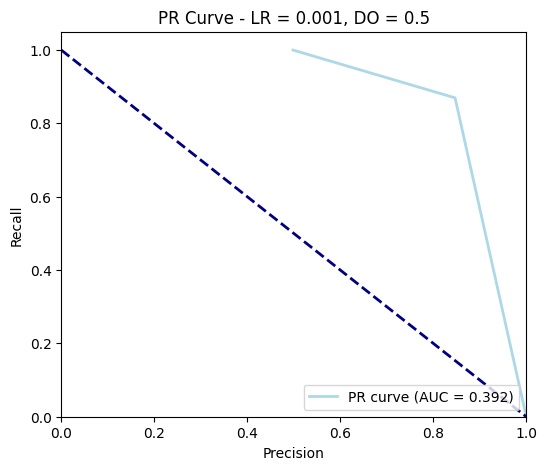

EfficientNetB0_CBAM, Pretrained Weights0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.41it/s]


Train Loss: 0.5714, Train Acc: 68.92%
Val Loss: 0.4071, Val Acc: 81.31%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.99it/s]


Train Loss: 0.3431, Train Acc: 84.19%
Val Loss: 0.3438, Val Acc: 84.46%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.40it/s]


Train Loss: 0.2149, Train Acc: 91.30%
Val Loss: 0.3622, Val Acc: 84.06%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.65it/s]


Train Loss: 0.1331, Train Acc: 94.60%
Val Loss: 0.4008, Val Acc: 84.53%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.20it/s]


Train Loss: 0.0947, Train Acc: 96.31%
Val Loss: 0.4091, Val Acc: 85.73%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.76it/s]


Train Loss: 0.0689, Train Acc: 97.63%
Val Loss: 0.4203, Val Acc: 85.93%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.98it/s]


Train Loss: 0.0516, Train Acc: 98.38%
Val Loss: 0.4217, Val Acc: 85.80%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.12it/s]


Train Loss: 0.0499, Train Acc: 98.19%
Val Loss: 0.4191, Val Acc: 86.27%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.62it/s]


Train Loss: 0.0401, Train Acc: 98.84%
Val Loss: 0.4547, Val Acc: 86.00%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.84it/s]


Train Loss: 0.0419, Train Acc: 98.64%
Val Loss: 0.4380, Val Acc: 85.87%


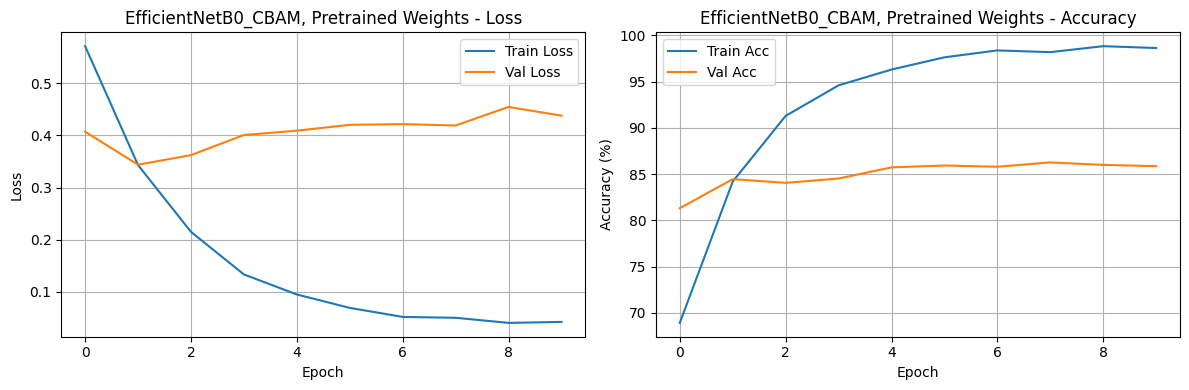


Classification Report for MODEL NOT NAMED':

              precision    recall  f1-score   support

   Non-Toxic       0.85      0.87      0.86       749
       Toxic       0.86      0.84      0.85       744

    accuracy                           0.85      1493
   macro avg       0.85      0.85      0.85      1493
weighted avg       0.85      0.85      0.85      1493



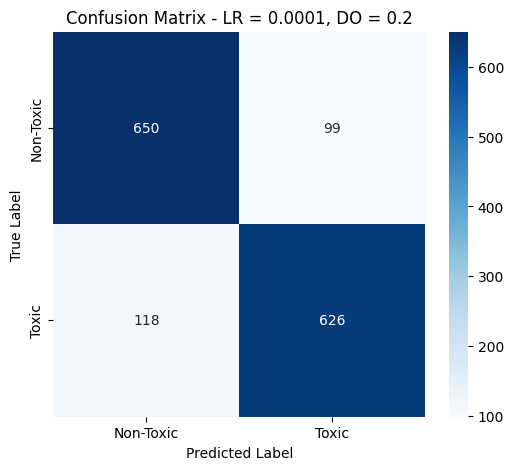

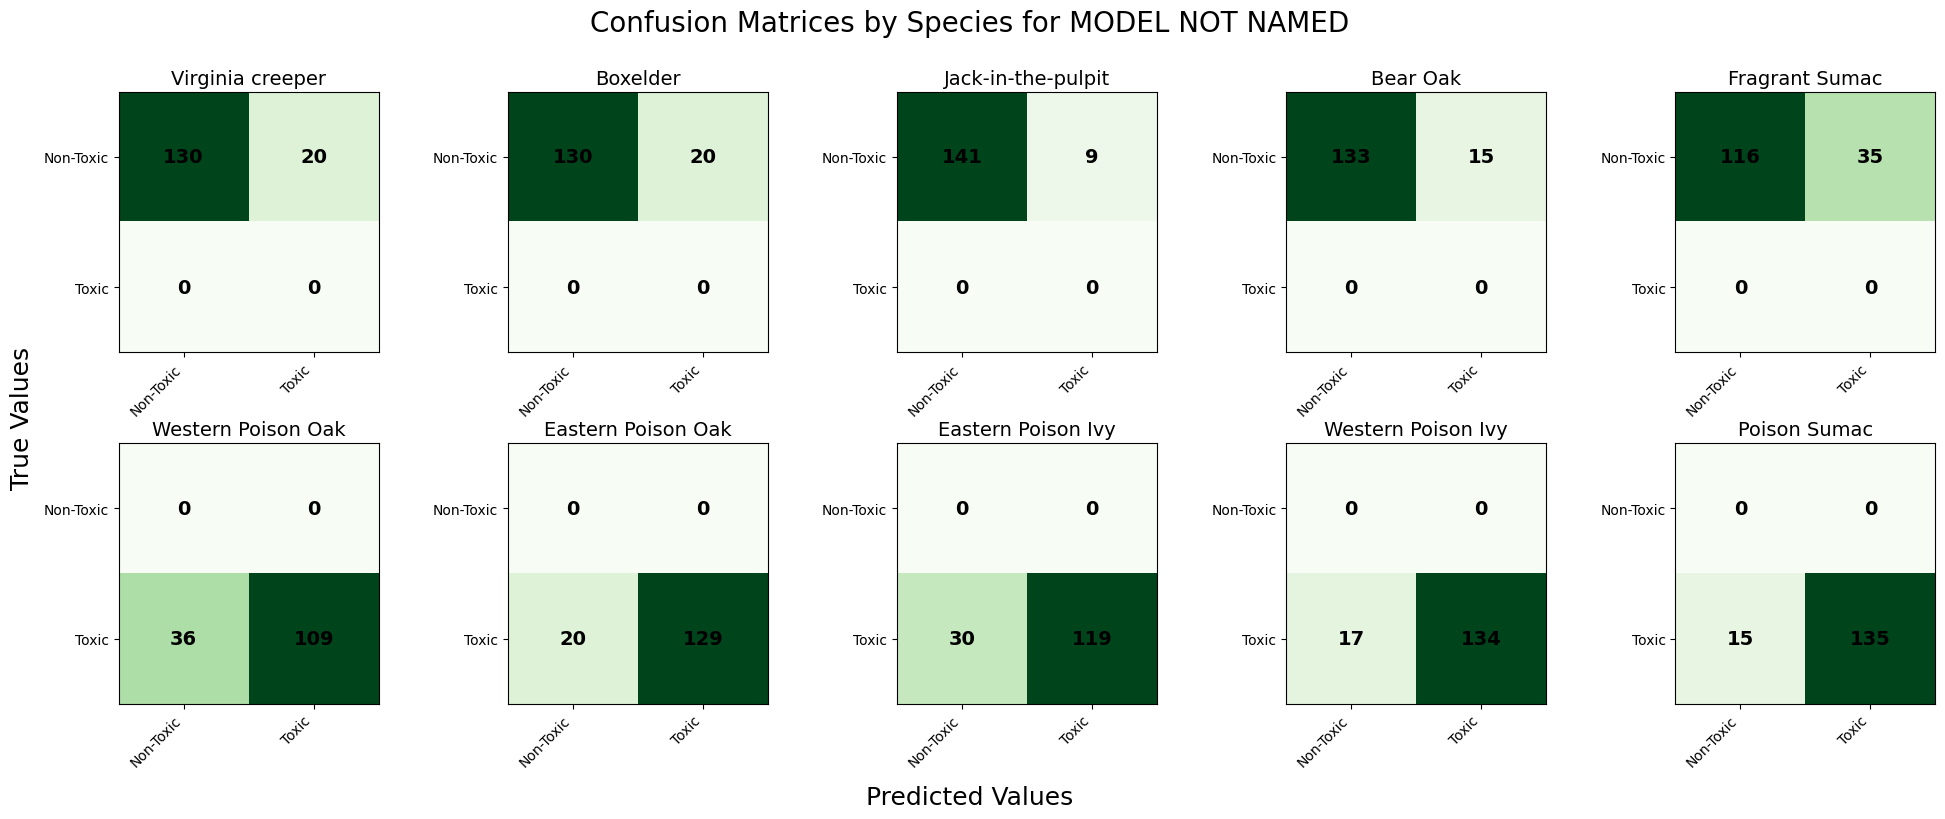

                    False Negative Rate
Western Poison Oak  0.248276           
Eastern Poison Oak  0.134228           
Eastern Poison Ivy  0.201342           
Western Poison Ivy  0.112583           
Poison Sumac        0.100000           


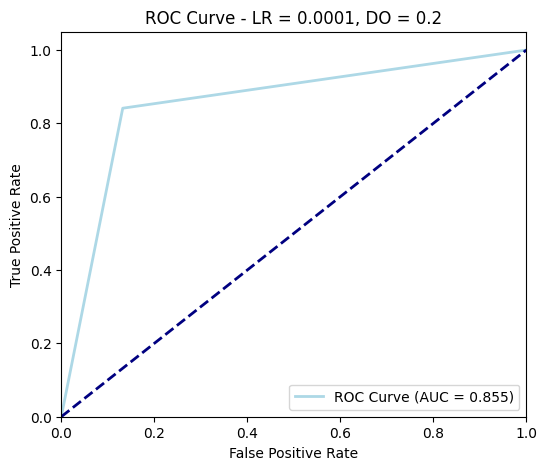

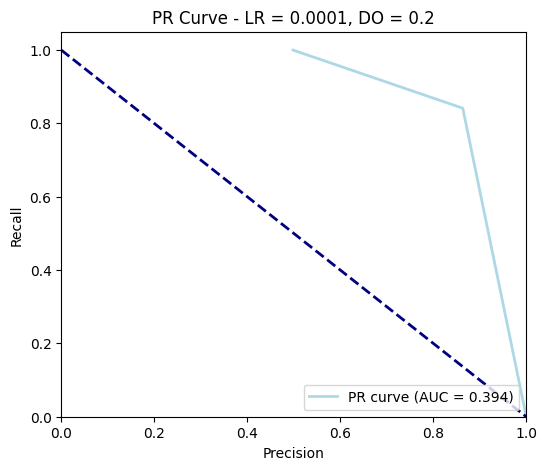

EfficientNetB0_CBAM, Pretrained Weights0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.48it/s]


Train Loss: 0.5573, Train Acc: 69.84%
Val Loss: 0.4062, Val Acc: 80.98%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.20it/s]


Train Loss: 0.3451, Train Acc: 84.38%
Val Loss: 0.3452, Val Acc: 84.13%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.47it/s]


Train Loss: 0.2145, Train Acc: 90.81%
Val Loss: 0.3646, Val Acc: 85.13%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.30it/s]


Train Loss: 0.1445, Train Acc: 94.19%
Val Loss: 0.3897, Val Acc: 85.60%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.95it/s]


Train Loss: 0.1108, Train Acc: 95.84%
Val Loss: 0.3633, Val Acc: 85.06%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.37it/s]


Train Loss: 0.0773, Train Acc: 97.39%
Val Loss: 0.3518, Val Acc: 86.07%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.17it/s]


Train Loss: 0.0637, Train Acc: 97.92%
Val Loss: 0.3604, Val Acc: 86.54%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.66it/s]


Train Loss: 0.0517, Train Acc: 98.33%
Val Loss: 0.3782, Val Acc: 85.73%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.04it/s]


Train Loss: 0.0470, Train Acc: 98.72%
Val Loss: 0.3894, Val Acc: 85.80%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.10it/s]


Train Loss: 0.0473, Train Acc: 98.44%
Val Loss: 0.3944, Val Acc: 85.73%


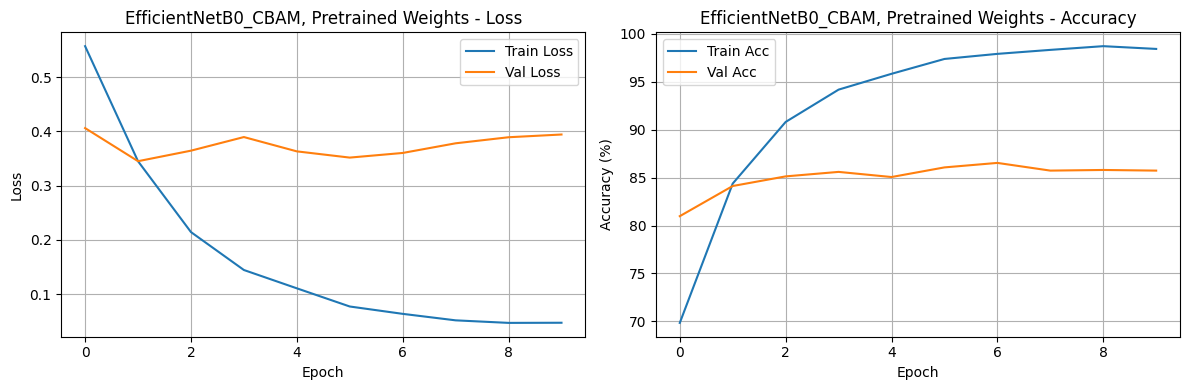


Classification Report for MODEL NOT NAMED':

              precision    recall  f1-score   support

   Non-Toxic       0.85      0.87      0.86       749
       Toxic       0.86      0.85      0.86       744

    accuracy                           0.86      1493
   macro avg       0.86      0.86      0.86      1493
weighted avg       0.86      0.86      0.86      1493



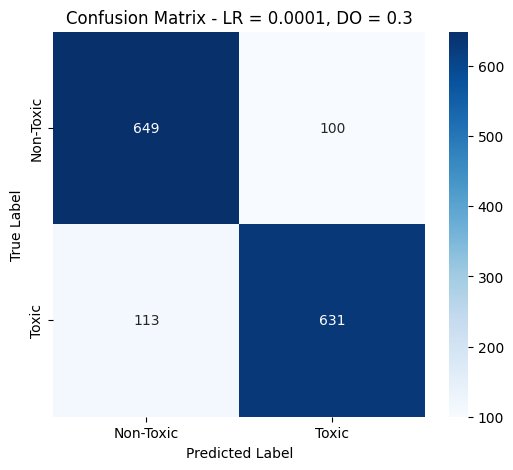

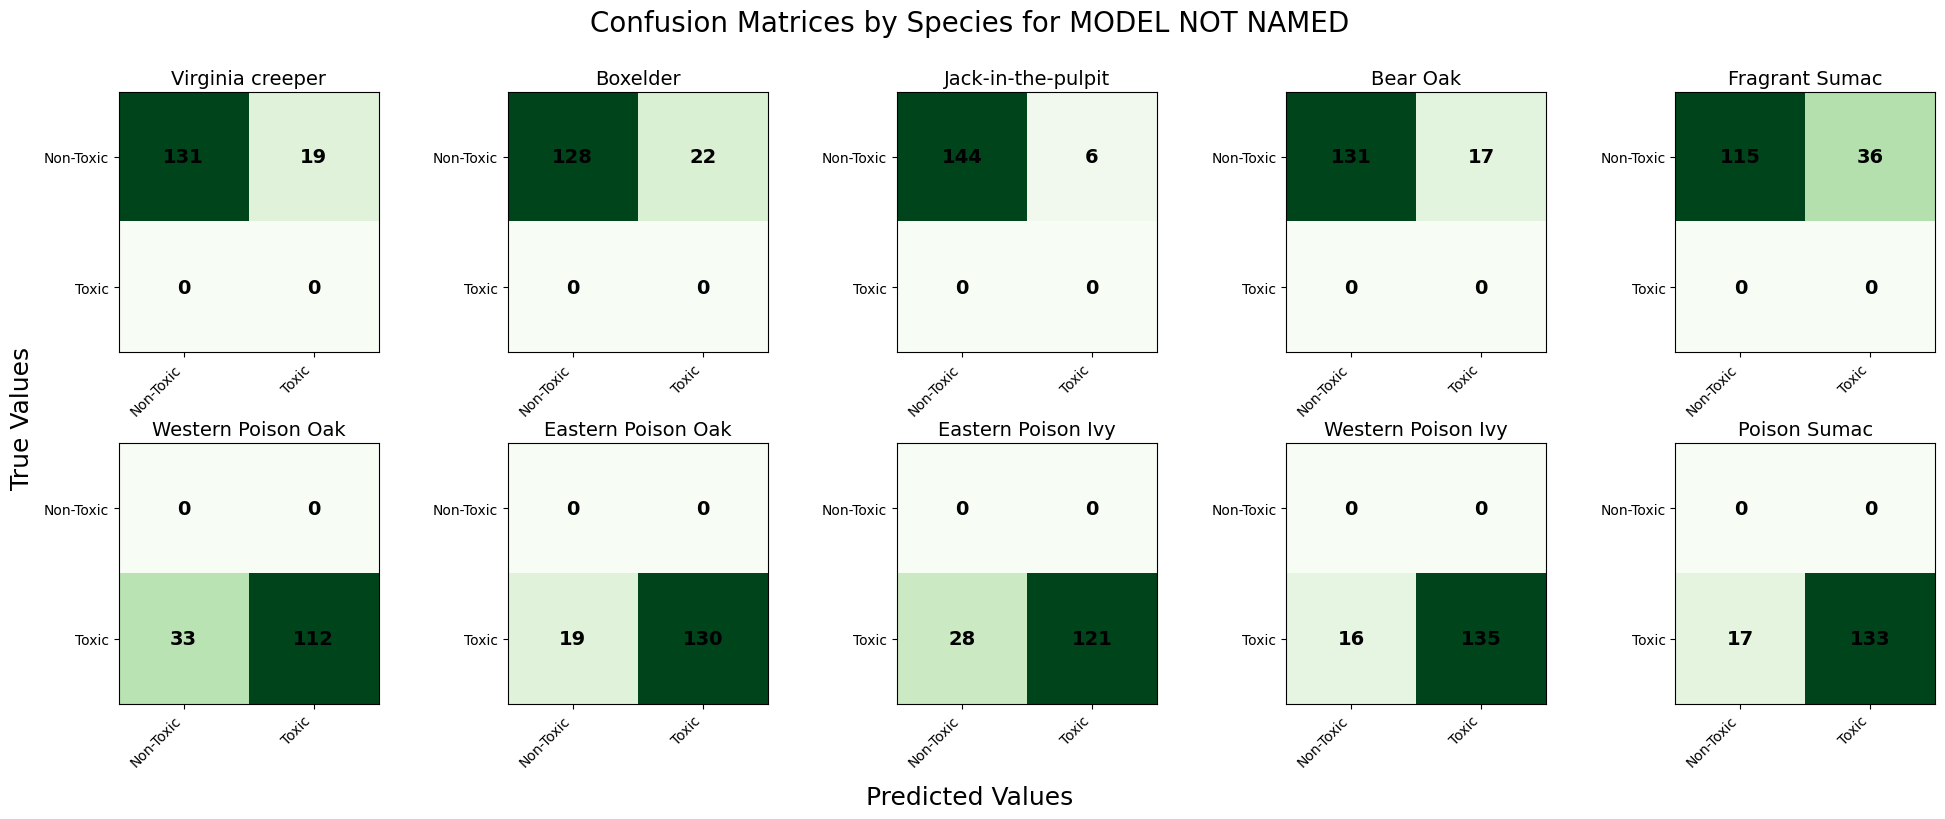

                    False Negative Rate
Western Poison Oak  0.227586           
Eastern Poison Oak  0.127517           
Eastern Poison Ivy  0.187919           
Western Poison Ivy  0.105960           
Poison Sumac        0.113333           


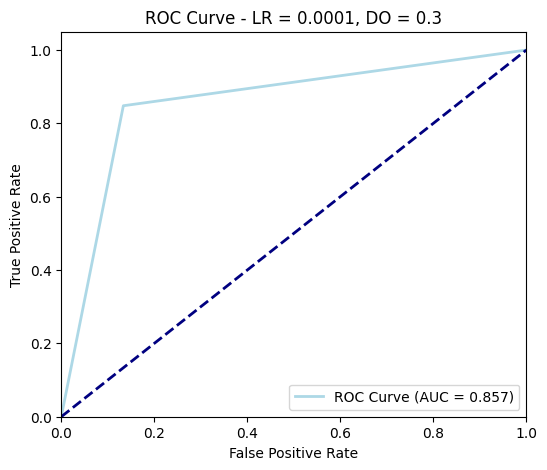

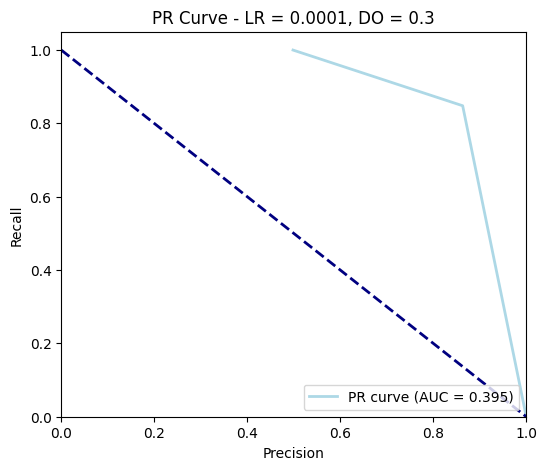

EfficientNetB0_CBAM, Pretrained Weights0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.22it/s]


Train Loss: 0.5811, Train Acc: 68.42%
Val Loss: 0.4078, Val Acc: 80.71%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.96it/s]


Train Loss: 0.3519, Train Acc: 83.84%
Val Loss: 0.3363, Val Acc: 84.93%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.76it/s]


Train Loss: 0.2256, Train Acc: 90.25%
Val Loss: 0.3379, Val Acc: 85.40%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.02it/s]


Train Loss: 0.1406, Train Acc: 94.23%
Val Loss: 0.3994, Val Acc: 85.67%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.32it/s]


Train Loss: 0.1098, Train Acc: 95.64%
Val Loss: 0.4040, Val Acc: 85.93%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.43it/s]


Train Loss: 0.0770, Train Acc: 97.34%
Val Loss: 0.3801, Val Acc: 86.67%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.12it/s]


Train Loss: 0.0625, Train Acc: 97.86%
Val Loss: 0.3779, Val Acc: 87.27%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.17it/s]


Train Loss: 0.0562, Train Acc: 98.16%
Val Loss: 0.3804, Val Acc: 87.21%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.46it/s]


Train Loss: 0.0477, Train Acc: 98.38%
Val Loss: 0.3872, Val Acc: 87.34%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.96it/s]


Train Loss: 0.0473, Train Acc: 98.51%
Val Loss: 0.3969, Val Acc: 87.27%


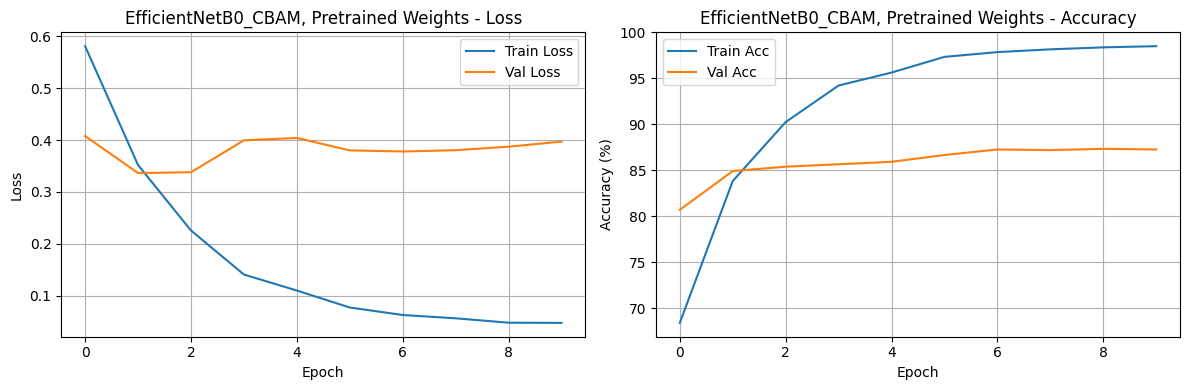


Classification Report for MODEL NOT NAMED':

              precision    recall  f1-score   support

   Non-Toxic       0.85      0.89      0.87       749
       Toxic       0.88      0.85      0.86       744

    accuracy                           0.87      1493
   macro avg       0.87      0.87      0.87      1493
weighted avg       0.87      0.87      0.87      1493



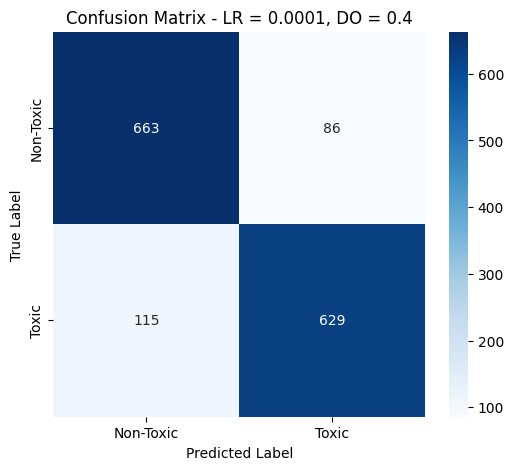

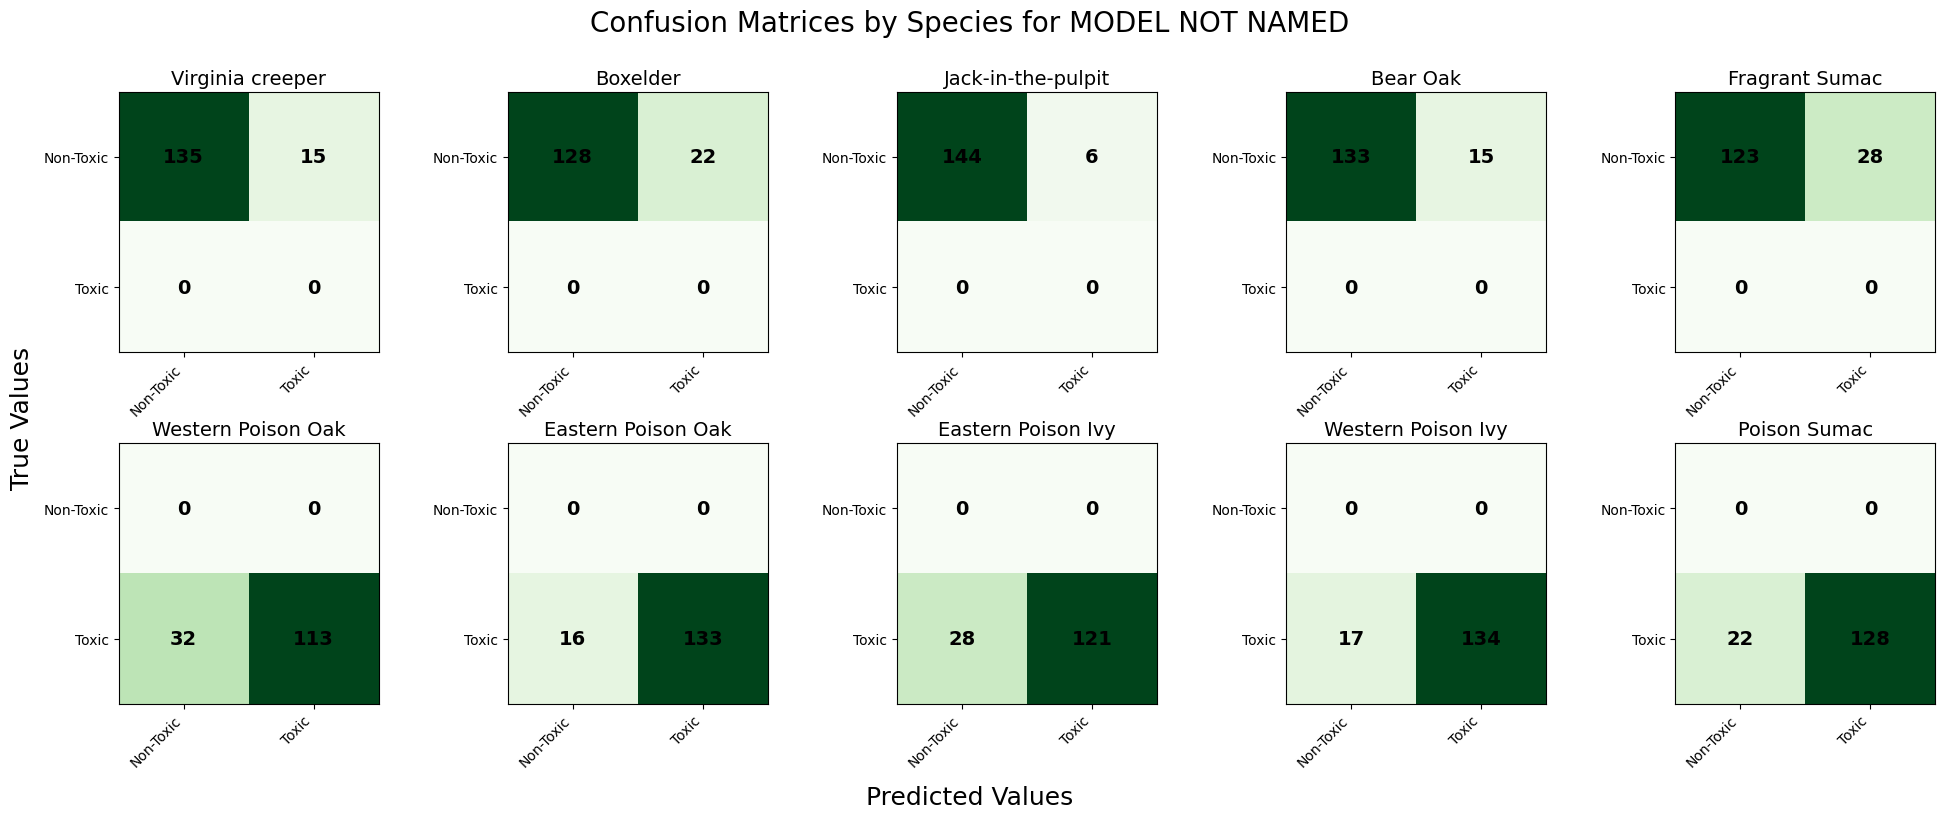

                    False Negative Rate
Western Poison Oak  0.220690           
Eastern Poison Oak  0.107383           
Eastern Poison Ivy  0.187919           
Western Poison Ivy  0.112583           
Poison Sumac        0.146667           


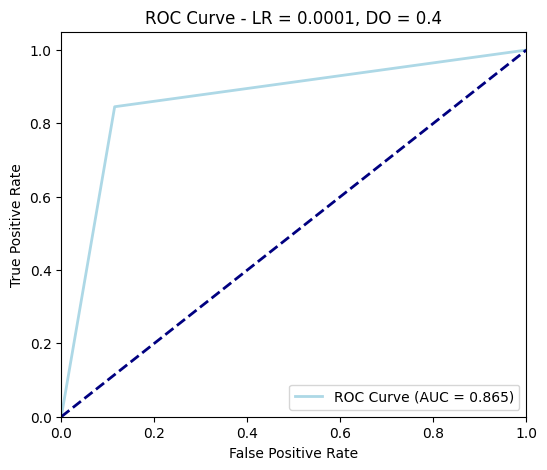

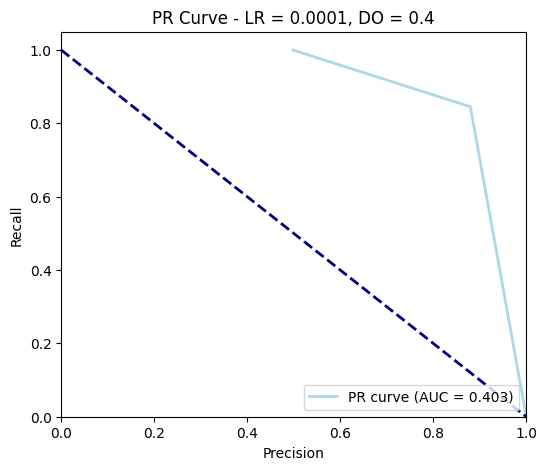

EfficientNetB0_CBAM, Pretrained Weights0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.24it/s]


Train Loss: 0.5799, Train Acc: 68.93%
Val Loss: 0.4156, Val Acc: 80.98%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.54it/s]


Train Loss: 0.3506, Train Acc: 84.11%
Val Loss: 0.3364, Val Acc: 84.73%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.78it/s]


Train Loss: 0.2198, Train Acc: 90.97%
Val Loss: 0.3290, Val Acc: 85.60%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.23it/s]


Train Loss: 0.1477, Train Acc: 94.09%
Val Loss: 0.3934, Val Acc: 84.80%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.06it/s]


Train Loss: 0.1089, Train Acc: 95.64%
Val Loss: 0.4407, Val Acc: 84.46%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.77it/s]


Train Loss: 0.0759, Train Acc: 97.33%
Val Loss: 0.3978, Val Acc: 85.47%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.01it/s]


Train Loss: 0.0592, Train Acc: 97.93%
Val Loss: 0.4069, Val Acc: 85.73%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.20it/s]


Train Loss: 0.0535, Train Acc: 98.03%
Val Loss: 0.4117, Val Acc: 85.93%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.62it/s]


Train Loss: 0.0496, Train Acc: 98.51%
Val Loss: 0.4213, Val Acc: 85.73%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.15it/s]


Train Loss: 0.0562, Train Acc: 98.06%
Val Loss: 0.4218, Val Acc: 86.07%


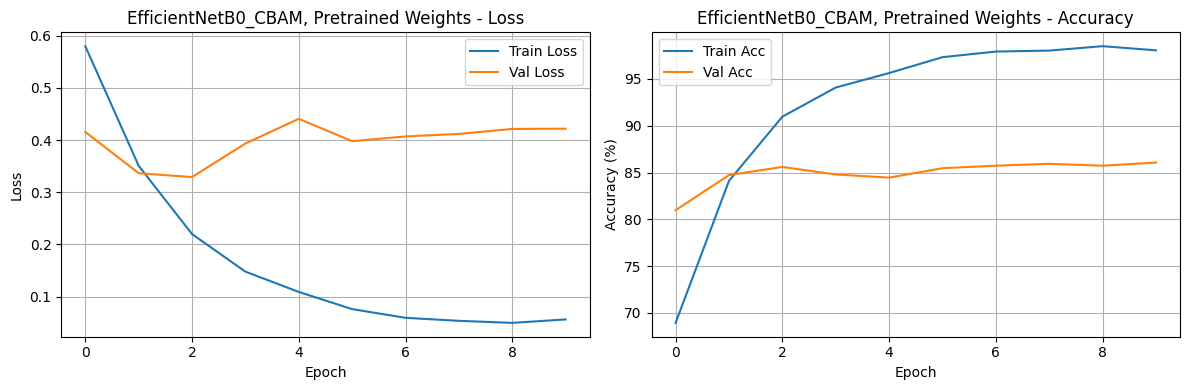


Classification Report for MODEL NOT NAMED':

              precision    recall  f1-score   support

   Non-Toxic       0.84      0.87      0.86       749
       Toxic       0.87      0.84      0.85       744

    accuracy                           0.86      1493
   macro avg       0.86      0.86      0.86      1493
weighted avg       0.86      0.86      0.86      1493



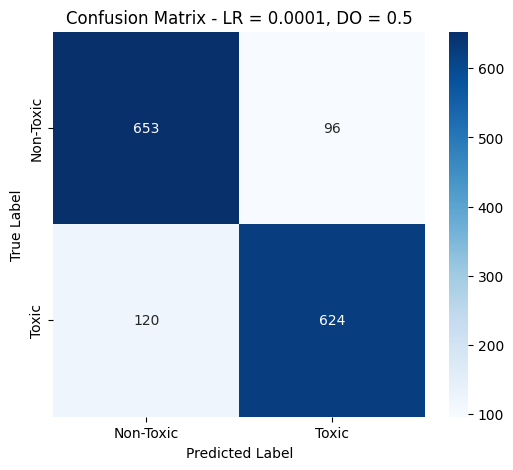

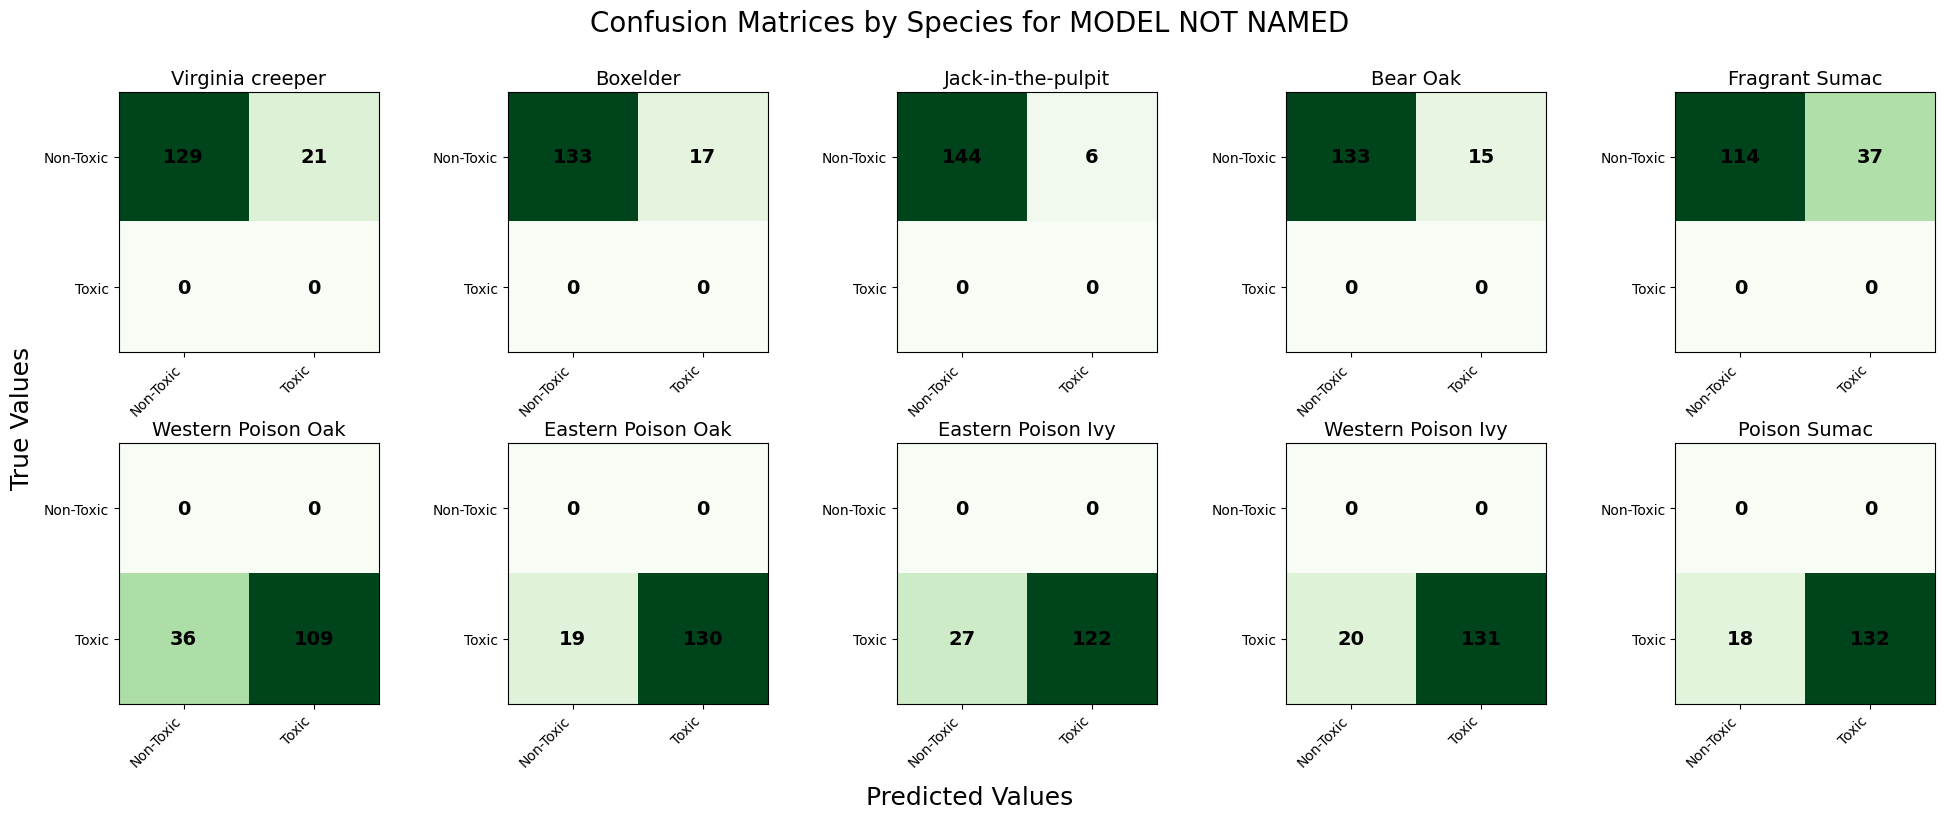

                    False Negative Rate
Western Poison Oak  0.248276           
Eastern Poison Oak  0.127517           
Eastern Poison Ivy  0.181208           
Western Poison Ivy  0.132450           
Poison Sumac        0.120000           


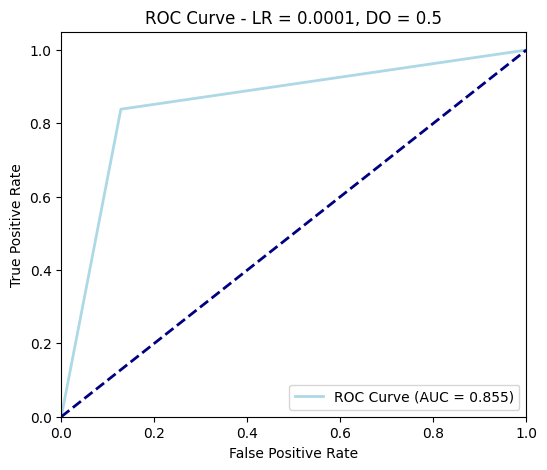

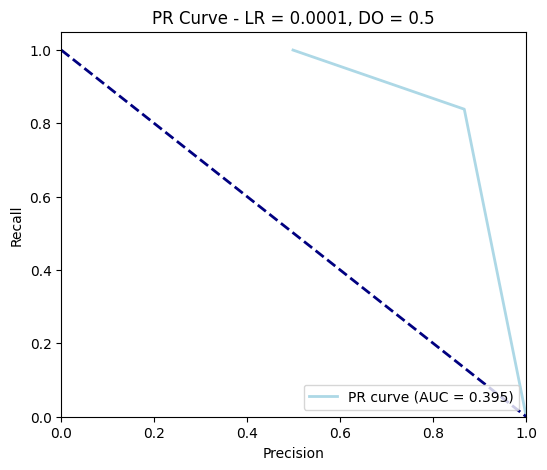

EfficientNetB0_CBAM, Pretrained Weights0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.29it/s]


Train Loss: 0.5614, Train Acc: 69.91%
Val Loss: 0.4084, Val Acc: 80.64%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.99it/s]


Train Loss: 0.3477, Train Acc: 84.71%
Val Loss: 0.3339, Val Acc: 84.80%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.25it/s]


Train Loss: 0.2118, Train Acc: 90.86%
Val Loss: 0.3341, Val Acc: 84.86%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.25it/s]


Train Loss: 0.1354, Train Acc: 94.63%
Val Loss: 0.3916, Val Acc: 84.53%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.28it/s]


Train Loss: 0.1102, Train Acc: 95.49%
Val Loss: 0.3802, Val Acc: 85.40%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.67it/s]


Train Loss: 0.0613, Train Acc: 98.03%
Val Loss: 0.3890, Val Acc: 85.33%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.73it/s]


Train Loss: 0.0550, Train Acc: 98.12%
Val Loss: 0.3802, Val Acc: 86.20%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.84it/s]


Train Loss: 0.0518, Train Acc: 98.31%
Val Loss: 0.3888, Val Acc: 85.87%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.95it/s]


Train Loss: 0.0461, Train Acc: 98.48%
Val Loss: 0.3958, Val Acc: 85.93%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.83it/s]


Train Loss: 0.0465, Train Acc: 98.65%
Val Loss: 0.4149, Val Acc: 85.93%


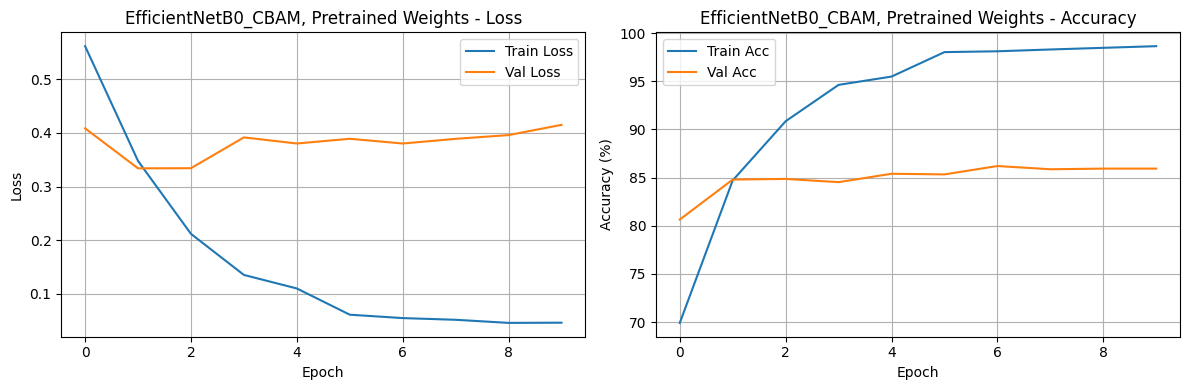


Classification Report for MODEL NOT NAMED':

              precision    recall  f1-score   support

   Non-Toxic       0.82      0.89      0.86       749
       Toxic       0.88      0.81      0.84       744

    accuracy                           0.85      1493
   macro avg       0.85      0.85      0.85      1493
weighted avg       0.85      0.85      0.85      1493



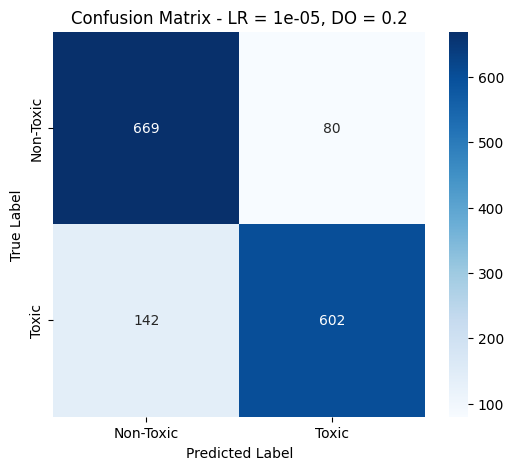

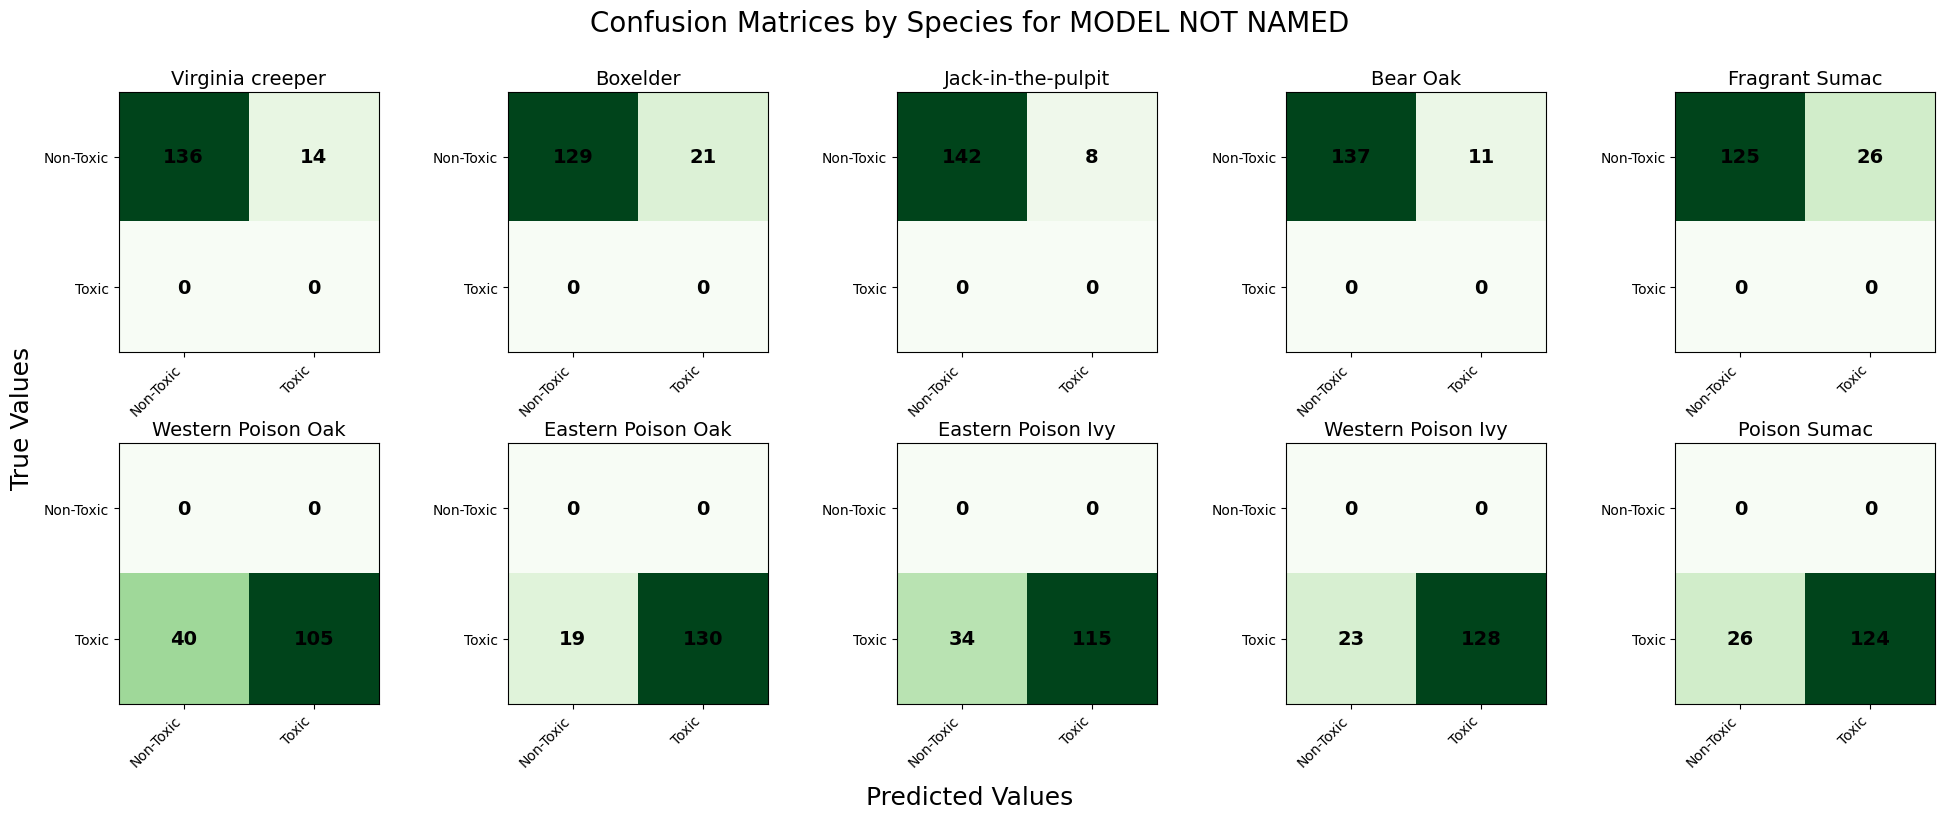

                    False Negative Rate
Western Poison Oak  0.275862           
Eastern Poison Oak  0.127517           
Eastern Poison Ivy  0.228188           
Western Poison Ivy  0.152318           
Poison Sumac        0.173333           


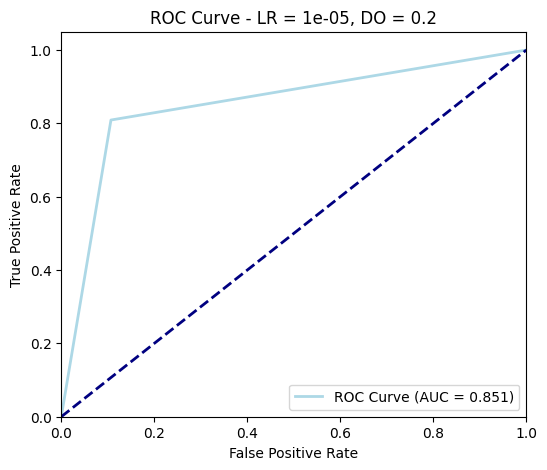

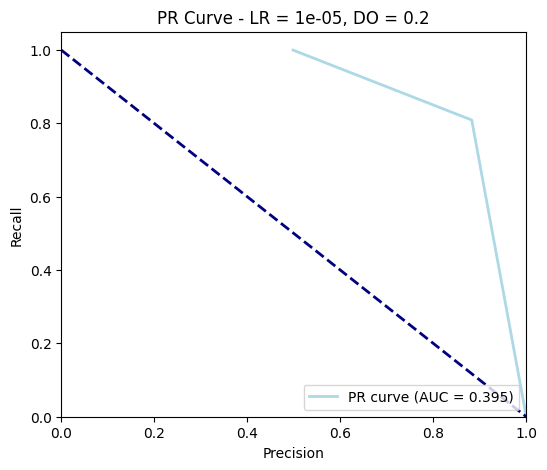

EfficientNetB0_CBAM, Pretrained Weights0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.75it/s]


Train Loss: 0.5716, Train Acc: 68.96%
Val Loss: 0.4062, Val Acc: 79.84%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.37it/s]


Train Loss: 0.3375, Train Acc: 84.48%
Val Loss: 0.3435, Val Acc: 85.06%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.59it/s]


Train Loss: 0.2179, Train Acc: 90.83%
Val Loss: 0.3387, Val Acc: 85.33%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.70it/s]


Train Loss: 0.1448, Train Acc: 94.10%
Val Loss: 0.3544, Val Acc: 86.74%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.87it/s]


Train Loss: 0.1035, Train Acc: 95.69%
Val Loss: 0.3854, Val Acc: 85.93%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.98it/s]


Train Loss: 0.0667, Train Acc: 97.59%
Val Loss: 0.3627, Val Acc: 86.54%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.98it/s]


Train Loss: 0.0613, Train Acc: 97.93%
Val Loss: 0.3590, Val Acc: 87.21%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.07it/s]


Train Loss: 0.0490, Train Acc: 98.41%
Val Loss: 0.3723, Val Acc: 87.07%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.82it/s]


Train Loss: 0.0522, Train Acc: 98.19%
Val Loss: 0.3676, Val Acc: 87.14%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.17it/s]


Train Loss: 0.0446, Train Acc: 98.49%
Val Loss: 0.3793, Val Acc: 87.27%


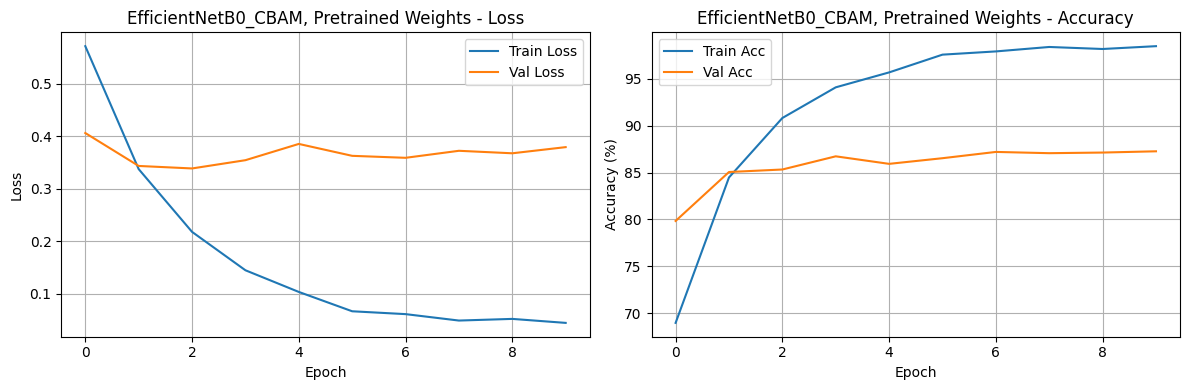


Classification Report for MODEL NOT NAMED':

              precision    recall  f1-score   support

   Non-Toxic       0.86      0.87      0.87       749
       Toxic       0.87      0.86      0.86       744

    accuracy                           0.87      1493
   macro avg       0.87      0.87      0.87      1493
weighted avg       0.87      0.87      0.87      1493



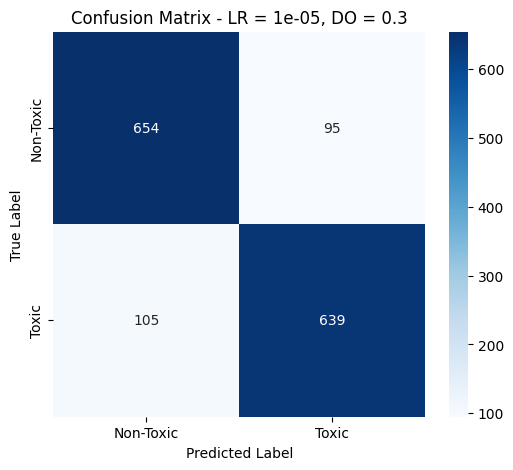

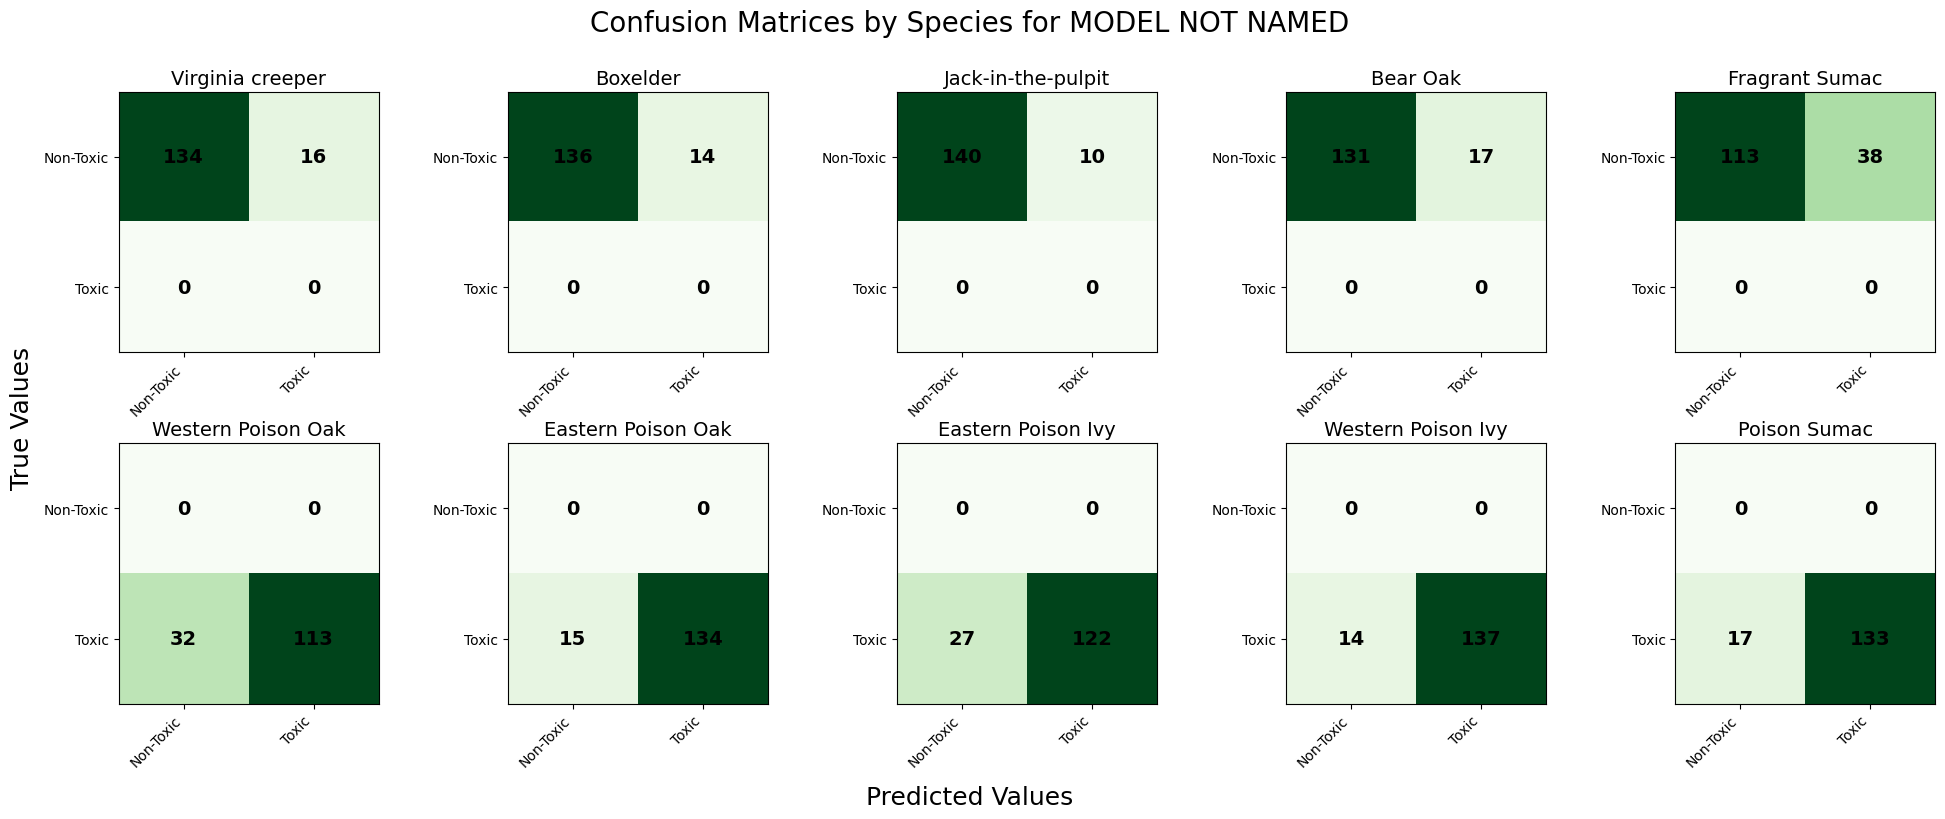

                    False Negative Rate
Western Poison Oak  0.220690           
Eastern Poison Oak  0.100671           
Eastern Poison Ivy  0.181208           
Western Poison Ivy  0.092715           
Poison Sumac        0.113333           


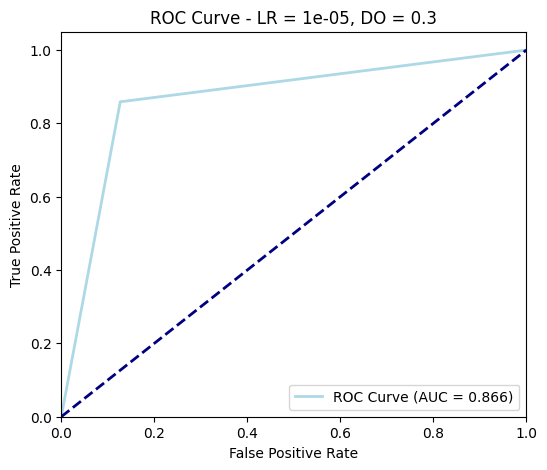

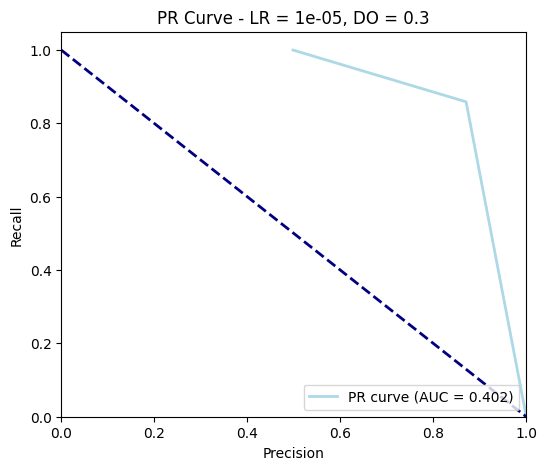

EfficientNetB0_CBAM, Pretrained Weights0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.80it/s]


Train Loss: 0.5626, Train Acc: 70.76%
Val Loss: 0.4189, Val Acc: 80.71%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.47it/s]


Train Loss: 0.3542, Train Acc: 84.05%
Val Loss: 0.3517, Val Acc: 82.99%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.59it/s]


Train Loss: 0.2171, Train Acc: 90.40%
Val Loss: 0.3623, Val Acc: 85.26%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.76it/s]


Train Loss: 0.1514, Train Acc: 93.97%
Val Loss: 0.4097, Val Acc: 84.46%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.48it/s]


Train Loss: 0.1069, Train Acc: 95.89%
Val Loss: 0.4010, Val Acc: 85.87%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.10it/s]


Train Loss: 0.0649, Train Acc: 97.67%
Val Loss: 0.3935, Val Acc: 86.47%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.84it/s]


Train Loss: 0.0631, Train Acc: 97.76%
Val Loss: 0.4064, Val Acc: 86.14%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.43it/s]


Train Loss: 0.0549, Train Acc: 98.32%
Val Loss: 0.4153, Val Acc: 86.00%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.32it/s]


Train Loss: 0.0510, Train Acc: 98.18%
Val Loss: 0.4247, Val Acc: 86.47%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.69it/s]


Train Loss: 0.0527, Train Acc: 98.31%
Val Loss: 0.4318, Val Acc: 85.67%


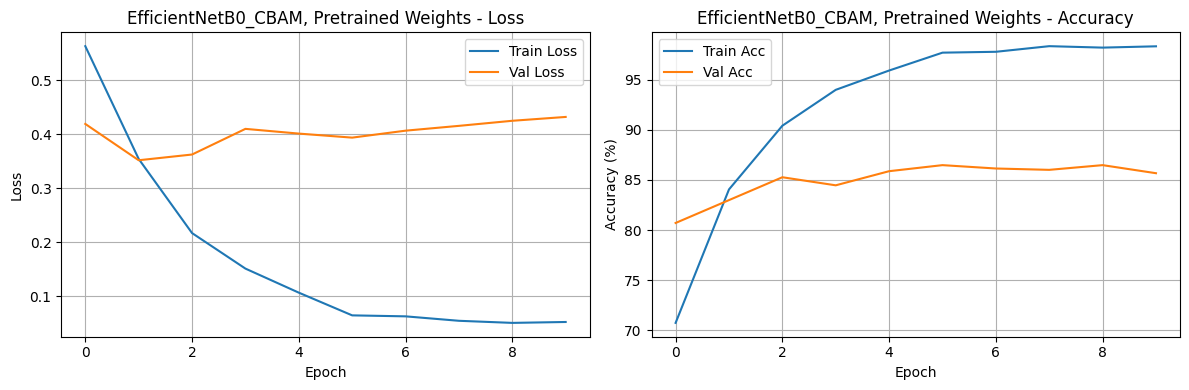


Classification Report for MODEL NOT NAMED':

              precision    recall  f1-score   support

   Non-Toxic       0.83      0.88      0.86       749
       Toxic       0.87      0.82      0.85       744

    accuracy                           0.85      1493
   macro avg       0.85      0.85      0.85      1493
weighted avg       0.85      0.85      0.85      1493



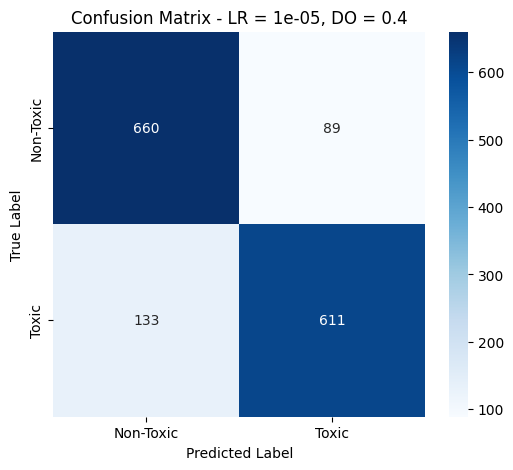

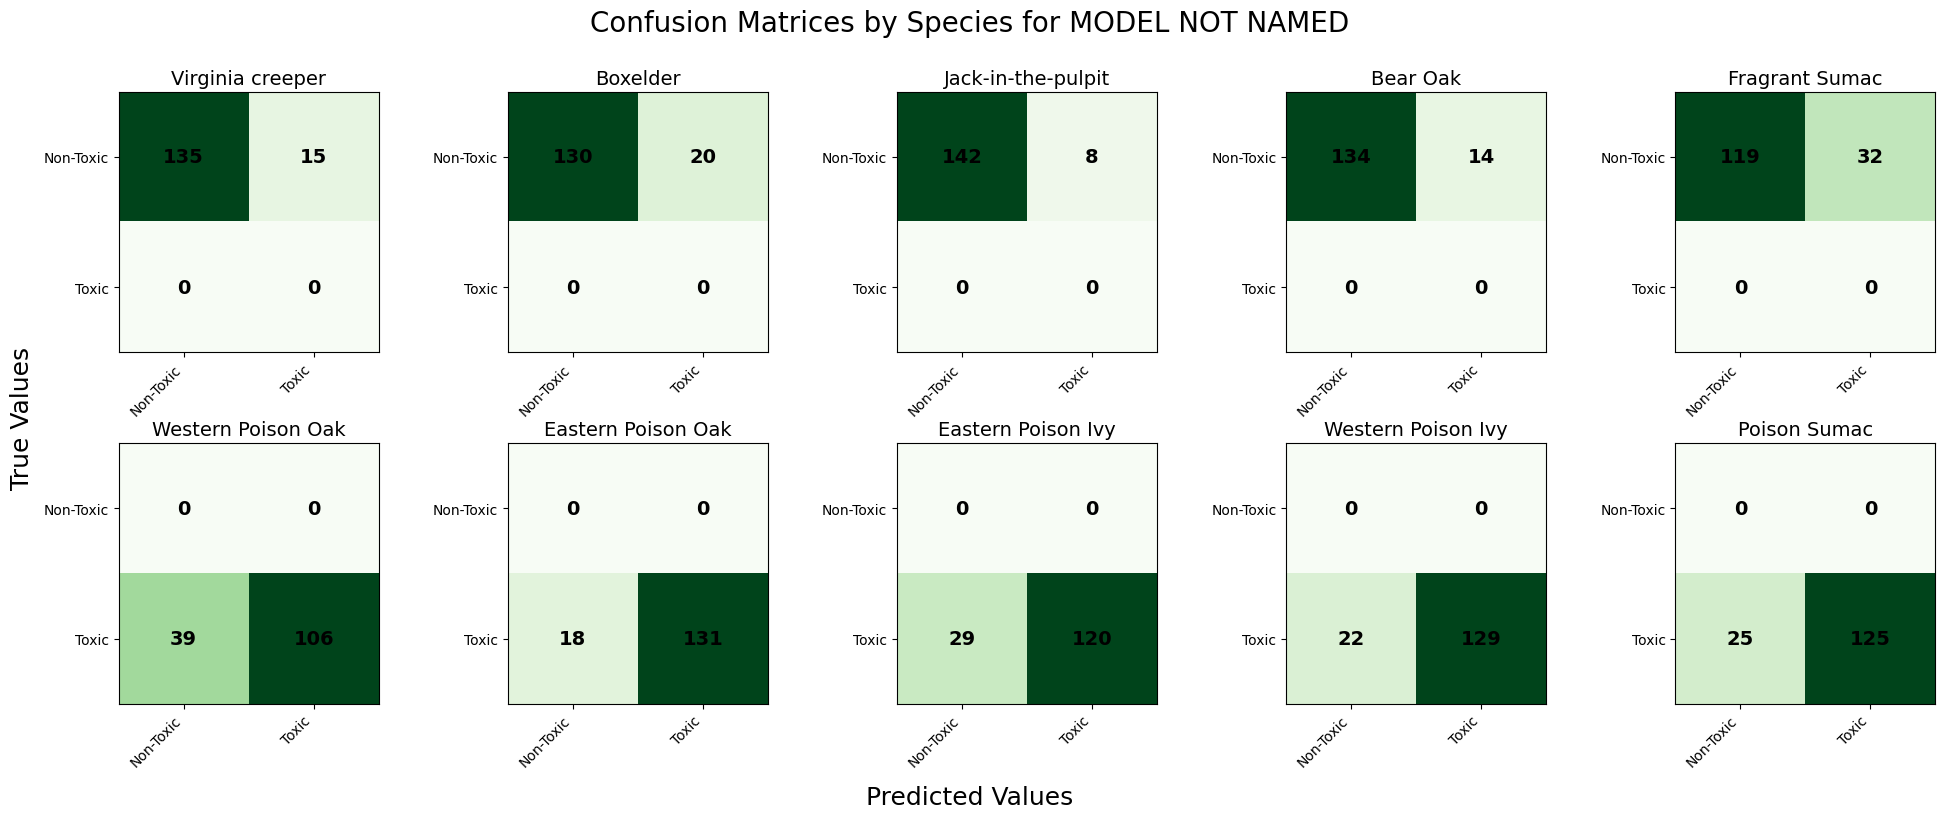

                    False Negative Rate
Western Poison Oak  0.268966           
Eastern Poison Oak  0.120805           
Eastern Poison Ivy  0.194631           
Western Poison Ivy  0.145695           
Poison Sumac        0.166667           


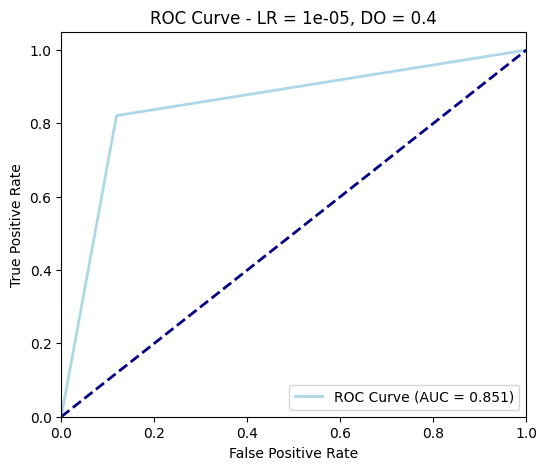

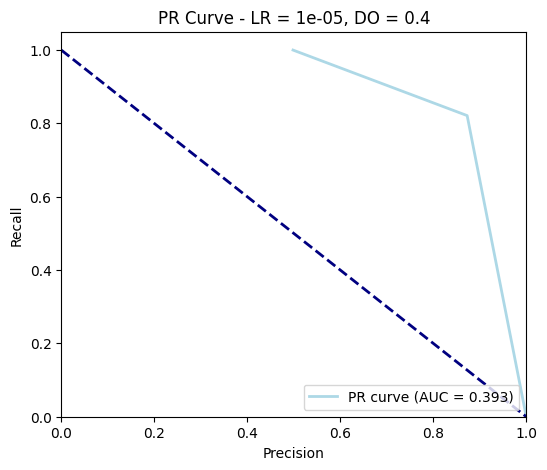

EfficientNetB0_CBAM, Pretrained Weights0: 4,215,008

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.48it/s]


Train Loss: 0.5729, Train Acc: 68.88%
Val Loss: 0.4059, Val Acc: 80.58%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.05it/s]


Train Loss: 0.3378, Train Acc: 84.75%
Val Loss: 0.3455, Val Acc: 84.46%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.82it/s]


Train Loss: 0.2225, Train Acc: 90.80%
Val Loss: 0.3340, Val Acc: 85.40%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.41it/s]


Train Loss: 0.1454, Train Acc: 94.34%
Val Loss: 0.3684, Val Acc: 85.93%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.52it/s]


Train Loss: 0.1131, Train Acc: 95.64%
Val Loss: 0.3886, Val Acc: 85.33%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.70it/s]


Train Loss: 0.0725, Train Acc: 97.44%
Val Loss: 0.3792, Val Acc: 86.00%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.41it/s]


Train Loss: 0.0628, Train Acc: 97.93%
Val Loss: 0.3770, Val Acc: 86.60%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.61it/s]


Train Loss: 0.0576, Train Acc: 98.12%
Val Loss: 0.3843, Val Acc: 85.87%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 12.31it/s]


Train Loss: 0.0516, Train Acc: 98.26%
Val Loss: 0.4009, Val Acc: 85.80%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 47/47 [00:03<00:00, 13.25it/s]


Train Loss: 0.0453, Train Acc: 98.55%
Val Loss: 0.4021, Val Acc: 86.60%


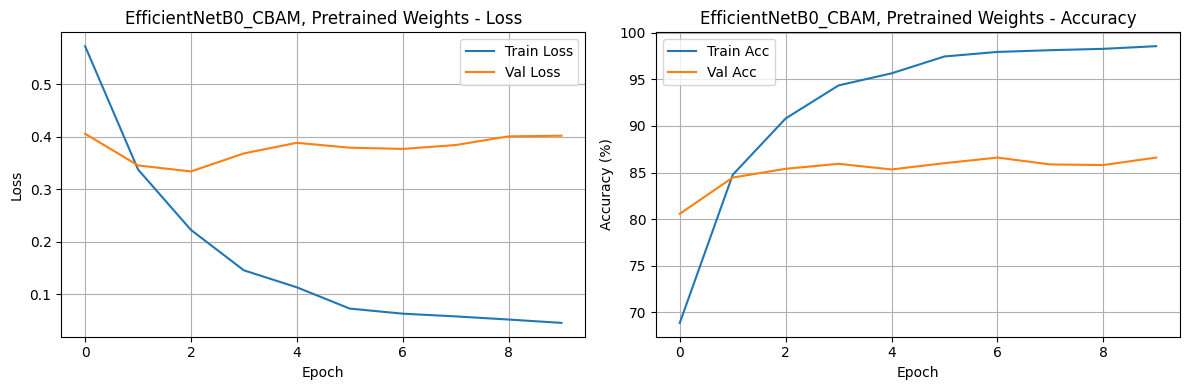


Classification Report for MODEL NOT NAMED':

              precision    recall  f1-score   support

   Non-Toxic       0.85      0.88      0.86       749
       Toxic       0.87      0.84      0.86       744

    accuracy                           0.86      1493
   macro avg       0.86      0.86      0.86      1493
weighted avg       0.86      0.86      0.86      1493



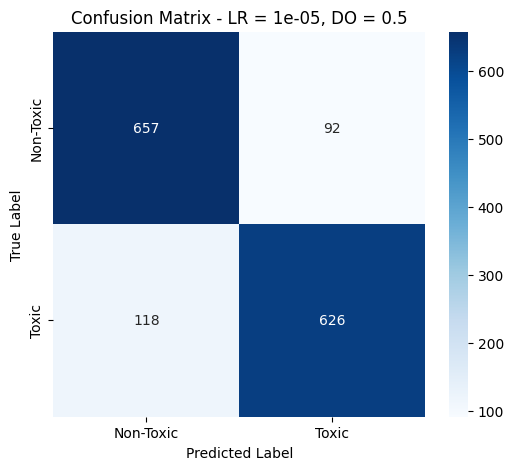

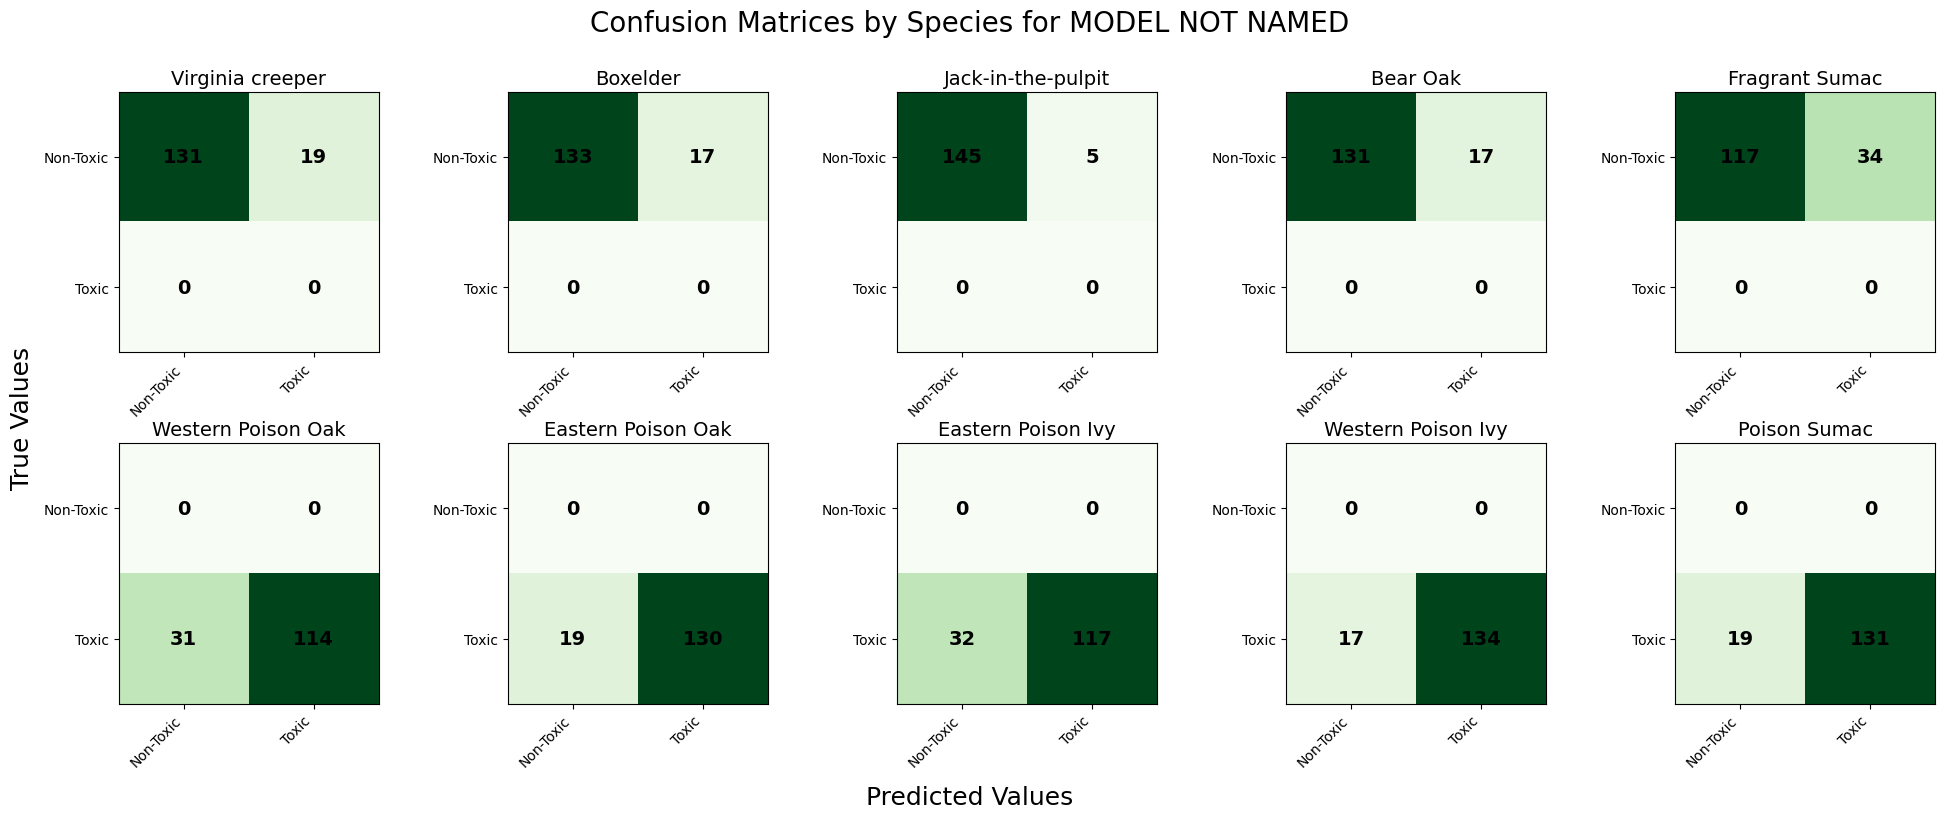

                    False Negative Rate
Western Poison Oak  0.213793           
Eastern Poison Oak  0.127517           
Eastern Poison Ivy  0.214765           
Western Poison Ivy  0.112583           
Poison Sumac        0.126667           


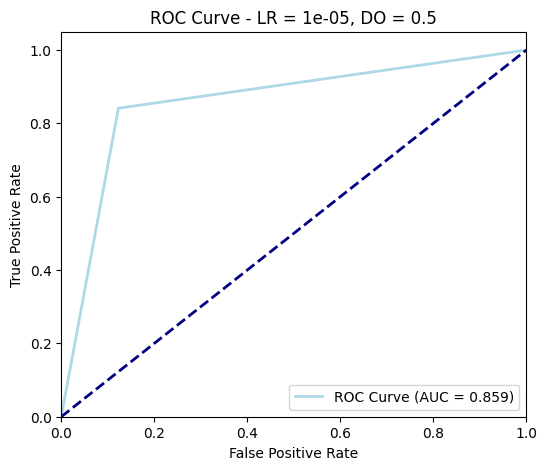

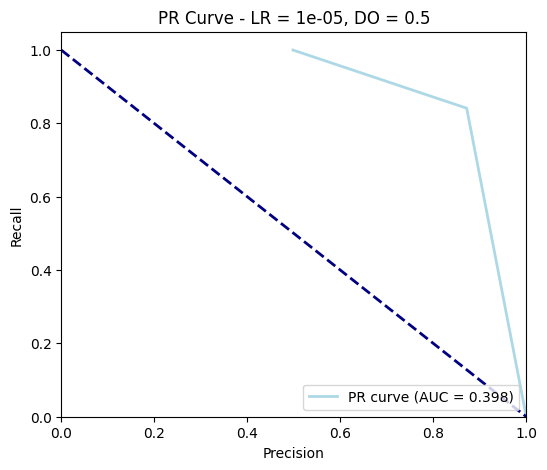

learning rate  dropout  accuracy  precision    recall  f1-score   roc_auc  \
0         0.00100      0.2  0.855325   0.856757  0.852151  0.854447  0.855314   
1         0.00100      0.3  0.857334   0.861224  0.850806  0.855984  0.857312   
2         0.00100      0.4  0.848627   0.854795  0.838710  0.846676  0.848594   
3         0.00100      0.5  0.856664   0.846859  0.869624  0.858090  0.856708   
4         0.00010      0.2  0.854655   0.863448  0.841398  0.852280  0.854611   
5         0.00010      0.3  0.857334   0.863201  0.848118  0.855593  0.857303   
6         0.00010      0.4  0.865372   0.879720  0.845430  0.862234  0.865305   
7         0.00010      0.5  0.855325   0.866667  0.838710  0.852459  0.855269   
8         0.00001      0.2  0.851306   0.882698  0.809140  0.844320  0.851165   
9         0.00001      0.3  0.866042   0.870572  0.858871  0.864682  0.866018   
10        0.00001      0.4  0.851306   0.872857  0.821237  0.846260  0.851206   
11        0.00001      0.5  0.859344   0.871866  0.841398  0.856361  0.859284   

      pr_auc  
0   0.392967  
1   0.394863  
2   0.388614  
3   0.392401  
4   0.393615  
5   0.395177  
6   0.402763  
7   0.394550  
8   0.395149  
9   0.401560  
10  0.393263  
11  0.397824

In [161]:
lr = [0.001, 0.0001, 0.00001]
do = [0.2, 0.3, 0.4, 0.5]

met_df = []

def ab_metrics(current_model):
    current_model.eval()
    y_true = []
    y_pred = []
    species_list = []

    if current_model == model_rand_weights_la:
        name = 'EfficientNetB0, Random Weights, Light Aug'
    elif current_model == model_rand_weights_ha:
        name = 'EfficientNetB0, Random Weights, Heavy Aug'
    elif current_model == model_pretrained_weights_la:
        name = 'EfficientNetB0, Pretrained Weights, Light Aug'
    elif current_model == model_pretrained_weights_ha:
        name = 'EfficientNetB0, Pretrained Weights, Heavy Aug'
    elif current_model == model_cbam_random_la:
        name = 'EfficientNetB0_CBAM, Random Weights, Light Aug'
    elif current_model == model_cbam_random_ha:
        name = 'EfficientNetB0_CBAM, Random Weights, Heavy Aug'
    elif current_model == model_cbam_pretrained_la:
        name = 'EfficientNetB0_CBAM, Pretrained Weights, Light Aug'
    elif current_model == model_cbam_pretrained_ha:
        name = 'EfficientNetB0_CBAM, Pretrained Weights, Heavy Aug'
    else:
        name = 'MODEL NOT NAMED'
    
    with torch.no_grad():
        for images, labels, species in test_loader:
            n = images.size(0)
            images, labels = images.to(device), labels.to(device)
            outputs = current_model(images)
            _, predicted = outputs.max(1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            species_list.extend(species)

    df_test = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'species': species_list
    })

    cm = confusion_matrix(y_true, y_pred)
    
    # Print classification report
    cr = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    #acc[name] = cr['accuracy']
    #prec[name] = cr['Toxic']['precision']
    #rec[name] = cr['Toxic']['recall']
    #f1toxic[name] = cr['Toxic']['f1-score']
    #ftnontoxic[name] = cr['Non-toxic']['f1-score']

    
    print(f"\nClassification Report for {name}':\n")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - LR = {l}, DO = {d}')
    plt.show()

    # False negative rate for model (only toxic species)
    TN, FP, FN, TP = cm.ravel()
    if FN > 0:
        fn[name] = FN / (FN + TP)

    # Confsion matrices to interpret specific plant pairs
    species_list = full_meta.sort_values(['toxicity','class_id'])['slang'].unique()
    n_species = len(species_list)
    fn_species = {}
    
    cols, rows = 5, 2
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten()
    fig.suptitle(f'Confusion Matrices by Species for {name}', fontsize=20, y=1.01)
    for ax, species in zip(axes, species_list):
        species_df = df_test[df_test['species'] == species]
        cm_species = confusion_matrix(species_df['y_true'], species_df['y_pred'], labels=[0, 1])
        TN, FP, FN, TP = cm_species.ravel()
        if FN > 0:
            fn_species[species] = FN / (FN + TP)
        im = ax.imshow(cm_species, cmap='Greens')
        ax.set_title(species, fontsize=14)
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(class_names, rotation=45, ha='right')
        ax.set_yticklabels(class_names)
    
        for i in range(cm_species.shape[0]):
            for j in range(cm_species.shape[1]):
                ax.text(
                    j, i, str(cm_species[i, j]),
                    ha='center', va='center',
                    fontsize=14, fontweight='bold',
                    color='black'
                )
    for ax in axes[len(species_list):]:
        ax.axis('off')
    fig.supxlabel('Predicted Values', fontsize=18)
    fig.supylabel('True Values', fontsize=18)
    plt.tight_layout()
    plt.show()
    fn_species_df = pd.DataFrame.from_dict(fn_species, orient='index')
    fn_species_df.columns = ['False Negative Rate']
    print(fn_species_df.to_string(justify='left'))

    # ROC Curve & AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    #roc[name] = roc_auc

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='lightblue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - LR = {l}, DO = {d}')
    plt.legend(loc="lower right")
    plt.show()

    # PR Curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(precision, recall)
    #pr[name] = pr_auc

    plt.figure(figsize=(6,5))
    plt.plot(precision, recall, color='lightblue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title(f'PR Curve - LR = {l}, DO = {d}')
    plt.legend(loc="lower right")
    plt.show()

    met_df.append({"learning rate": l, "dropout": d, "accuracy": cr['accuracy'], "precision": cr['Toxic']['precision'], "recall": cr['Toxic']['recall'],
                   "f1-score": cr['Toxic']['f1-score'], "roc_auc": roc_auc, "pr_auc": pr_auc})

for l in lr:
    learning_rate = l
    for d in do:
        dropout = d
        model_cbam_pretrained_ha_loop = EfficientNetB0_CBAM(num_classes=2, pretrained=True)
        show_training(model_cbam_pretrained_ha_loop, 'EfficientNetB0_CBAM, Pretrained Weights', train_loader=train_strong_loader)
        ab_metrics(model_cbam_pretrained_ha_loop)

met_df = pd.DataFrame(met_df)
met_df

### Grad-Cam

In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

class GradCAM:
    def __init__(self, model, target_layer):
        """
        Grad-CAM implementation for EfficientNet-B0
        
        Args:
            model: The EfficientNet model
            target_layer: The layer to compute gradients from (e.g., model.features[-1])
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        """Hook to save forward pass activations"""
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        """Hook to save backward pass gradients"""
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class=None):
        """
        Generate Grad-CAM heatmap
        
        Args:
            input_image: Input tensor (1, C, H, W)
            target_class: Target class index. If None, uses predicted class.
        
        Returns:
            cam: Grad-CAM heatmap (H, W)
            prediction: Model prediction
        """
        # Forward pass
        self.model.eval()
        output = self.model(input_image)
        
        # Get predicted class if not specified
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # Backward pass
        self.model.zero_grad()
        class_loss = output[0, target_class]
        class_loss.backward()
        
        # Calculate Grad-CAM
        gradients = self.gradients[0]  # (C, H, W)
        activations = self.activations[0]  # (C, H, W)
        
        # Global average pooling of gradients
        weights = gradients.mean(dim=(1, 2))  # (C,)
        
        # Weighted combination of activation maps
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        # Apply ReLU and normalize
        cam = F.relu(cam)
        cam = cam.cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        return cam, output
    
    def visualize(self, image_path, save_path=None, alpha=0.4):
        """
        Generate and visualize Grad-CAM overlay
        
        Args:
            image_path: Path to input image
            save_path: Path to save visualization (optional)
            alpha: Transparency of heatmap overlay
        """
        # Load and preprocess image
        img = Image.open(image_path).convert('RGB')
        img_tensor = self.preprocess_image(img)
        
        # Generate Grad-CAM
        cam, output = self.generate_cam(img_tensor)
        
        # Get prediction
        probs = F.softmax(output, dim=1)
        pred_class = output.argmax(dim=1).item()
        confidence = probs[0, pred_class].item()
        
        # Resize CAM to match input image size
        cam_resized = cv2.resize(cam, (img.width, img.height))
        
        # Convert to heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
        # Overlay on original image
        img_array = np.array(img)
        overlay = (heatmap * alpha + img_array * (1 - alpha)).astype(np.uint8)
        
        # Visualize
        fig, axes = plt.subplots(1, 3, figsize=(9, 5))
        
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        axes[1].imshow(cam_resized, cmap='jet')
        axes[1].set_title(f'Grad-CAM\nPrediction: {"Toxic" if pred_class == 1 else "Non-toxic"} ({confidence:.2%})')
        axes[1].axis('off')
        
        axes[2].imshow(overlay)
        axes[2].set_title('Overlay')
        axes[2].axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        
        plt.show()
        
        return cam_resized, pred_class, confidence
    
    def preprocess_image(self, img):
        """Preprocess image for EfficientNet"""
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
        train_transform_strong = transforms.v2.Compose([
            transforms.v2.RandomResizedCrop((img_height, img_width), scale=(0.8, 1.0)),
            transforms.v2.RandomHorizontalFlip(),
            transforms.v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        return train_transform_strong(img).unsqueeze(0).to(next(self.model.parameters()).device)


# Example usage
def apply_gradcam(model, image_path, save_path=None):
    """
    Apply Grad-CAM to an image using the EfficientNet model
    
    Args:
        model: Your trained EfficientNet-B0 model
        image_path: Path to the image
        save_path: Optional path to save the visualization
    """
    # Target the last convolutional layer
    # For EfficientNet-B0, this is typically model.features[-1]
    target_layer = model.features[-1]
    
    # Create Grad-CAM object
    grad_cam = GradCAM(model, target_layer)
    
    # Generate and visualize
    cam, pred_class, confidence = grad_cam.visualize(image_path, save_path)
    
    print(f"Prediction: {'Toxic' if pred_class == 1 else 'Non-toxic'}")
    print(f"Confidence: {confidence:.2%}")
    
    return grad_cam

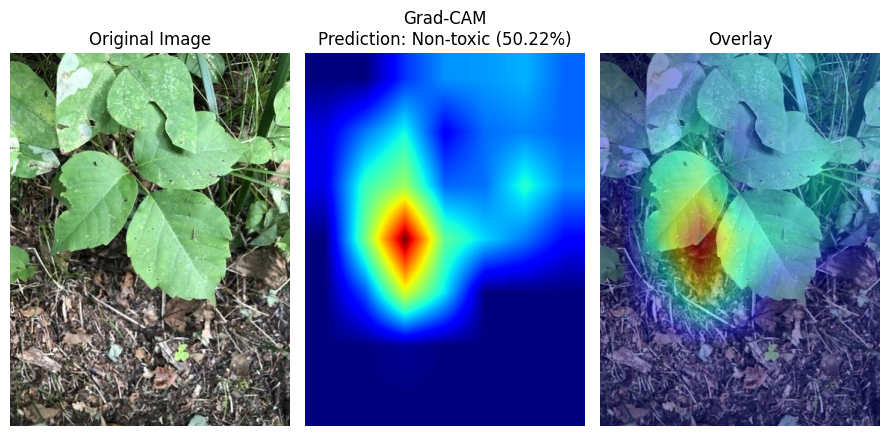

Prediction: Non-toxic
Confidence: 50.22%


In [165]:
model = EfficientNetB0_CBAM(pretrained=True)
model.eval()
grad_cam = apply_gradcam(
    model=model,
    image_path='../input/toxic-plant-classification/tpc-imgs/toxic_images/003/051.jpg',
    save_path='gradcam_result.png'
)
